# Imports

In [1]:
import itertools
import json
import os
import pprint
from collections import defaultdict
from pathlib import Path
from typing import Literal, Optional

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from IPython.display import display
from tqdm.notebook import tqdm

from utils import plotting as plot_utils
from utils.file_utils import get_model_short_name
from utils_extraction import metrics

In [2]:
# increase figure size to (8, 8)
rcParams["figure.figsize"] = (8, 8)
rcParams["figure.dpi"] = 150
plt.style.use("ggplot")

# Constants

In [3]:
SAVE_DIR = Path("extraction_results")


DEBERTA = "deberta-v2-xxlarge-mnli"
LLAMA_7B_CHAT = "meta-llama/Llama-2-7b-chat-hf"

DATASET_ORDER = (
    "imdb",
    "amazon-polarity",
    "ag-news",
    "dbpedia-14",
    "copa",
    "rte",
    "boolq",
    "qnli",
    "piqa",
)
METHOD_ORDER = (
    "CCS",
    "LR",
    "Random",
    "CCS+LR",
    "CCS-in-LR-span",
    "CCS-md",
    "LR-md",
    "Random-md",
    "RCCS",
)

# Utils

## Data loading/preprocessing

In [4]:
# Data loading and preprocessing


def method_uses_labeled_and_unlabeled_data(method):
    return method in ("CCS+LR", "CCS-in-LR-span", "CCS-select-LR")


def filter_train_equals_test_per_method(df):
    """Filters rows where train == test if the method uses labeled and unlabeled data.

    Example use case: when plotting transfer accuracy of methods that use
    labeled and unlabeled data, we should evaluate the transfer accuracy by
    using the test set as the unlabeled train set, which corresponds to the
    "train" column for such methods.
    """
    method_dfs = []
    for method, method_df in df.groupby("method"):
        if method_uses_labeled_and_unlabeled_data(method):
            method_df = method_df[method_df["train"] == method_df["test"]]
        method_dfs.append(method_df)

    return pd.concat(method_dfs, ignore_index=True)


def get_labeled_and_unlabeled_train_data(
    row: pd.Series,
) -> tuple[str, Optional[str]]:
    """Get the main train dataset and the labeled train dataset names.

    Args:
        row: Experiment results DataFrame row.

    Returns:
        A tuple of the main train dataset names and the labeled train dataset
        names. If the method uses only labeled datasets (e.g., LR) or only
        unlabeled datasets (e.g., CCS), these datasets are considered the main
        datasets, and the second element of the tuple is an empty string.
        Otherwise, the first element is the unlabeled dataset and the second
        element is the labeled dataset (e.g., for CCS+LR).
    """
    if method_uses_labeled_and_unlabeled_data(row.method):
        no_label_train, label_train = row.train.split("-label_")
        if not no_label_train.startswith("nolabel_"):
            raise ValueError(
                f"Expected no_label_train to start with 'no_label_', got {no_label_train}"
            )

        train = no_label_train[len("nolabel_") :]
        train_labeled = label_train
    else:
        train = row.train
        train_labeled = ""

    return [train, train_labeled]


def flatten_dictionary(d, parent_key="", sep="."):
    """
    Flatten a nested dictionary.

    Args:
        d (dict): The nested dictionary to flatten.
        parent_key (str): The parent key (used in recursion).
        sep (str): The separator for joining keys.

    Returns:
        dict: Flattened dictionary.
    """
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dictionary(v, parent_key=new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def load_eval_csvs(
    save_dir,
    experiment_name,
    model_filter=None,
    train_set_filter=None,
    eval_set_filter=None,
    use_latest_run_id: bool = True,
    use_best_in_domain_acc: bool = True,
    verbose: bool = True,
):
    base_path = Path(save_dir) / experiment_name
    csv_files = base_path.glob("**/eval.csv")

    all_data = []
    for csv_file in tqdm(list(csv_files)):
        # Extract components from the path
        parts = csv_file.parts
        train_set = parts[-6]
        seed = parts[-5].split("_")[-1]
        run_id = parts[-4]
        eval_dataset = parts[-2]

        # Read the CSV
        df = pd.read_csv(csv_file)

        # Sanity checks
        if not all(df["train"] == train_set) or not all(df["test"] == eval_dataset):
            raise ValueError(f"Sanity check failed for {csv_file}")

        # Set "train" and "train_labeled" columns based on the "train" dataset
        # string, which may combine labeled and unlabeled datasets (e.g., for
        # CCS+LR method).
        train_and_train_labeled_df = pd.DataFrame(
            list(df.apply(get_labeled_and_unlabeled_train_data, axis=1)),
            columns=["train", "train_labeled"],
        )
        df["train"] = train_and_train_labeled_df["train"]
        train_col_loc = df.columns.get_loc("train")
        df.insert(
            train_col_loc + 1,
            "train_labeled",
            train_and_train_labeled_df["train_labeled"],
        )

        # Add new columns
        df["save_dir"] = save_dir
        df["experiment_name"] = experiment_name
        df["seed"] = int(seed)
        df["run_id"] = int(run_id)

        # Add columns from config.
        eval_dir = os.path.join(*csv_file.parts[:-3])
        config_path = Path(eval_dir) / "config.json"
        if config_path.exists():
            with open(config_path, "r") as f:
                config = json.load(f)

            # Remove type annotations.
            del config["__annotations__"]
            config = flatten_dictionary(config)

            for key, value in config.items():
                # If the value is an iterable, repeat it for each row.
                # Otherwise, pandas assumes len(value) == len(df).
                if isinstance(value, (list, tuple)):
                    value = [value] * len(df)
                df[key] = value

        all_data.append(df)

    if not all_data:
        raise ValueError(f"No eval CSV files found for experiment {experiment_name}.")

    # Concatenate all dataframes
    final_df = pd.concat(all_data, ignore_index=True)

    # Optional filtering
    if model_filter:
        final_df = final_df[final_df["model"] == model_filter]
    if train_set_filter:
        final_df = final_df[final_df["train"] == train_set_filter]
    if eval_set_filter:
        final_df = final_df[final_df["test"] == eval_set_filter]

    if use_latest_run_id:
        final_df = get_latest_run_id_df(final_df)
    if use_best_in_domain_acc:
        final_df = get_best_metric_by_acc_df(final_df)

    return final_df


def get_latest_run_id_df(df):
    latest_group_dfs = []
    for key, group_df in df.groupby(
        [
            "model",
            "prefix",
            "method",
            "mode",
            "train",
            "train_labeled",
            "test",
            "seed",
            "num_orthogonal_directions",
        ]
    ):
        max_run_id = group_df.run_id.max()
        group_df = group_df[group_df.run_id == max_run_id]
        latest_group_dfs.append(group_df)

    latest_run_df = pd.concat(latest_group_dfs, ignore_index=True)

    for key, group_df in latest_run_df.groupby(
        [
            "model",
            "prefix",
            "method",
            "mode",
            "train",
            "train_labeled",
            "test",
            "prompt_level",
            "location",
            "layer",
            "seed",
            "num_orthogonal_directions",
        ]
    ):
        num_unique_run_ids = group_df.run_id.nunique()
        if num_unique_run_ids != 1:
            raise ValueError(
                f"Expected 1 unique run_id, but got {num_unique_run_ids} for {key}"
            )

    return latest_run_df


def get_dataset_names_from_str(train_sets_str: str) -> list[str]:
    return train_sets_str.split("+")


def get_best_metric_by_acc_df(df):
    """Flip metrics for each experiment if it improves in-domain accuracy.

    Use the in-domain accuracy to decide whether to flip the accuracy instead of
    computing max(acc, 1-acc) for test datasets even if the in-domain accuracy
    is greater than 0.5. Also flips the ECE if the flipped accuracy is better.

    In-domain accuracy for a given dataset is computed as the mean accuracy over
    all the prompts when evaluated on that same dataset. The model, prefix,
    method, token location, layer, and seed are held constant.
    """
    processed_df = []
    for key, train_df in df.groupby(
        [
            "model",
            "prefix",
            "method",
            "mode",
            "train",
            "train_labeled",
            "location",
            "layer",
            "seed",
            "num_orthogonal_directions",
        ]
    ):
        assert len(train_df["train"].unique()) == 1
        train_ds_str = train_df["train"].iloc[0]
        train_ds_list = get_dataset_names_from_str(train_ds_str)

        assert len(train_df["train_labeled"].unique()) == 1
        train_labeled_ds_str = train_df["train_labeled"].iloc[0]
        train_labeled_ds_list = (
            get_dataset_names_from_str(train_labeled_ds_str)
            if train_labeled_ds_str is not None
            else []
        )

        # If the method uses both labeled and unlabeled datasets, only use the
        # labeled datasets as the "in-domain" datasets to decide whether to flip
        # the accuracy.
        in_domain_train_ds_list = (
            train_labeled_ds_list if train_labeled_ds_str else train_ds_list
        )
        if not in_domain_train_ds_list:
            raise ValueError(f"No train datasets found for {key}")

        # If trained on multiple datasets, use the mean accuracy on
        # those datasets to decide whether to flip the accuracy. Otherwise,
        # use the accuracy of the single dataset.
        in_domain_train_df = train_df[train_df["test"].isin(in_domain_train_ds_list)]
        if len(in_domain_train_df) == 0:
            raise ValueError(
                f"No in-domain train datasets found for {key} with train "
                f"datasets {in_domain_train_ds_list}"
            )
        group_num_unique_in_domain_prompts = in_domain_train_df.prompt_level.nunique()
        num_unique_in_domain_prompts = df[
            df["test"].isin(in_domain_train_ds_list)
        ].prompt_level.nunique()
        if group_num_unique_in_domain_prompts != num_unique_in_domain_prompts:
            raise ValueError(
                f"Expected {num_unique_in_domain_prompts} unique "
                f"prompts in the group df for key {key} to match the "
                "number of unique prompt indices in the whole df where "
                f"test == {train_ds_str}, but got "
                f"{group_num_unique_in_domain_prompts}."
            )

        in_domain_acc = in_domain_train_df["accuracy"].mean()
        if in_domain_acc < 0.5:
            train_df["accuracy"] = 1 - train_df["accuracy"]
            train_df["ece"] = train_df["ece_flip"]

        del train_df["ece_flip"]
        processed_df.append(train_df)

    return pd.concat(processed_df)


# Inference

InferenceMethodType = Literal["auto", "mean", "class0", "class1"]


def get_single_class_probs(
    probs_df: np.ndarray,
    method: str,
    inference_method: InferenceMethodType = "auto",
):
    """Returns the predicted probability for a single class."""
    if method == "LR":
        if inference_method not in ("auto", "class1"):
            raise ValueError(
                f"Unsupported inference method {inference_method} for method {method}"
            )
        # Older versions of the saved LR probabilities used "prediction" as the
        # column name, and newer versions use "prob".
        probs = probs_df.prob if "prob" in probs_df else probs_df.prediction
    elif method == "CCS":
        if inference_method == "auto" or inference_method == "mean":
            # Arbitrarily treat p0 as 0 and p1 as 1 to match the original CCS
            # implementation, which computes (p0 + 1 - p1) / 2 but then checks
            # if this value is < 0.5 intead of > 0.5.
            probs = (probs_df.p1 + 1 - probs_df.p0) / 2
        elif inference_method == "class0":
            probs = probs_df.p0
        elif inference_method == "class1":
            probs = probs_df.p1
    else:
        raise ValueError(f"Unknown method {method}")

    return probs.values.astype(np.float32)


# ECE


def make_ece_df(
    save_dir: str,
    experiment_name: str,
):
    base_path = Path(save_dir) / experiment_name
    probs_files = base_path.glob("**/prob*.csv")

    all_data = []
    for probs_file in probs_files:
        # Extract components from the path
        parts = probs_file.parts
        model = parts[-7]
        train_set = parts[-6]
        seed = int(parts[-5].split("_")[-1])
        run_id = int(parts[-4])
        eval_set = parts[-2]
        probs_str, method, prompt = parts[-1].split(".")[0].split("_")
        prompt = int(prompt)

        # Read the CSV
        df = pd.read_csv(probs_file)

        probs = get_single_class_probs(df, method)
        preds = (probs > 0.5).astype(int)
        labels = df.label.values
        acc = (preds == labels).mean()
        ece, bin_mean_probs, bin_mean_labels = metrics.expected_calibration_error(
            probs, labels
        )
        ece_flip, bin_mean_probs_flip, bin_mean_labels_flip = (
            metrics.expected_calibration_error(1 - probs, labels)
        )
        all_data.append(
            [
                model,
                method,
                train_set,
                eval_set,
                prompt,
                seed,
                run_id,
                acc,
                ece,
                bin_mean_probs,
                bin_mean_labels,
                False,
            ]
        )
        all_data.append(
            [
                model,
                method,
                train_set,
                eval_set,
                prompt,
                seed,
                run_id,
                1 - acc,
                ece_flip,
                bin_mean_probs_flip,
                bin_mean_labels_flip,
                True,
            ]
        )

    ece_df = pd.DataFrame(
        all_data,
        columns=[
            "model",
            "method",
            "train",
            "test",
            "prompt",
            "seed",
            "run_id",
            "acc",
            "ece",
            "bin_mean_probs",
            "bin_mean_labels",
            "flip_probs",
        ],
    )
    return ece_df


def method_uses_orthogonal_directions(method):
    return method in ("CCS+LR", "CCS-in-LR-span", "CCS-select-LR")


def compute_mean_std_metric_df(df, metric="accuracy"):
    """Compute the mean and standard deviation of the metric."""
    return (
        df.groupby(
            [
                "model",
                "method",
                "prefix",
                "mode",
                "train",
                "train_labeled",
                "test",
                "location",
                "layer",
                "num_orthogonal_directions",
            ]
        )
        .agg(mean=(metric, "mean"), std=(metric, "std"))
        .reset_index()
    )


def make_train_test_df(df: pd.DataFrame, train_col: str) -> pd.DataFrame:
    # Modify the pivot table creation to include both mean accuracy and
    # std accuracy in the annotations
    pivot_table_mean = df.pivot(train_col, "test", "mean").reindex(
        index=DATASET_ORDER, columns=DATASET_ORDER
    )
    pivot_table_std = df.pivot(train_col, "test", "std").reindex(
        index=DATASET_ORDER, columns=DATASET_ORDER
    )

    # Reorder the pivot tables according to DATASET_ORDER
    pivot_table_mean_ordered = pivot_table_mean.reindex(
        index=DATASET_ORDER, columns=DATASET_ORDER
    )
    pivot_table_std_ordered = pivot_table_std.reindex(
        index=DATASET_ORDER, columns=DATASET_ORDER
    )

    return pivot_table_mean_ordered, pivot_table_std_ordered


def make_train_test_metric_dfs_dict(df: pd.DataFrame, metric: str) -> dict:
    """Create train-test metric matrix grouped by separate categories.

    Groups the DataFrame by model, method, and num_orthogonal_directions.

    Returns:
        Nested dictionary where the keys are (model, method, num_orthogonal_directions) and the value is a tuple containing the
        mean and standard deviation train-test metric matrix DataFrames.
    """
    df_dict = {}

    # Calculate mean accuracy and standard deviation of accuracy for each combination
    agg_df = compute_mean_std_metric_df(df, metric=metric)

    for model in agg_df.model.unique():
        if model not in df_dict:
            df_dict[model] = {}

        model_df = agg_df[agg_df["model"] == model]
        methods = model_df.method.unique()
        # Sort methods by METHOD_ORDER.
        methods = sorted(methods, key=lambda x: METHOD_ORDER.index(x))
        for method in methods:
            if method not in df_dict[model]:
                df_dict[model][method] = {}
            df = model_df[model_df["method"] == method]
            if len(df) == 0:
                continue

            if method_uses_orthogonal_directions(method):
                group_keys_dfs = df.groupby(["num_orthogonal_directions"])
            else:
                group_keys_dfs = [(None, df)]

            for num_orthogonal_directions, df in group_keys_dfs:
                # These columns should be unique for a given model and method.
                expected_unique_cols = ["prefix", "mode", "location", "layer"]
                # If the method uses labeled and unlabeled data, "train_labeled" and
                # "train" are not unique because train_labeled is the pivot column
                # and train == test for each test set since train is the unlabeled
                # train set.
                if method_uses_labeled_and_unlabeled_data(method):
                    train_col = "train_labeled"
                else:
                    # Otherwise, the "train_labeled" column should also be unique
                    # because it is empty.
                    train_col = "train"
                    expected_unique_cols.append("train_labeled")

                for col in expected_unique_cols:
                    if df[col].nunique() > 1:
                        raise ValueError(
                            f"Expected one unique '{col}' dataset, got "
                            f"{df[col].unique()} for model={model}, method={method}"
                        )

                pivot_table_mean_ordered, pivot_table_std_ordered = make_train_test_df(
                    df, train_col
                )

                df_dict[model][method][num_orthogonal_directions] = (
                    pivot_table_mean_ordered,
                    pivot_table_std_ordered,
                )

    return df_dict

## Analysis

In [11]:
def get_in_domain_df(df, train_col):
    return df[df[train_col] == df["test"]]


def get_ood_df(df, train_col):
    return df[df[train_col] != df["test"]]


def compare_accuracies(df1, df2, train_col1, train_col2, acc_threshold=0.7):
    df1 = filter_train_equals_test_per_method(df1)
    df2 = filter_train_equals_test_per_method(df2)
    agg_df1 = compute_mean_std_metric_df(df1, metric=metric)
    agg_df2 = compute_mean_std_metric_df(df2, metric=metric)

    # Rename train columns of both DataFrames to "train_" to make it a unique
    # column name that does not conflict with other columns. Do this before
    # making the train-test matrix DataFrames in order to be able to melt them
    # correctly later.
    agg_df1 = agg_df1.rename(columns={train_col1: "train_"})
    agg_df2 = agg_df2.rename(columns={train_col2: "train_"})

    pivot_df1, _ = make_train_test_df(agg_df1, "train_")
    pivot_df2, _ = make_train_test_df(agg_df2, "train_")

    diff_pivot_df = pivot_df1 - pivot_df2
    high_acc_diff_pivot_df = diff_pivot_df[
        (pivot_df1 >= acc_threshold) | (pivot_df2 >= acc_threshold)
    ]

    diff_df = diff_pivot_df.reset_index().melt(
        id_vars=["train_"], value_name="accuracy"
    )
    in_domain_diff_df = get_in_domain_df(diff_df, "train_")
    ood_diff_df = get_ood_df(diff_df, "train_")

    frac_acc1_better = (diff_df["accuracy"] > 0).mean()
    frac_acc1_better_in_domain = (in_domain_diff_df["accuracy"] > 0).mean()
    frac_acc1_better_ood = (ood_diff_df["accuracy"] > 0).mean()

    high_acc_diff_df = high_acc_diff_pivot_df.reset_index().melt(
        id_vars=["train_"], value_name="accuracy"
    )
    high_acc_diff_df.dropna(subset="accuracy", inplace=True)
    high_acc_in_domain_diff_df = get_in_domain_df(high_acc_diff_df, "train_")
    high_acc_ood_diff_df = get_ood_df(high_acc_diff_df, "train_")

    high_acc_frac_acc1_better = (high_acc_diff_df["accuracy"] > 0).mean()
    high_acc_frac_acc1_better_in_domain = (
        high_acc_in_domain_diff_df["accuracy"] > 0
    ).mean()
    high_acc_frac_acc1_better_ood = (high_acc_ood_diff_df["accuracy"] > 0).mean()

    return dict(
        frac_acc1_better=frac_acc1_better,
        frac_acc1_better_in_domain=frac_acc1_better_in_domain,
        frac_acc1_better_ood=frac_acc1_better_ood,
        high_acc_frac_acc1_better=high_acc_frac_acc1_better,
        high_acc_frac_acc1_better_in_domain=high_acc_frac_acc1_better_in_domain,
        high_acc_frac_acc1_better_ood=high_acc_frac_acc1_better_ood,
    )


def get_train_to_orth_dirs_dict(paths):
    train_to_orth_dirs = {}

    for path in paths:
        orthogonal_directions = np.load(path)
        with open(Path(*path.parts[:-2]) / "config.json", "r") as f:
            config = json.load(f)

        sup_train_ds = config["labeled_datasets"]
        if isinstance(sup_train_ds, (list, tuple)):
            assert len(sup_train_ds) == 1
            sup_train_ds = sup_train_ds[0]

        if sup_train_ds in train_to_orth_dirs:
            raise ValueError(
                f"Duplicate orthogonal directions found for {sup_train_ds}"
            )
        train_to_orth_dirs[sup_train_ds] = orthogonal_directions

    return train_to_orth_dirs


def make_inner_prods_df(paths) -> pd.DataFrame:
    train_to_orth_dirs = get_train_to_orth_dirs_dict(paths)
    rows = []
    for ds1, ds2 in itertools.product(train_to_orth_dirs, repeat=2):
        inner_prods = train_to_orth_dirs[ds1] @ train_to_orth_dirs[ds2].T
        for i in range(inner_prods.shape[0]):
            for j in range(inner_prods.shape[1]):
                rows.append(
                    {
                        "ds1": ds1,
                        "ds2": ds2,
                        "dir1_idx": i,
                        "dir2_idx": j,
                        "inner_prod": inner_prods[i, j],
                    }
                )

    inner_prods_df = pd.DataFrame(rows)
    return inner_prods_df

## Plotting

In [12]:
def plot_heatmap(
    df: pd.DataFrame,
    metric: str,
    std_annot: bool = False,
    heatmap_kwargs: Optional[dict] = None,
):
    mean_std_df_dict = make_train_test_metric_dfs(df, metric=metric)
    for model, method_dict in mean_std_df_dict.items():
        for method, num_orth_dirs_dict in method_dict.items():
            for num_orth_dirs, (
                pivot_table_mean_ordered,
                pivot_table_std_ordered,
            ) in num_orth_dirs_dict.items():
                # Combine mean and std into a single string for each cell annotation
                annotations = pivot_table_mean_ordered.applymap("{:.2f}".format)
                if std_annot:
                    annotations += "+-" + pivot_table_std_ordered.applymap(
                        "{:.2f}".format
                    )
                    annot_size = 6
                else:
                    annot_size = 10

                # Create the heatmap with custom annotations
                plt.figure(figsize=(10, 8))
                heatmap_kwargs = heatmap_kwargs or {}
                sns.heatmap(
                    pivot_table_mean_ordered,
                    annot=annotations,
                    fmt="",
                    cmap="viridis",
                    cbar_kws={"label": f"Mean {metric.capitalize()}"},
                    annot_kws={"size": annot_size},
                    **heatmap_kwargs,
                )

                # Adding title and axis labels
                num_orthogonal_directions_str = (
                    f" (num_orth_dirs={num_orth_dirs})"
                    if num_orth_dirs is not None
                    else ""
                )
                title = f"{model} - {method}{num_orthogonal_directions_str}  Mean {metric.capitalize()}"
                plt.title(title)
                plt.xlabel("Test Dataset")
                plt.ylabel("Train Dataset")

                # Show the plot
                plt.show()


def plot_inner_prods_heatmap(df: pd.DataFrame, needs_pivot: bool = True):
    plot_heatmap_from_df(
        df,
        needs_pivot=needs_pivot,
        pivot_values="inner_prod",
        cbar_label="Inner Product",
        title="Inner Product of Orthogonal LR Directions",
    )


def plot_heatmap_from_df(
    df: pd.DataFrame,
    needs_pivot: bool = True,
    pivot_values: Optional[str] = None,
    cbar_label: Optional[str] = None,
    title: Optional[str] = None,
):
    if needs_pivot:
        if pivot_values is None:
            raise ValueError("If needs_pivot is True, pivot_values must be provided.")
        df = df.pivot(index="ds1", columns="ds2", values=pivot_values).reindex(
            index=DATASET_ORDER, columns=DATASET_ORDER
        )

    annotations = df.applymap("{:.2f}".format)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df,
        annot=annotations,
        fmt="",
        cmap="viridis",
        cbar_kws={"label": cbar_label} if cbar_label else {},
        annot_kws={"size": 10},
        vmin=0,
        vmax=1,
    )

    if title:
        plt.title(title)
    plt.xlabel("Dataset 1")
    plt.ylabel("Dataset 2")
    plt.show()


def plot_violin(df):
    # Filter the DataFrame where train == test
    filtered_df = df[df["train"] == df["test"]]

    # Group by [model, prefix, train]
    grouped = filtered_df.groupby(
        ["model", "train", "train_labeled", "layer", "location"]
    )

    # For each group, generate a violin plot
    for (model, train, train_labeled, layer, location), group in grouped:
        num_prefixes = group.prefix.nunique()
        fig, axs = plt.subplots(1, num_prefixes, figsize=(10 * num_prefixes, 6))
        axs = np.atleast_1d(axs)

        for i, prefix in enumerate(group.prefix.unique()):
            ax = axs[i]
            prefix_group = group[group.prefix == prefix]
            sns.violinplot(x="method", y="accuracy", data=prefix_group, ax=ax)
            ax.set_title(
                f"{model}, {prefix}, train={train}, train_labeled={train_labeled}, layer={layer}, location={location}"
            )
            ax.set_xlabel("Method")
            ax.set_ylabel("Accuracy")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        min_ylim = min(ax.get_ylim()[0] for ax in axs)
        max_ylim = max(ax.get_ylim()[1] for ax in axs)
        min_ylim = max(0, min_ylim)
        max_ylim = min(1, max_ylim)
        for ax in axs:
            ax.set_ylim(min_ylim, max_ylim)

        fig.tight_layout()  # Adjust subplot parameters for the plot to fit into the figure area
        plt.show()


def plot_history(fit_result, vars_to_plot=None, one_fig=True):
    if not fit_result["histories"]:
        raise ValueError("No histories found in fit_result")

    if vars_to_plot is None:
        vars_to_plot = ["total_loss", "supervised_loss", "unsupervised_loss"]
    else:
        if not all(var_name in fit_result["histories"][0] for var_name in vars_to_plot):
            raise ValueError(
                f"vars_to_plot contains unknown variable names: {vars_to_plot}"
            )

    # Prepare the data for plotting
    data = []
    for var_name in vars_to_plot:
        for trial, history in enumerate(fit_result["histories"]):
            var_history = history.get(var_name, [])
            for epoch, value in enumerate(var_history):
                data.append(
                    {
                        "Epoch": epoch,
                        "Value": value,
                        "Type": var_name,
                        "Trial": trial,
                    }
                )

    df = pd.DataFrame(data)

    # Plot
    nrows = 1 if one_fig else len(vars_to_plot)
    fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows * 6))

    if one_fig:
        sns.lineplot(
            data=df,
            x="Epoch",
            y="Value",
            hue="Type",
            style="Type",
            ci="sd",
            markers=False,
            dashes=False,
            ax=axs,
        )
        axs.set_title("History with Confidence Interval")
        axs.set_xlabel("Epoch")
        axs.legend(title="Value")
    else:
        if nrows == 1:
            axs = [axs]

        for ax, var_name in zip(axs, vars_to_plot):
            sns.lineplot(
                data=df[df["Type"] == var_name],
                x="Epoch",
                y="Value",
                ci="sd",
                markers=False,
                dashes=False,
                ax=ax,
            )
            ax.set_title(f"{var_name} History")
            ax.set_xlabel("Epoch")
            ax.set_ylabel(var_name)
    plt.tight_layout()
    plt.show()


def calibration_plot(probabilities, labels, num_bins=10, title="Calibration Plot"):
    """
    Create a calibration plot using Seaborn.

    Args:
    - probabilities (array-like): Predicted probabilities for each sample, in the range [0, 1].
    - labels (array-like): True labels for each sample, in {0, 1}.
    - num_bins (int): Number of bins to divide the interval [0, 1].
    """
    ece, bin_mean_probs, bin_mean_labels = expected_calibration_error(
        probabilities, labels, num_bins=num_bins
    )
    calibration_plot_from_bin_xy(
        bin_mean_probs, bin_mean_labels, title=f"{title} (ECE: {ece:.4f})"
    )


def calibration_plot_from_bin_xy(
    bin_mean_probs, bin_mean_labels, title="Calibration Plot", ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(x=bin_mean_probs, y=bin_mean_labels, marker="o", ax=ax)
    ax.plot([0, 1], [0, 1], "k--")  # Perfect calibration line
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Mean Label")
    ax.set_title(title)
    ax.grid(True)

# Load data

In [7]:
# Example usage
save_dir = "extraction_results"
# experiment_names = [
# "Llama-2-7b-chat-hf_normal-bananashed",
# "Llama-2-7b-chat-hf_normal",
# "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR",
# "Llama-2-7b-chat-hf_normal-bananashed_LR",
# "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_debug",
# "Llama-2-7b-chat-hf_normal_CCS+LR_debug_CCS_only",
# ]

experiment_names = [
    # "Llama-2-7b-chat-hf_normal-bananashed_LR",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_transfer_sup_weight=3-unsup_weight=1-lr=1e-2-n_epochs=1000",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-mode=concat",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_adam",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR/sup_weight=10-unsup_weight=1-lr=1e-3-n_epochs=1000",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-mode=concat-sweep",
    # "Llama-2-7b-chat-hf_train_prefix_normal-test_prefix_normal-bananashed_LR-mode=concat",
    # "Llama-2-7b-chat-hf_train_prefix_normal-test_prefix_normal-bananashed_CCS+LR",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span_debug",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span_debug/meta-llama-Llama-2-7b-chat-hf/nolabel_dbpedia-14-label_imdb/seed_0/20",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_debug",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-select-LR-sweep_num_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-first-4-datasets",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex",
    # "Llama-2-7b-chat-hf_train-normal_test-bananashed_CCS-in-LR-span-convex",
    # "Llama-2-7b-chat-hf_train-normal_test-bananashed_CCS-in-LR-span-affine",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-affine",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-C=0.01-max_iter=10k-penalty=l2",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_2_orth_dirs",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_4_orth_dirs",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_8_orth_dirs",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_10_orth_dirs",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_15_orth_dirs",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_20_orth_dirs",
    "Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex_20_orth_dirs",
]

# Example filters (set to None if you don't want to filter by these)
model_filter = None
train_set_filter = None
eval_set_filter = None
use_latest_run_id = True
use_best_in_domain_acc = False

# Load the evaluation CSVs
experiment_dfs = {}
for experiment_name in tqdm(experiment_names, desc="Experiments"):
    experiment_dfs[experiment_name] = load_eval_csvs(
        save_dir,
        experiment_name,
        model_filter,
        train_set_filter,
        eval_set_filter,
        use_latest_run_id=use_latest_run_id,
        use_best_in_domain_acc=use_best_in_domain_acc,
    )

Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [8]:
list(experiment_dfs.keys())

['Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex_20_orth_dirs']

# Transfer accuracy

Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_2_orth_dirs
CCS-in-LR-span


/tmp/ipykernel_187416/2636079136.py:61: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for num_orthogonal_directions, df in group_keys_dfs:
/tmp/ipykernel_187416/2636079136.py:85: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_mean = df.pivot(train_col, "test", "mean").reindex(
/tmp/ipykernel_187416/2636079136.py:88: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_std = df.pivot(train_col, "test", "std").reindex(


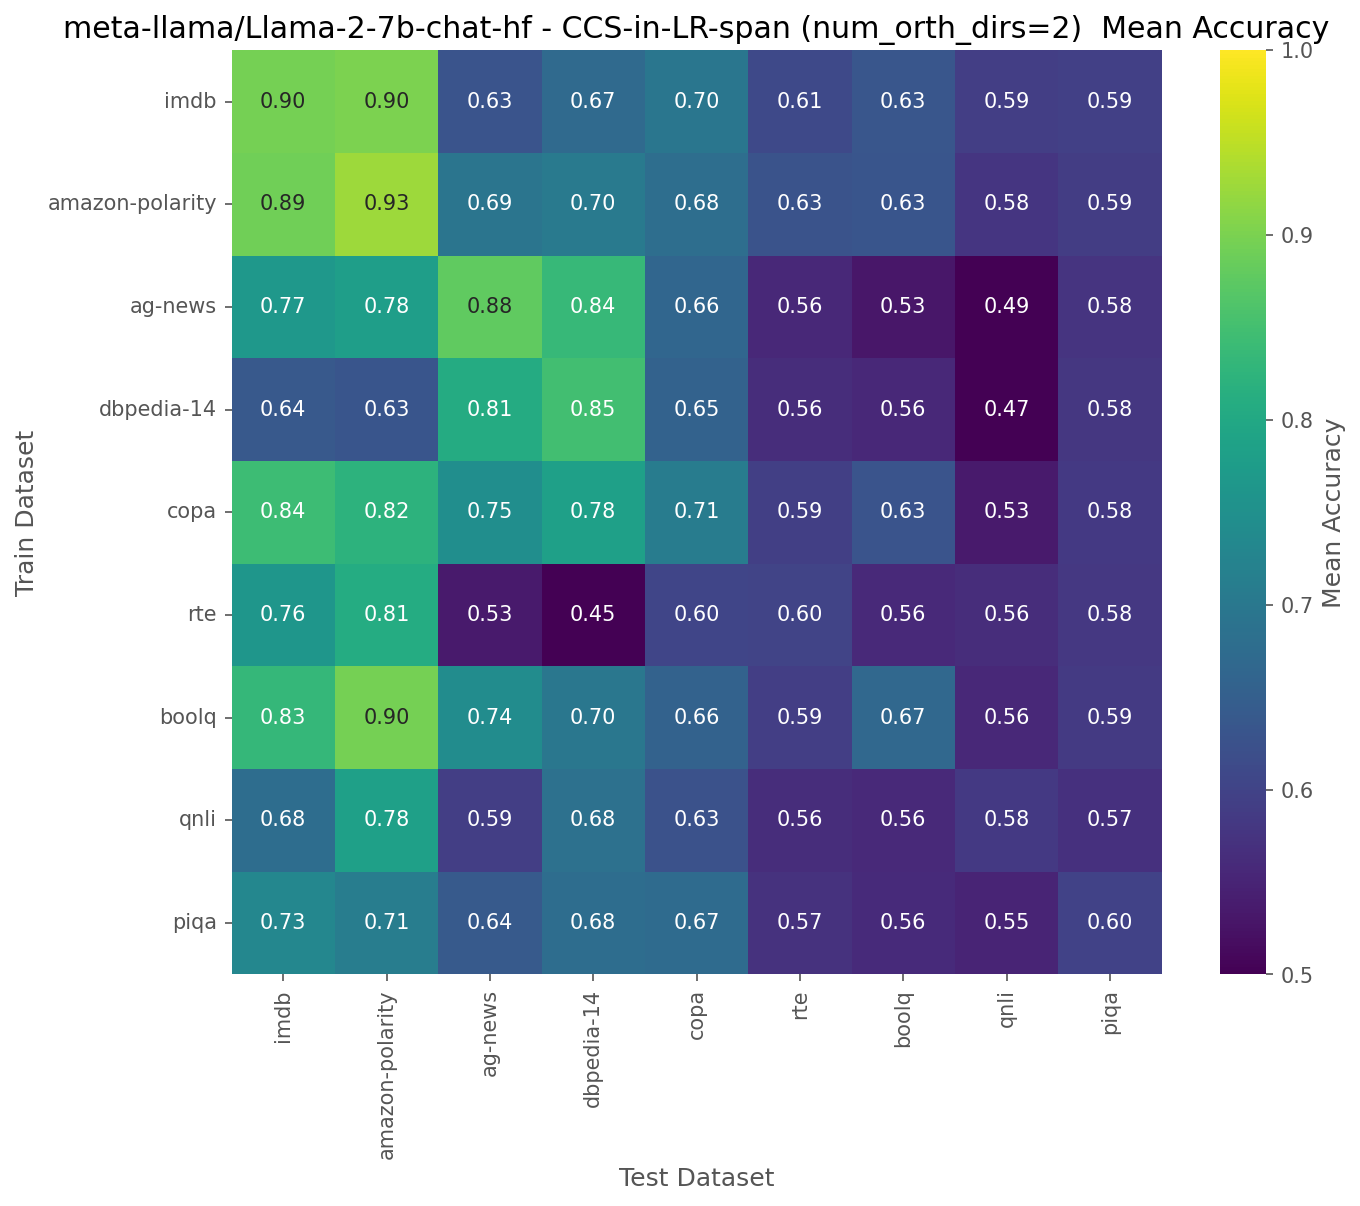

Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_4_orth_dirs
CCS-in-LR-span


/tmp/ipykernel_187416/2636079136.py:61: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for num_orthogonal_directions, df in group_keys_dfs:
/tmp/ipykernel_187416/2636079136.py:85: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_mean = df.pivot(train_col, "test", "mean").reindex(
/tmp/ipykernel_187416/2636079136.py:88: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_std = df.pivot(train_col, "test", "std").reindex(


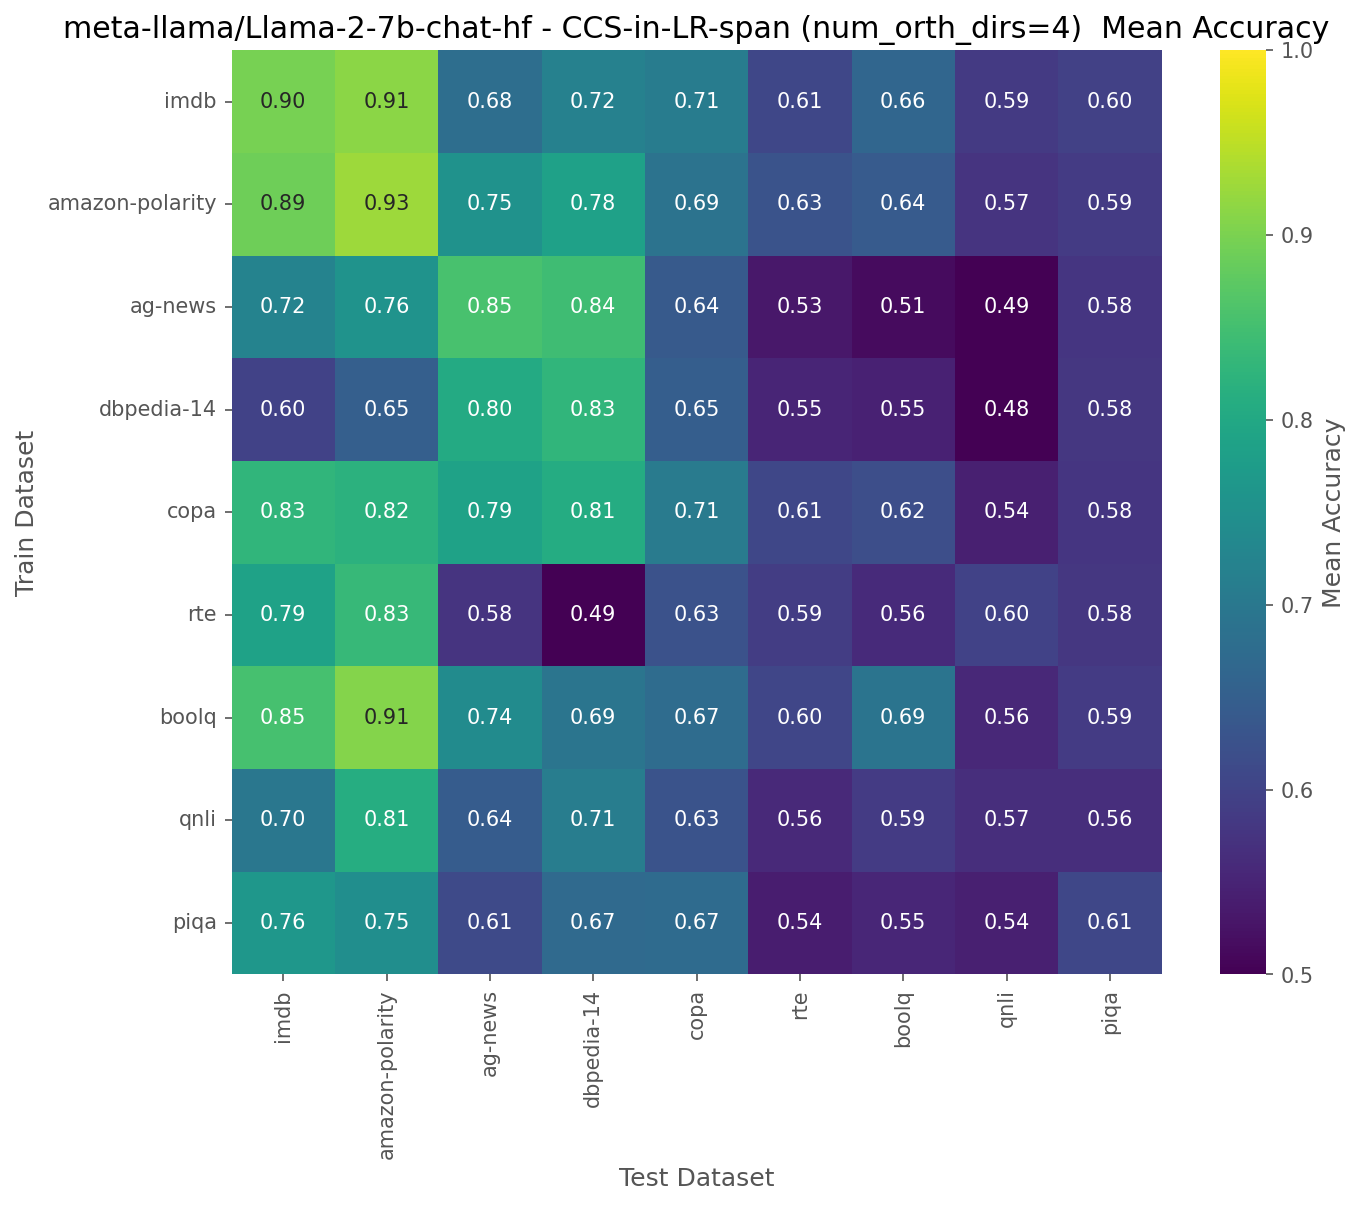

Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_8_orth_dirs
CCS-in-LR-span


/tmp/ipykernel_187416/2636079136.py:61: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for num_orthogonal_directions, df in group_keys_dfs:
/tmp/ipykernel_187416/2636079136.py:85: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_mean = df.pivot(train_col, "test", "mean").reindex(
/tmp/ipykernel_187416/2636079136.py:88: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_std = df.pivot(train_col, "test", "std").reindex(


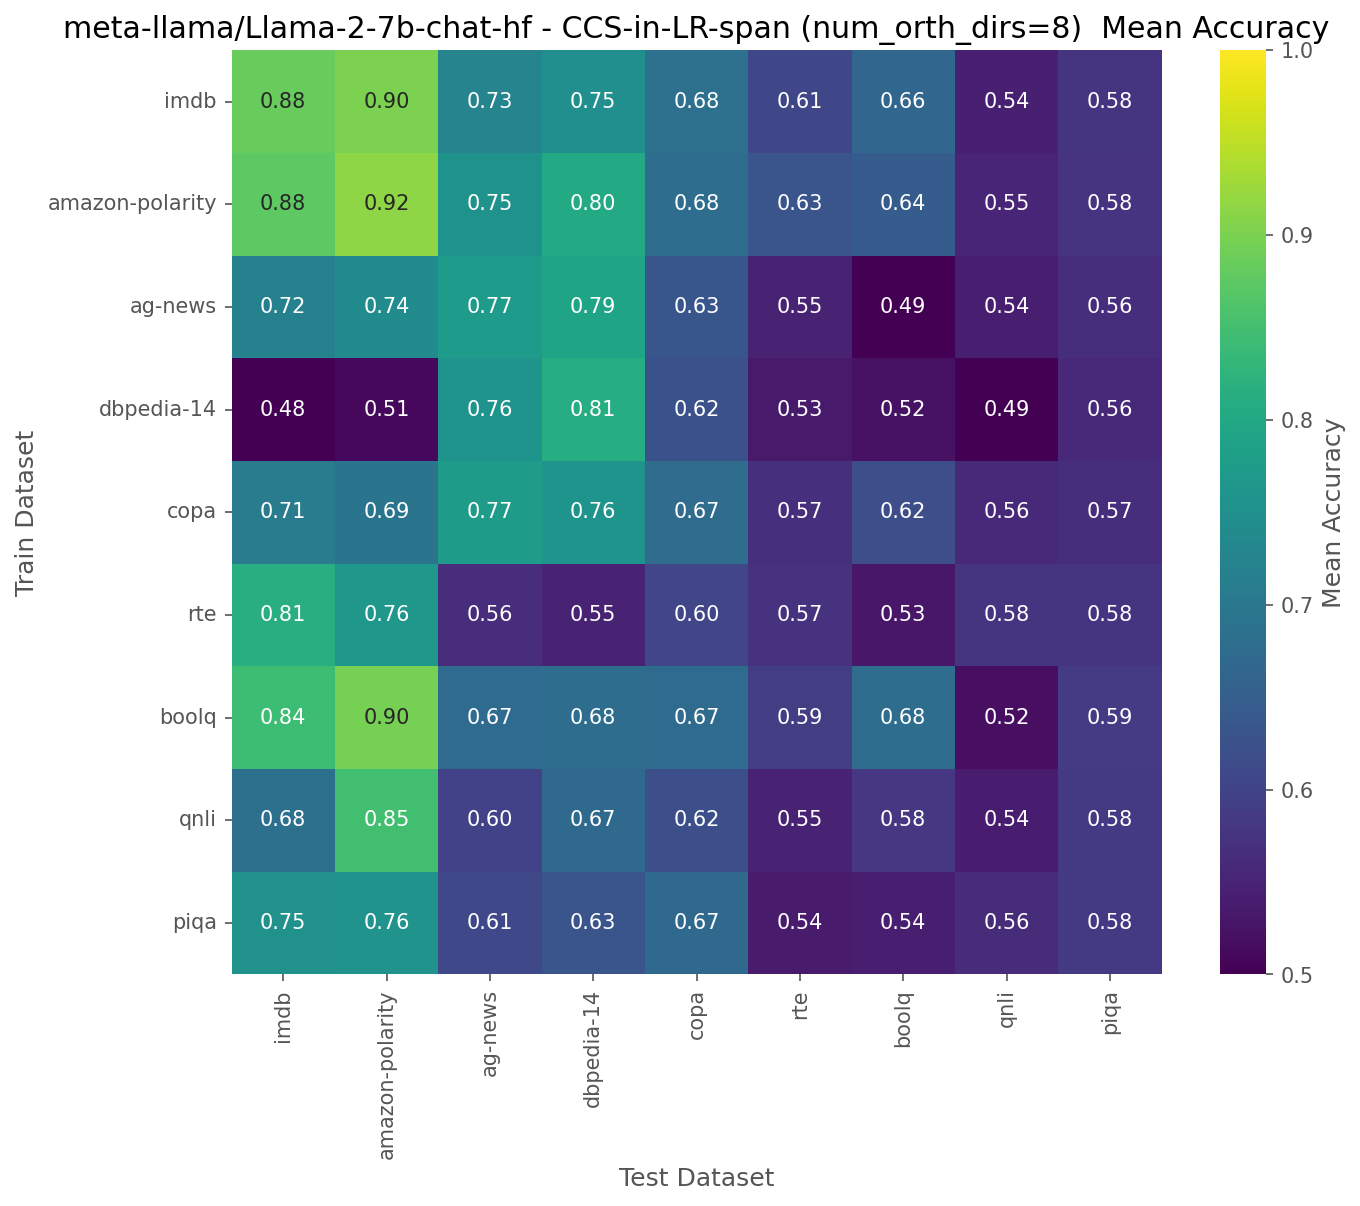

Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_10_orth_dirs
CCS-in-LR-span


/tmp/ipykernel_187416/2636079136.py:61: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for num_orthogonal_directions, df in group_keys_dfs:
/tmp/ipykernel_187416/2636079136.py:85: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_mean = df.pivot(train_col, "test", "mean").reindex(
/tmp/ipykernel_187416/2636079136.py:88: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_std = df.pivot(train_col, "test", "std").reindex(


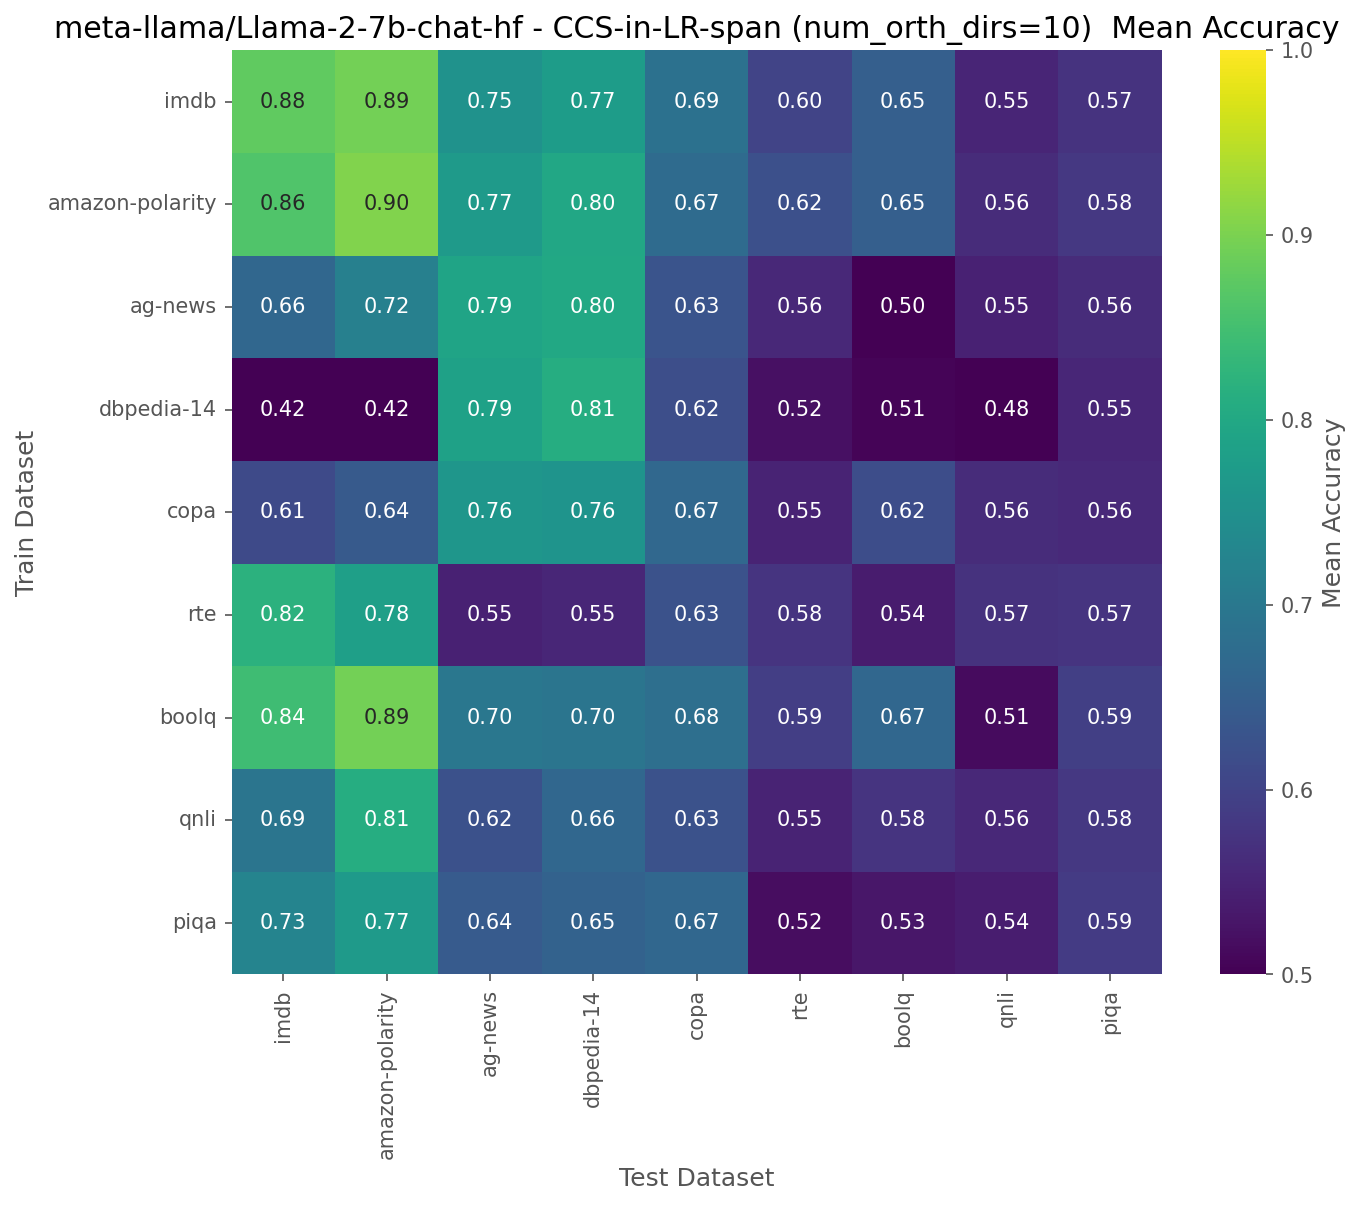

Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_15_orth_dirs
CCS-in-LR-span


/tmp/ipykernel_187416/2636079136.py:61: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for num_orthogonal_directions, df in group_keys_dfs:
/tmp/ipykernel_187416/2636079136.py:85: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_mean = df.pivot(train_col, "test", "mean").reindex(
/tmp/ipykernel_187416/2636079136.py:88: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_std = df.pivot(train_col, "test", "std").reindex(


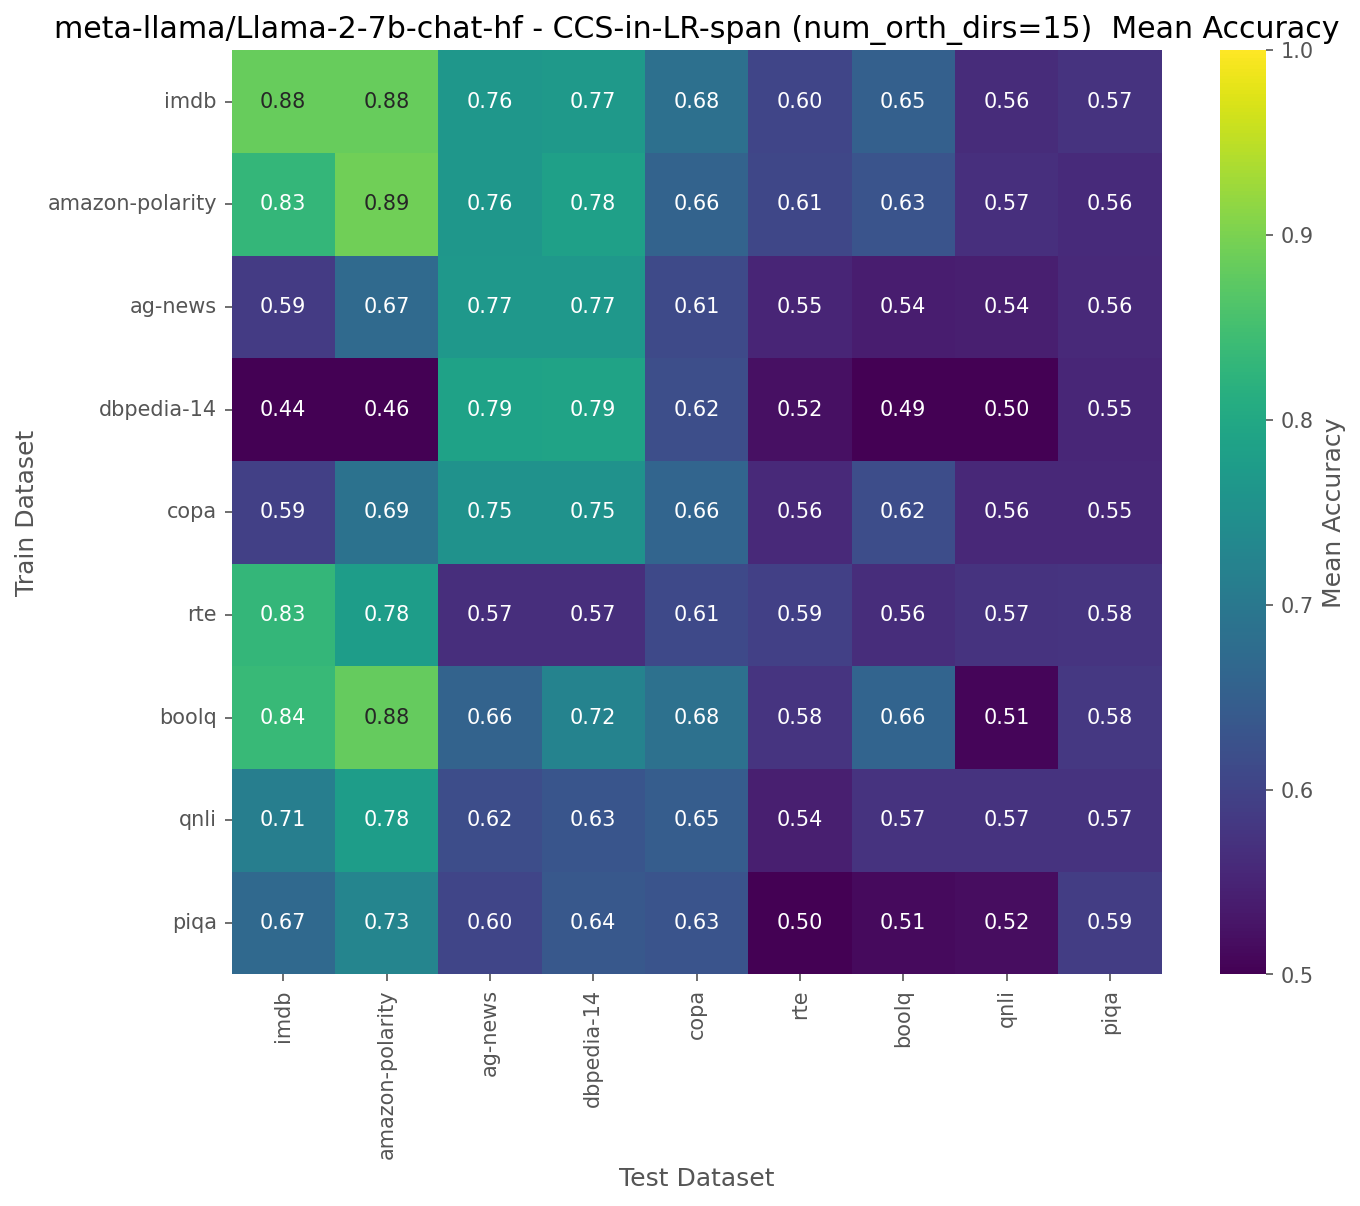

Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_20_orth_dirs
CCS-in-LR-span


/tmp/ipykernel_187416/2636079136.py:61: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for num_orthogonal_directions, df in group_keys_dfs:
/tmp/ipykernel_187416/2636079136.py:85: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_mean = df.pivot(train_col, "test", "mean").reindex(
/tmp/ipykernel_187416/2636079136.py:88: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_std = df.pivot(train_col, "test", "std").reindex(


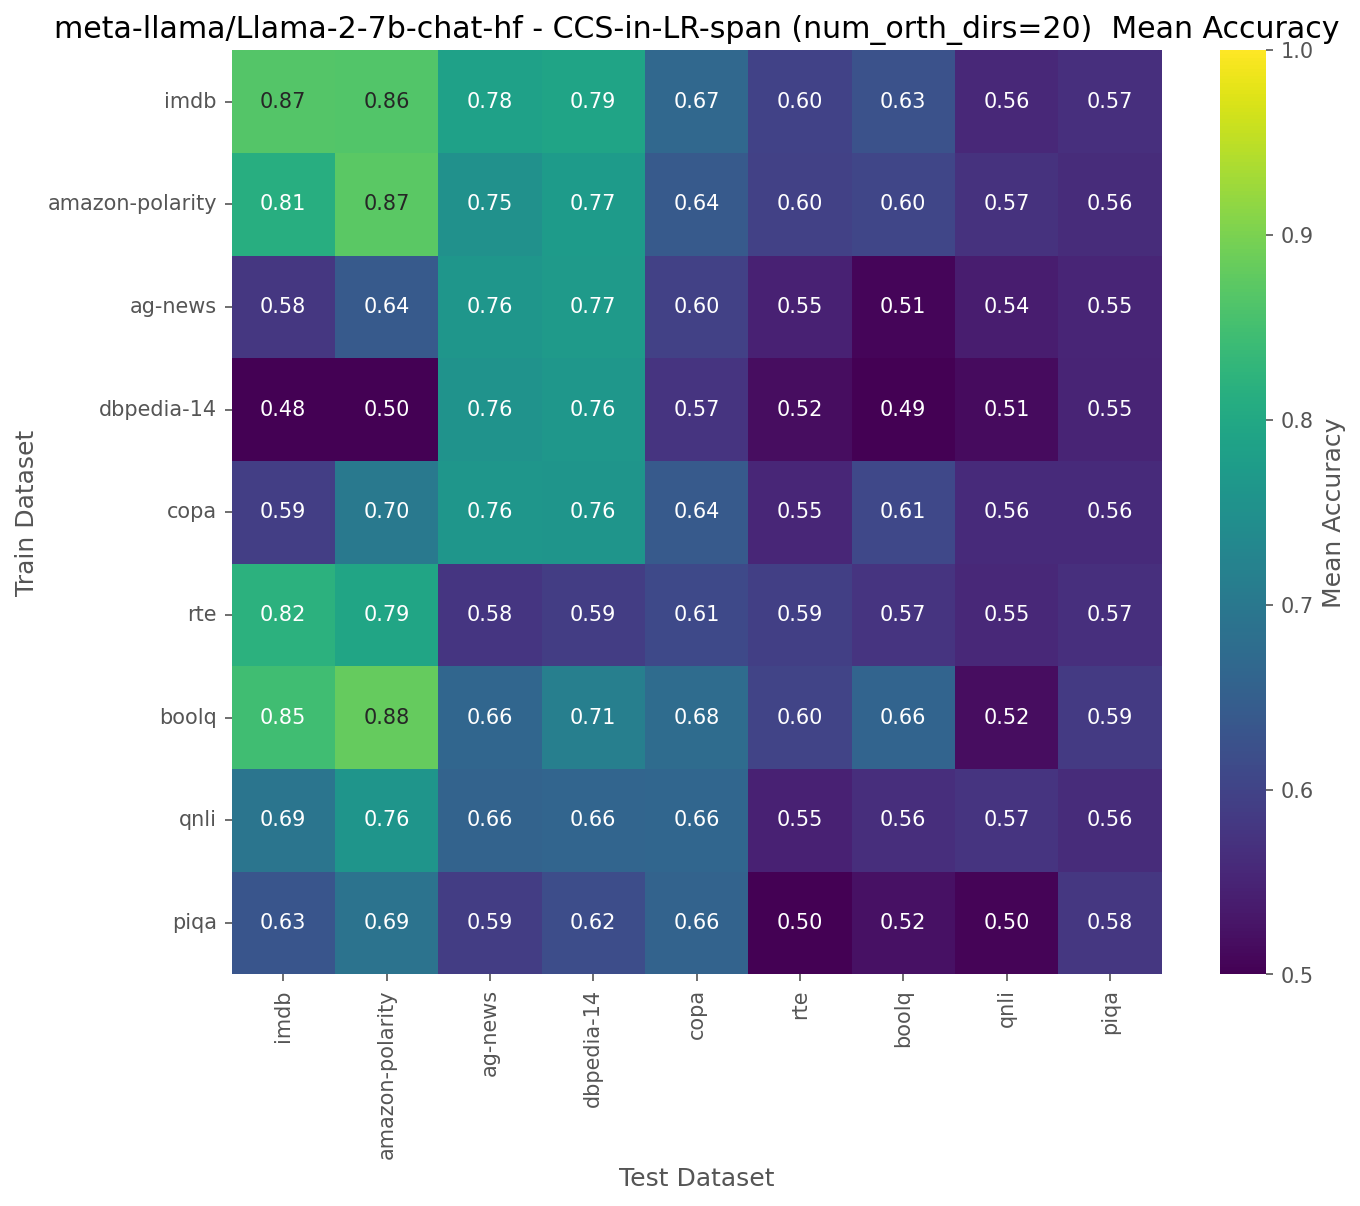

In [121]:
for exp_name, df in experiment_dfs.items():
    print(exp_name)
    df = filter_train_equals_test_per_method(df)
    heatmap_kwargs = {"vmin": 0.5, "vmax": 1}
    plot_heatmap(df, "accuracy", std_annot=False, heatmap_kwargs=heatmap_kwargs)

# Compare accuracies

In [158]:
exp_names_and_dfs = list(experiment_dfs.items())
exp1, df1 = exp_names_and_dfs[0]
df1_method = df1.method.unique()
if len(df1_method) > 1:
    raise ValueError(f"Expected one unique method, got {df1_method}")
train_col1 = (
    "train_labeled"
    if method_uses_labeled_and_unlabeled_data(df1_method[0])
    else "train"
)

for exp2, df2 in exp_names_and_dfs:
    df2_method = df2.method.unique()
    if len(df2_method) > 1:
        raise ValueError(f"Expected one unique method, got {df2_method}")

    train_col2 = (
        "train_labeled"
        if method_uses_labeled_and_unlabeled_data(df2_method[0])
        else "train"
    )
    comparison = compare_accuracies(df1, df2, train_col1, train_col2)
    print(f"Comparison between {exp1} and {exp2}:")
    pprint.pprint(comparison)
    print()

Comparison between Llama-2-7b-chat-hf_normal_LR-C=0.01-max_iter=10k-penalty=l2 and Llama-2-7b-chat-hf_normal_LR-C=0.01-max_iter=10k-penalty=l2:
{'frac_acc1_better': 0.0,
 'frac_acc1_better_in_domain': 0.0,
 'frac_acc1_better_ood': 0.0,
 'high_acc_frac_acc1_better': 0.0,
 'high_acc_frac_acc1_better_in_domain': 0.0,
 'high_acc_frac_acc1_better_ood': 0.0}

Comparison between Llama-2-7b-chat-hf_normal_LR-C=0.01-max_iter=10k-penalty=l2 and Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_2_orth_dirs:
{'frac_acc1_better': 0.8024691358024691,
 'frac_acc1_better_in_domain': 1.0,
 'frac_acc1_better_ood': 0.7777777777777778,
 'high_acc_frac_acc1_better': 0.918918918918919,
 'high_acc_frac_acc1_better_in_domain': 1.0,
 'high_acc_frac_acc1_better_ood': 0.896551724137931}

Comparison between Llama-2-7b-chat-hf_normal_LR-C=0.01-max_iter=10k-penalty=l2 and Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_4_orth_dirs:
{'frac_acc1_better': 0.7407407407407407,
 'frac_acc1_better_in_domain': 1.0,
 'frac_ac

/tmp/ipykernel_187416/1990164313.py:453: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_mean = df.pivot(train_col, "test", "mean").reindex(
/tmp/ipykernel_187416/1990164313.py:456: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_std = df.pivot(train_col, "test", "std").reindex(
/tmp/ipykernel_187416/1990164313.py:453: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_mean = df.pivot(train_col, "test", "mean").reindex(
/tmp/ipykernel_187416/1990164313.py:456: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_std = df.pivot(train_col, "test", "std").reindex(
/tmp/ipykernel_187416/1990164313.py:453: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_mean = df.pivot(train

In [146]:
method_uses_labeled_and_unlabeled_data(df1.method.unique()[0])

False

# Accuracy violin plots

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=3-unsup_weight=1-lr=1e-2-n_epochs=1000


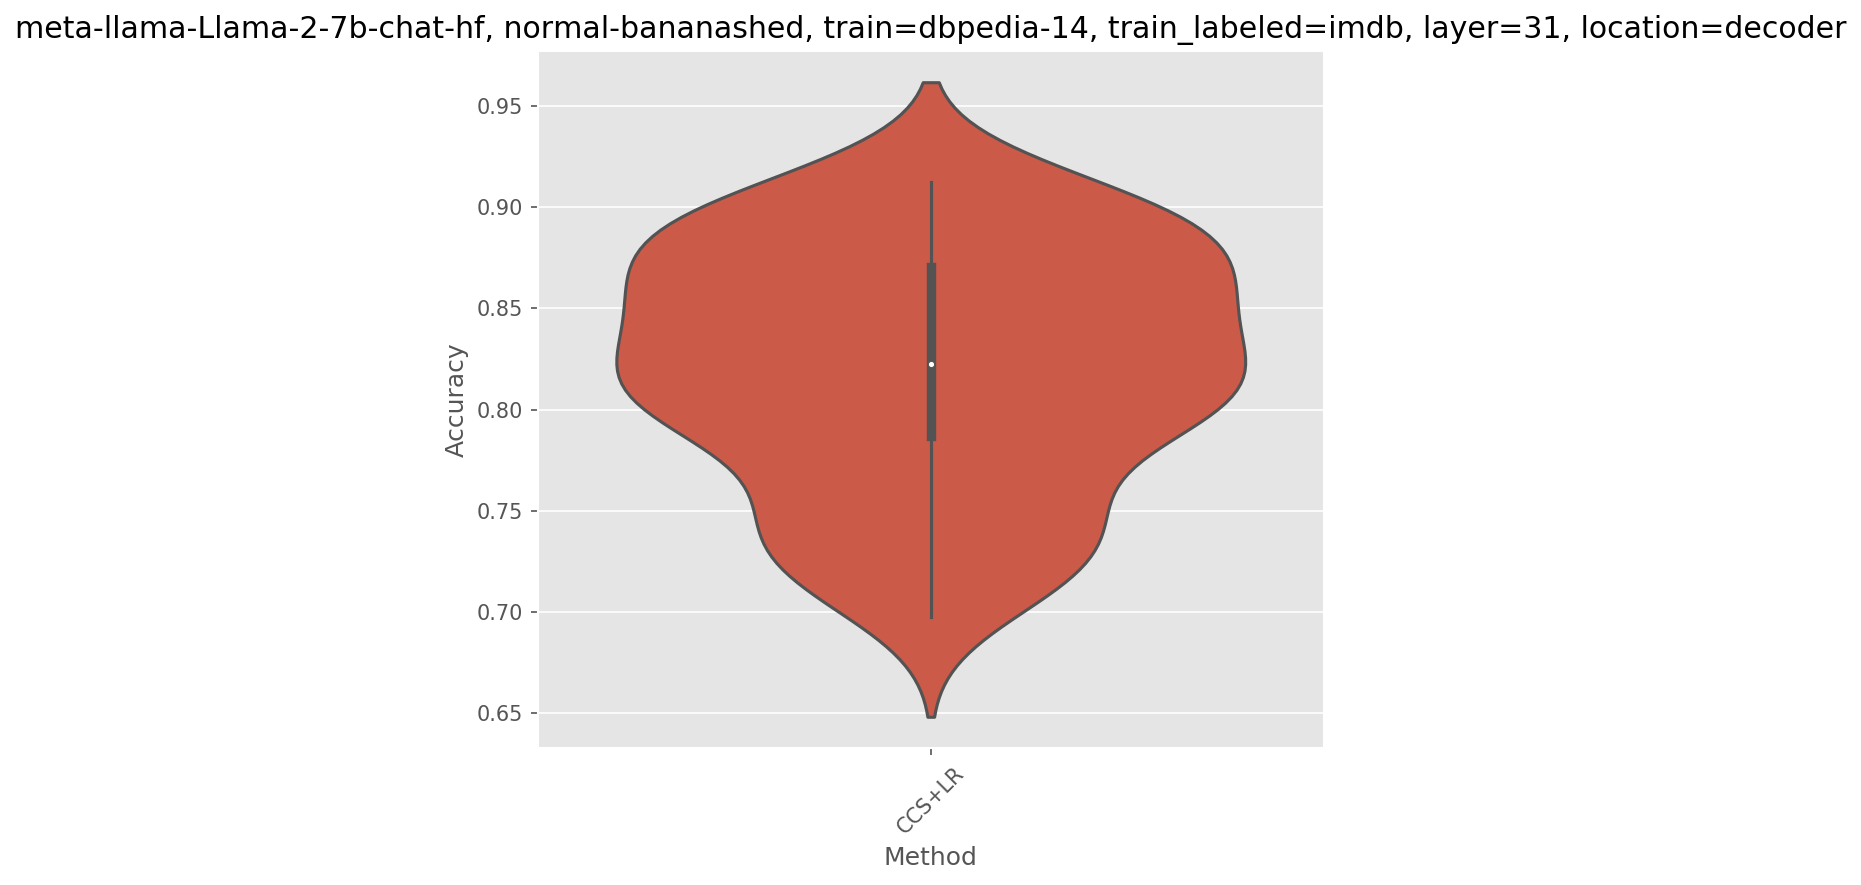

In [159]:
for exp_name, df in experiment_dfs.items():
    print(exp_name)
    plot_violin(df)

# Training curves

In [142]:
import json

path = "/scratch/users/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=3-unsup_weight=1-lr=1e-2-n_epochs=1000/meta-llama-Llama-2-7b-chat-hf/nolabel_dbpedia-14-label_imdb/seed_0/1/train/fit_result_CCS+LR.json"

with open(path, "r") as f:
    fit_result = json.load(f)

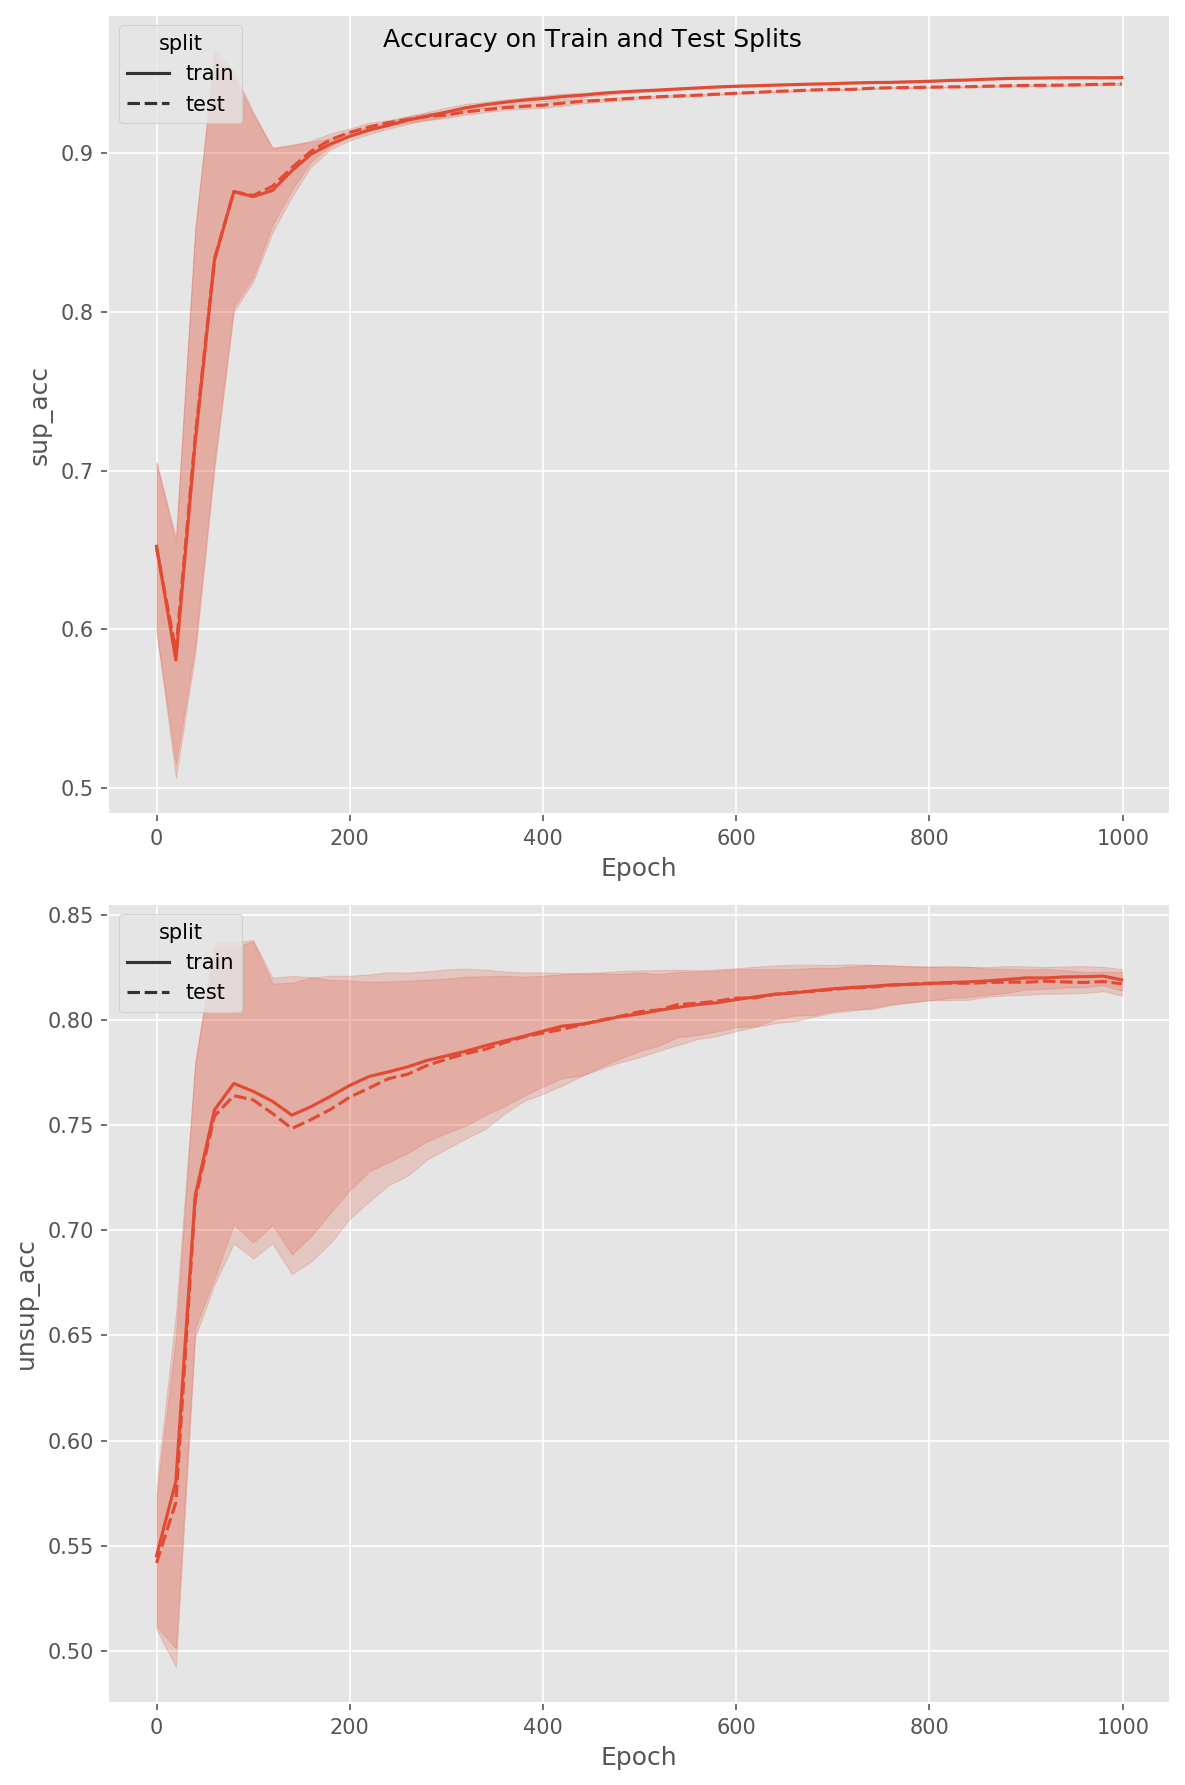

In [143]:
plot_df = plot_utils.plot_accuracy(fit_result)

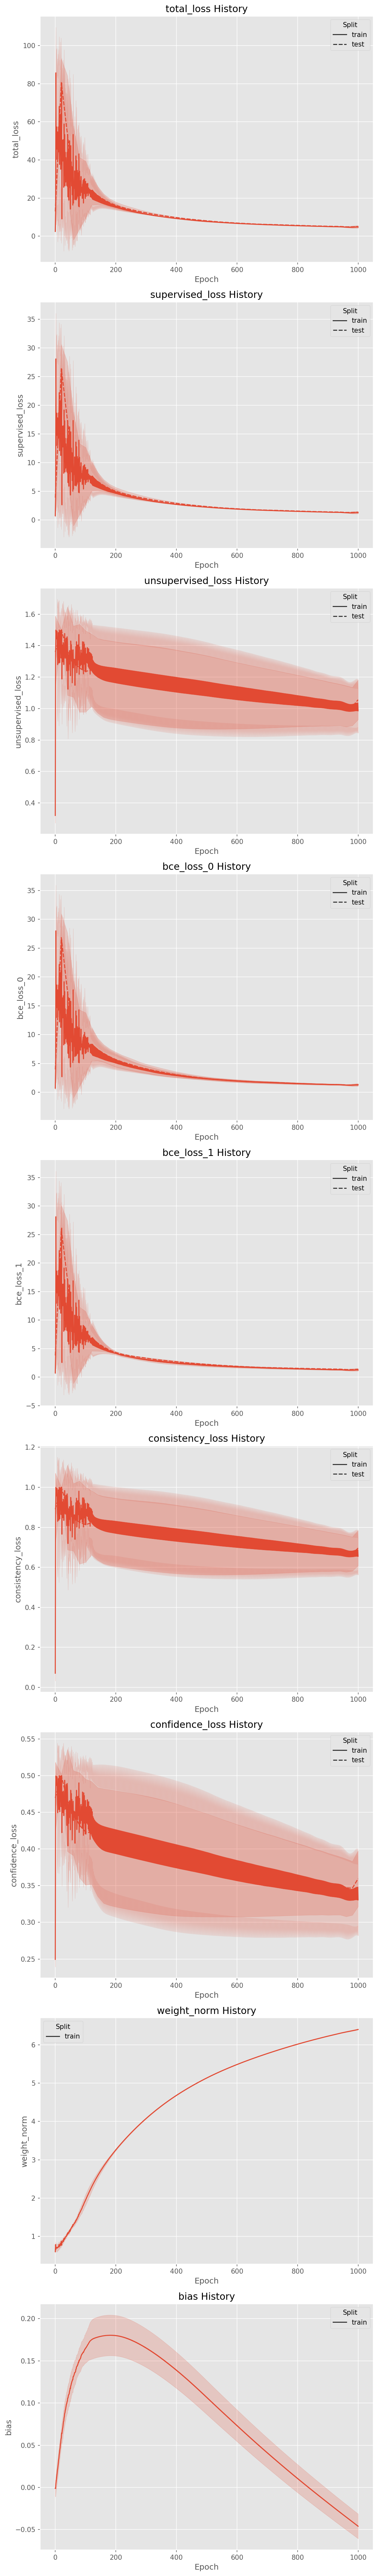

In [144]:
plot_utils.plot_history(fit_result)

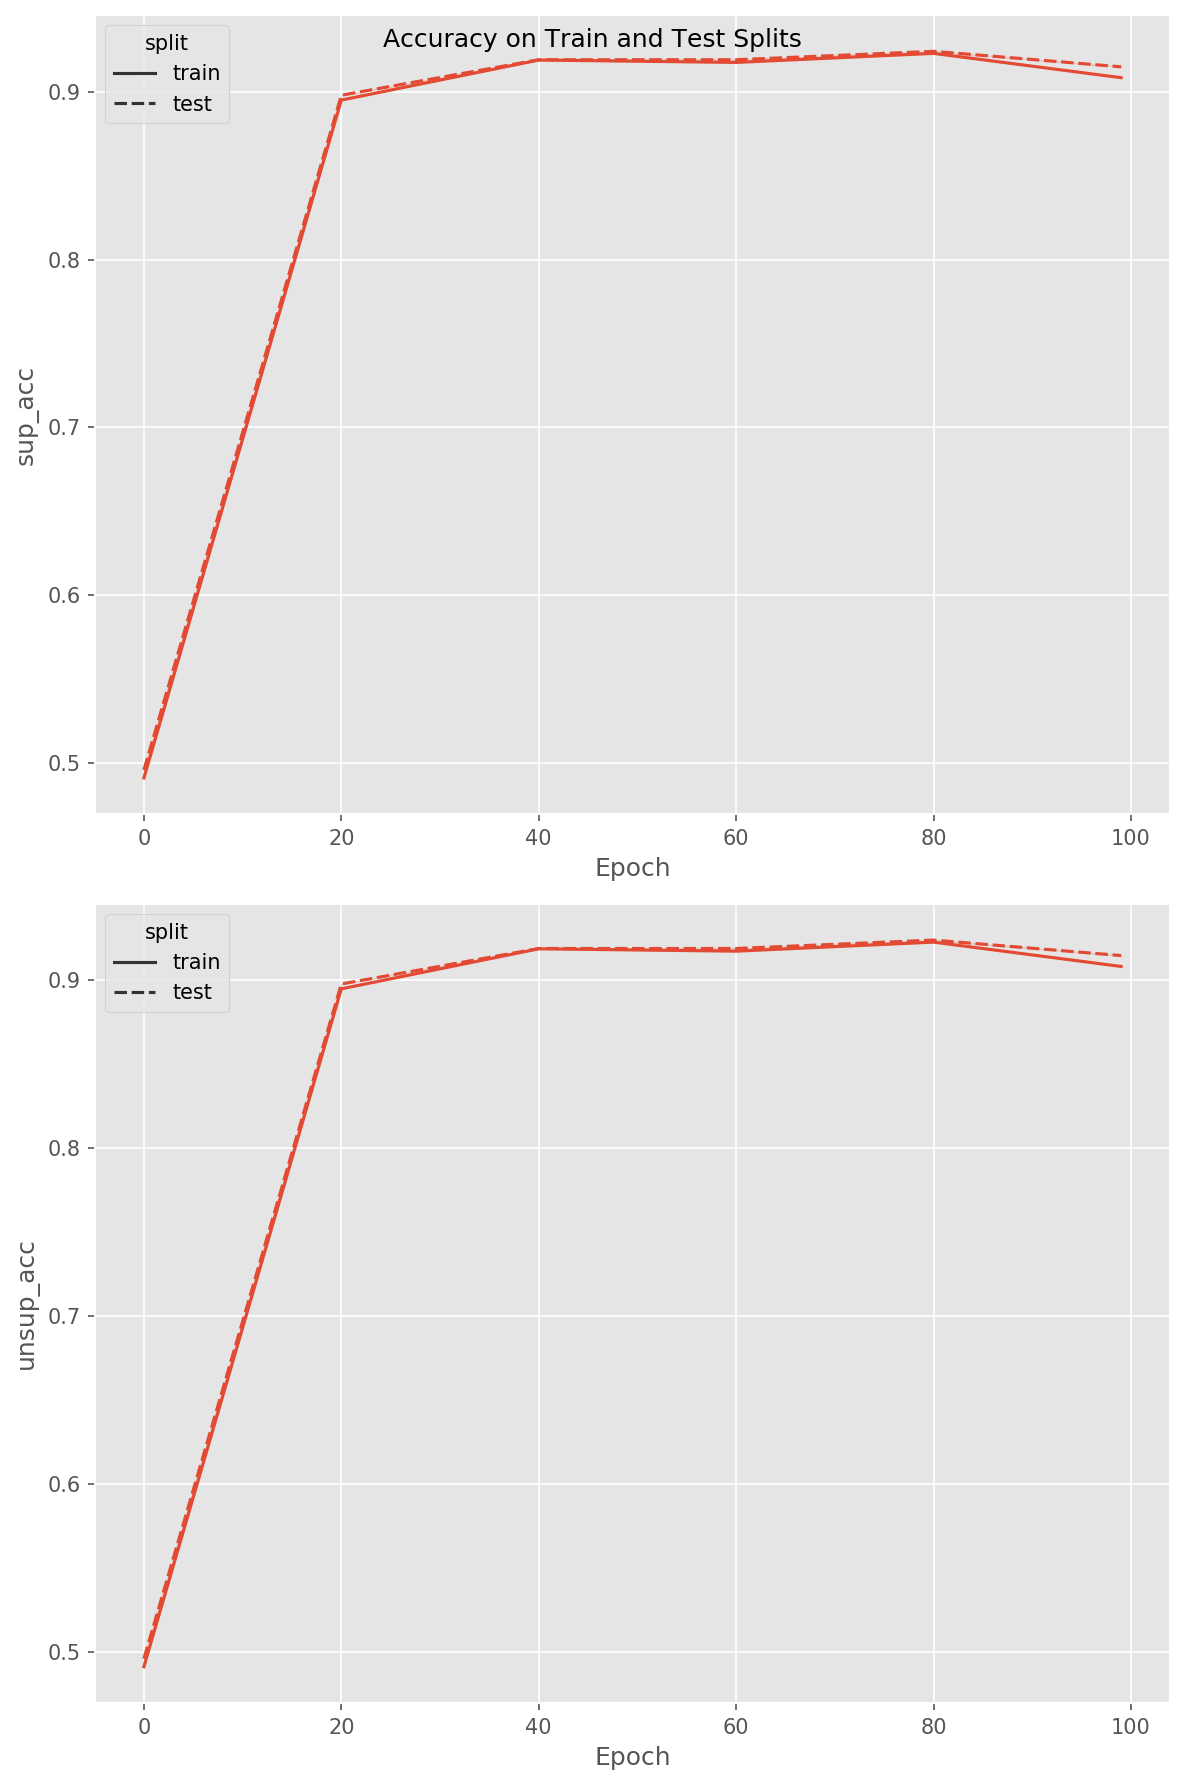

In [77]:
def plot_accuracy(fit_result, save_path=None):
    eval_histories = fit_result["eval_histories"]
    data = []

    for trial, history in enumerate(eval_histories):
        epochs = history["epoch"]
        for split in ["train", "test"]:
            for acc_dataset in ["sup_acc", "unsup_acc"]:
                acc_name = f"{split}_{acc_dataset}"
                acc_list = history[acc_name]
                for epoch, acc_val in zip(epochs, acc_list):
                    data.append(
                        {
                            "trial": trial,
                            "split": split,
                            "type": acc_dataset,
                            "epoch": epoch,
                            "accuracy": acc_val,
                        }
                    )
    df = pd.DataFrame(data)

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(8, 12))
    for ax, acc_dataset in zip(axs, ["sup_acc", "unsup_acc"]):
        sns.lineplot(
            data=df,
            x="epoch",
            y="accuracy",
            style="split",
            ci="sd",
            markers=False,
            dashes=True,
            ax=ax,
        )
        ax.set_xlabel("Epoch")
        ax.set_ylabel(acc_dataset)

    fig.suptitle("Accuracy on Train and Test Splits")
    plt.tight_layout()

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()


plot_accuracy(fit_result)

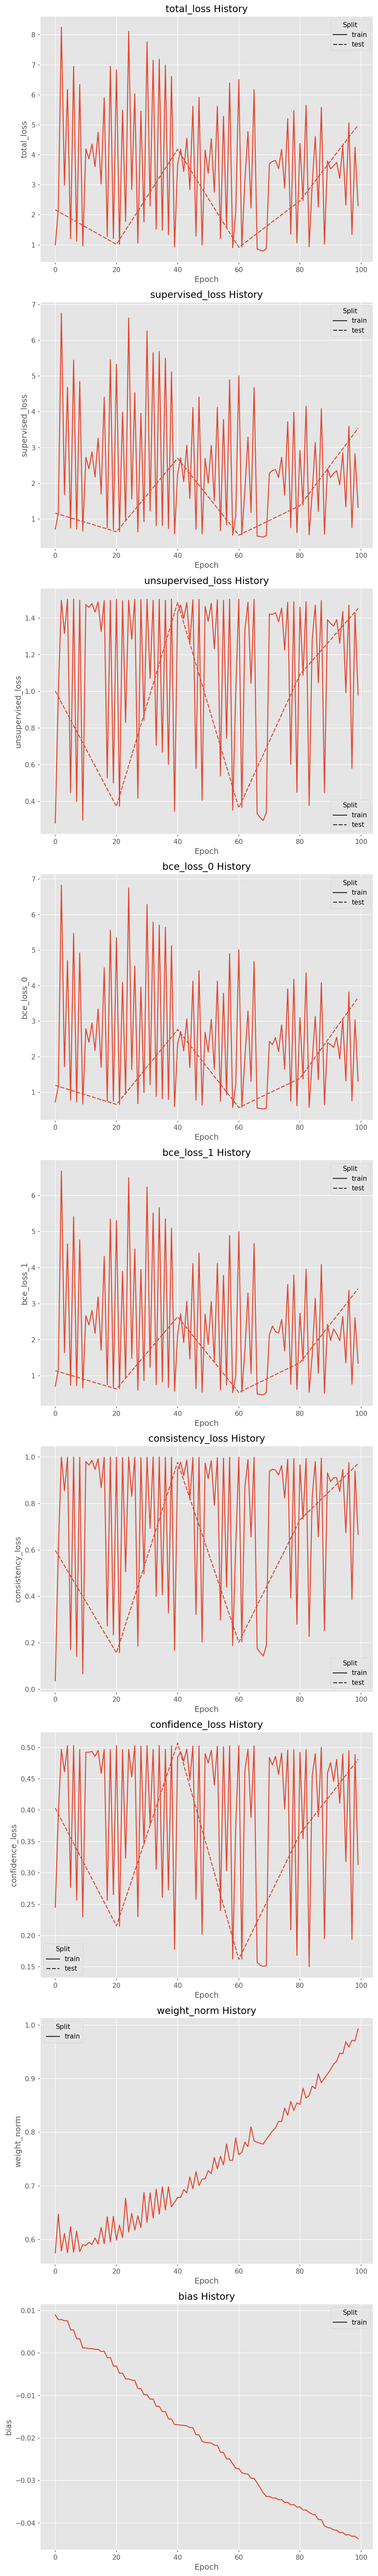

In [74]:
def plot_history(
    fit_result, vars_to_plot=None, one_fig=False, save_path=None, logger=None
):
    if not fit_result["train_histories"] and logger is not None:
        logger.info("No train_histories found in fit_result")

    if vars_to_plot is None:
        vars_to_plot = fit_result["train_histories"][0].keys()
    else:
        if not all(
            var_name in fit_result["train_histories"][0] for var_name in vars_to_plot
        ):
            raise ValueError(
                f"vars_to_plot contains unknown variable names: {vars_to_plot}"
            )

    # Prepare the data for plotting
    data = []
    for var_name in vars_to_plot:
        for split, histories in zip(
            ["train", "test"],
            [fit_result["train_histories"], fit_result["eval_histories"]],
        ):
            for trial, history in enumerate(histories):
                var_history = history.get(var_name, [])
                if "epoch" in history:
                    epochs = history["epoch"]
                else:
                    epochs = range(len(var_history))
                for epoch, value in zip(epochs, var_history):
                    data.append(
                        {
                            "Epoch": epoch,
                            "Value": value,
                            "Type": var_name,
                            "Trial": trial,
                            "Split": split,
                        }
                    )

    df = pd.DataFrame(data)

    # Plot
    nrows = 1 if one_fig else len(vars_to_plot)
    fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows * 6))

    if one_fig:
        sns.lineplot(
            data=df,
            x="Epoch",
            y="Value",
            hue="Type",
            style="Split",
            ci="sd",
            markers=False,
            dashes=True,
            ax=axs,
        )
        axs.set_title("History with Confidence Interval")
        axs.set_xlabel("Epoch")
        axs.legend(title="Value")
    else:
        if nrows == 1:
            axs = [axs]

        for ax, var_name in zip(axs, vars_to_plot):
            sns.lineplot(
                data=df[df["Type"] == var_name],
                x="Epoch",
                y="Value",
                style="Split",
                ci="sd",
                markers=False,
                dashes=True,
                ax=ax,
            )
            ax.set_title(f"{var_name} History")
            ax.set_xlabel("Epoch")
            ax.set_ylabel(var_name)

    plt.tight_layout()

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()

    return df


plot_df = plot_history(
    fit_result,
    # vars_to_plot=["total_loss", "supervised_loss"],
    one_fig=False,
)

In [55]:
plot_df

Epoch     Value             Type  Trial  Split
0        0  0.721262       total_loss      0  train
1        1  0.741357       total_loss      0  train
2        2  1.159783       total_loss      0  train
3        3  2.888847       total_loss      0  train
4        4  2.161690       total_loss      0  train
..     ...       ...              ...    ...    ...
207     20  2.314981  supervised_loss      0   test
208     40  2.076926  supervised_loss      0   test
209     60  1.893125  supervised_loss      0   test
210     80  1.738899  supervised_loss      0   test
211     99  1.618677  supervised_loss      0   test

[212 rows x 5 columns]

In [56]:
plot_df.query("Type == 'total_loss' and Split == 'test'")

Epoch     Value        Type  Trial Split
100      0  0.740589  total_loss      0  test
101     20  2.314981  total_loss      0  test
102     40  2.076926  total_loss      0  test
103     60  1.893125  total_loss      0  test
104     80  1.738899  total_loss      0  test
105     99  1.618677  total_loss      0  test

In [59]:
plot_df

Epoch     Value             Type  Trial  Split
0        0  0.721262       total_loss      0  train
1        1  0.741357       total_loss      0  train
2        2  1.159783       total_loss      0  train
3        3  2.888847       total_loss      0  train
4        4  2.161690       total_loss      0  train
..     ...       ...              ...    ...    ...
207     20  2.314981  supervised_loss      0   test
208     40  2.076926  supervised_loss      0   test
209     60  1.893125  supervised_loss      0   test
210     80  1.738899  supervised_loss      0   test
211     99  1.618677  supervised_loss      0   test

[212 rows x 5 columns]

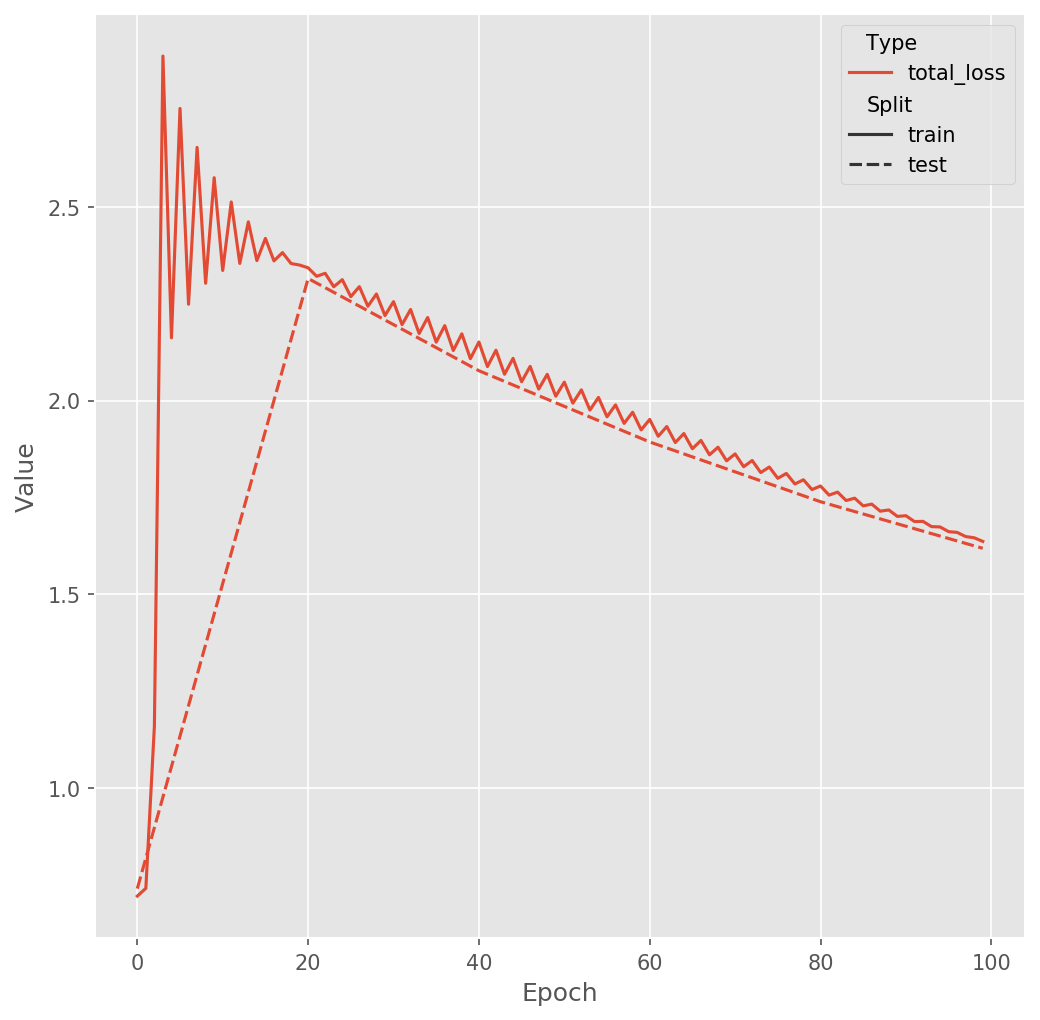

In [66]:
sns.lineplot(
    data=plot_df.query("Type == 'total_loss'"),
    x="Epoch",
    y="Value",
    hue="Type",
    style="Split",
    ci="sd",
    markers=False,
    dashes=True,
)

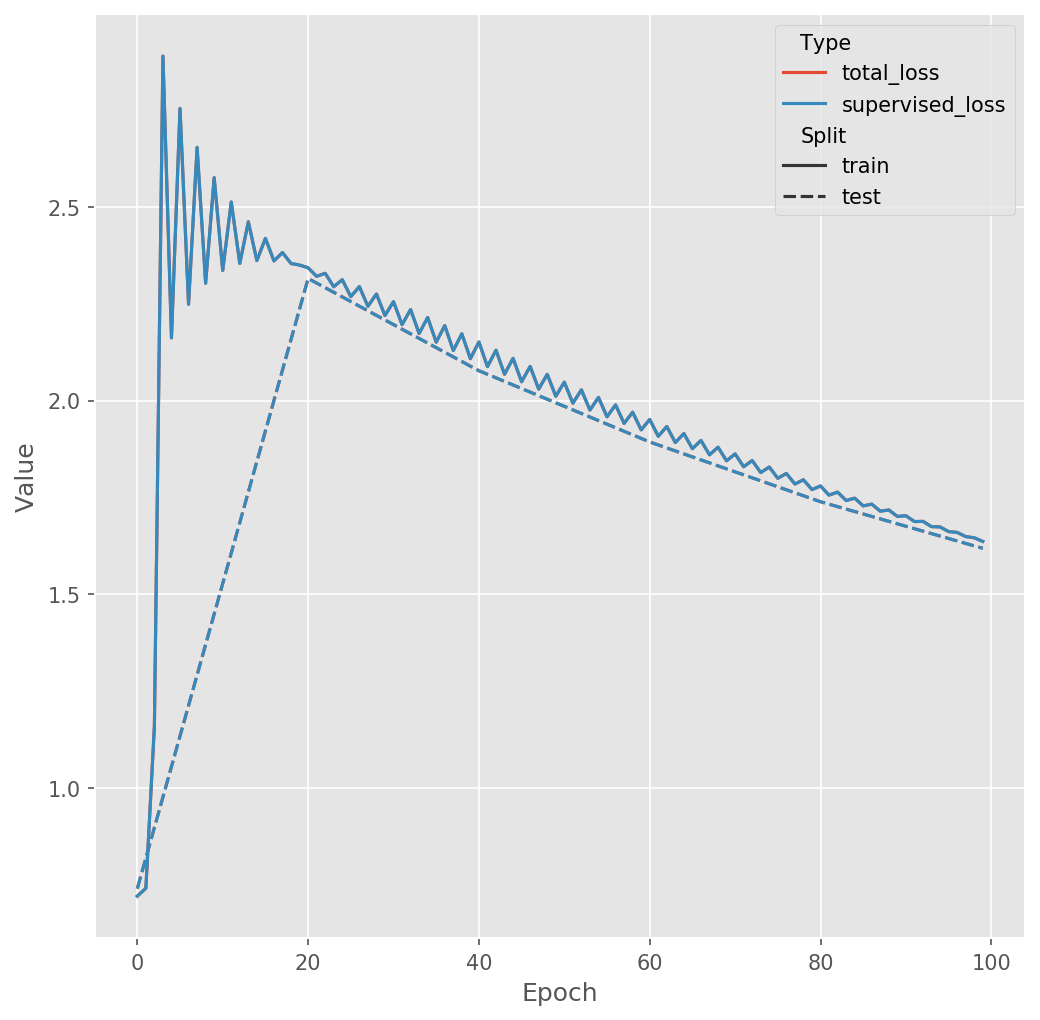

In [65]:
sns.lineplot(
    data=plot_df,
    x="Epoch",
    y="Value",
    hue="Type",
    style="Split",
    ci="sd",
    markers=False,
    dashes=True,
)

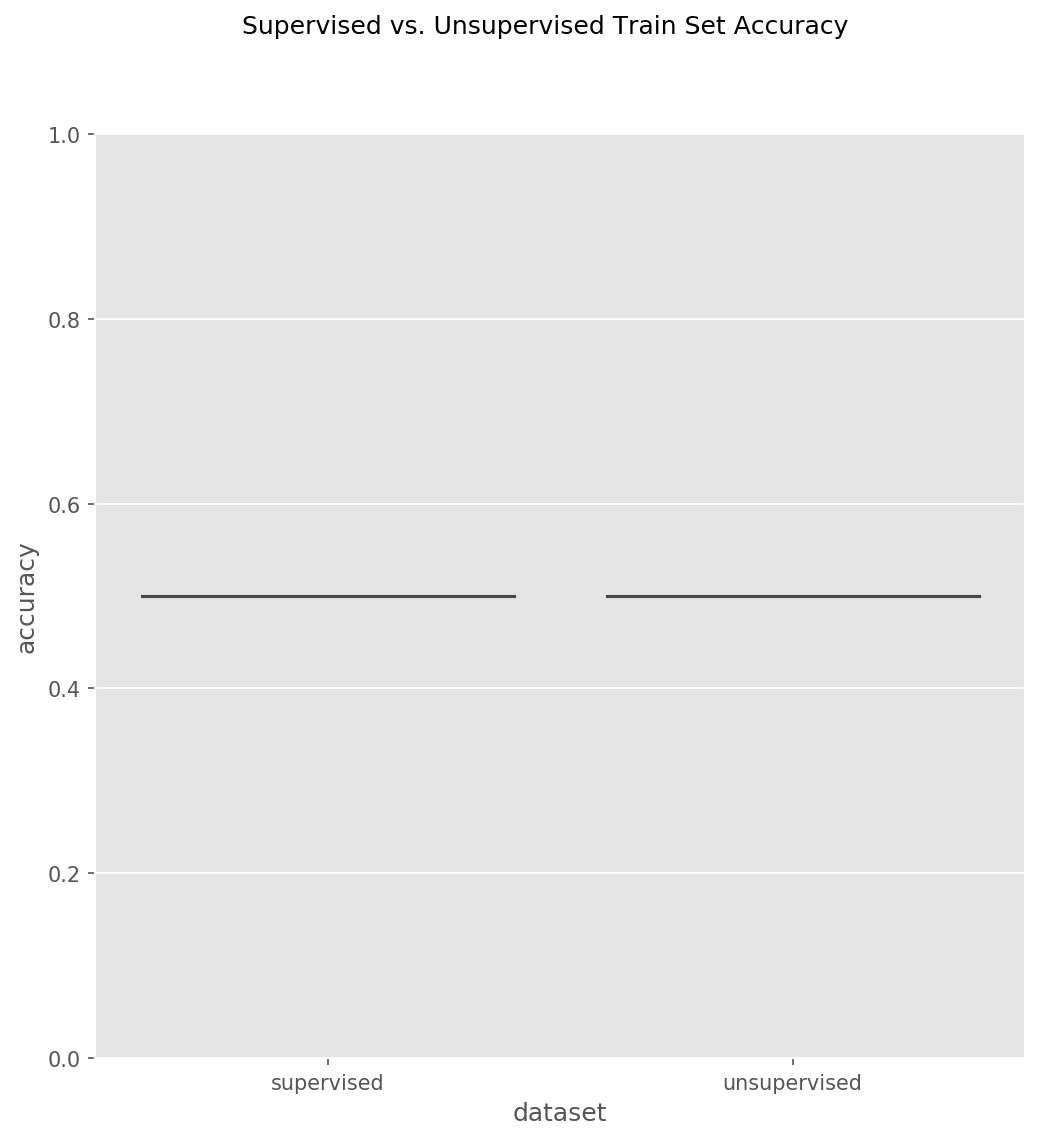

In [31]:
plot_utils.plot_accuracy(fit_result)

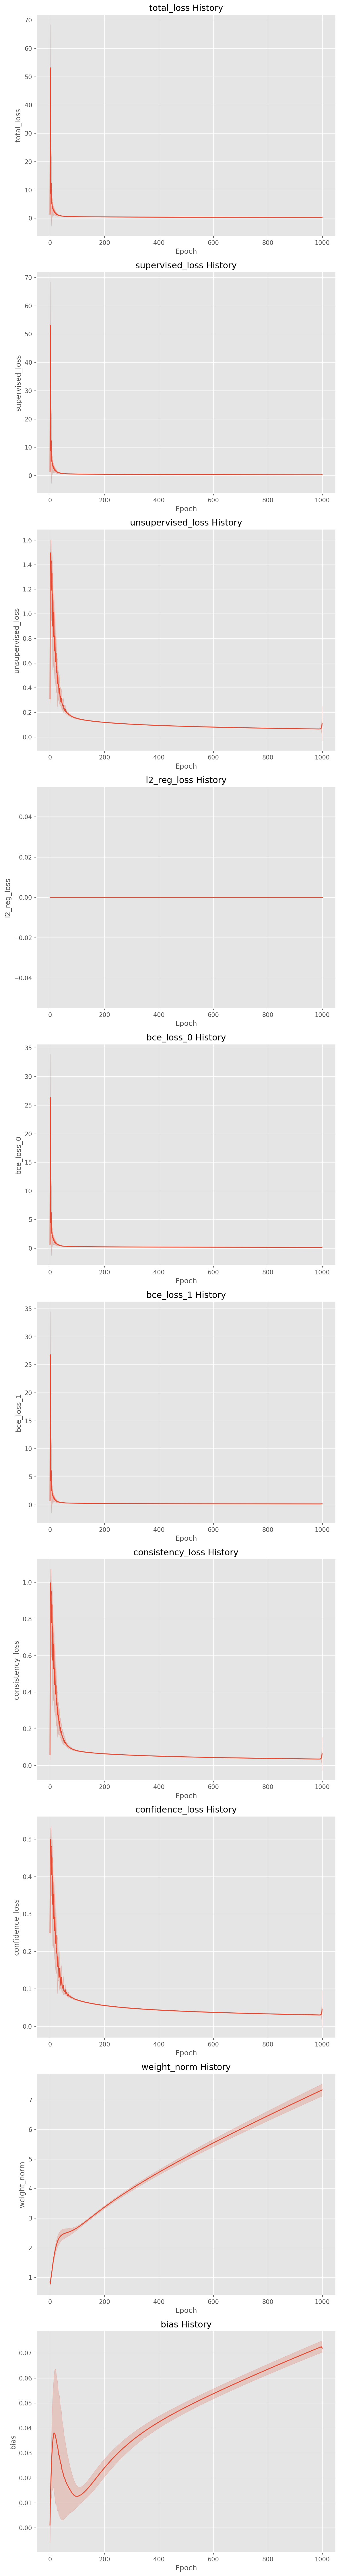

In [14]:
plot_utils.plot_history(fit_result, one_fig=False)

# ECE

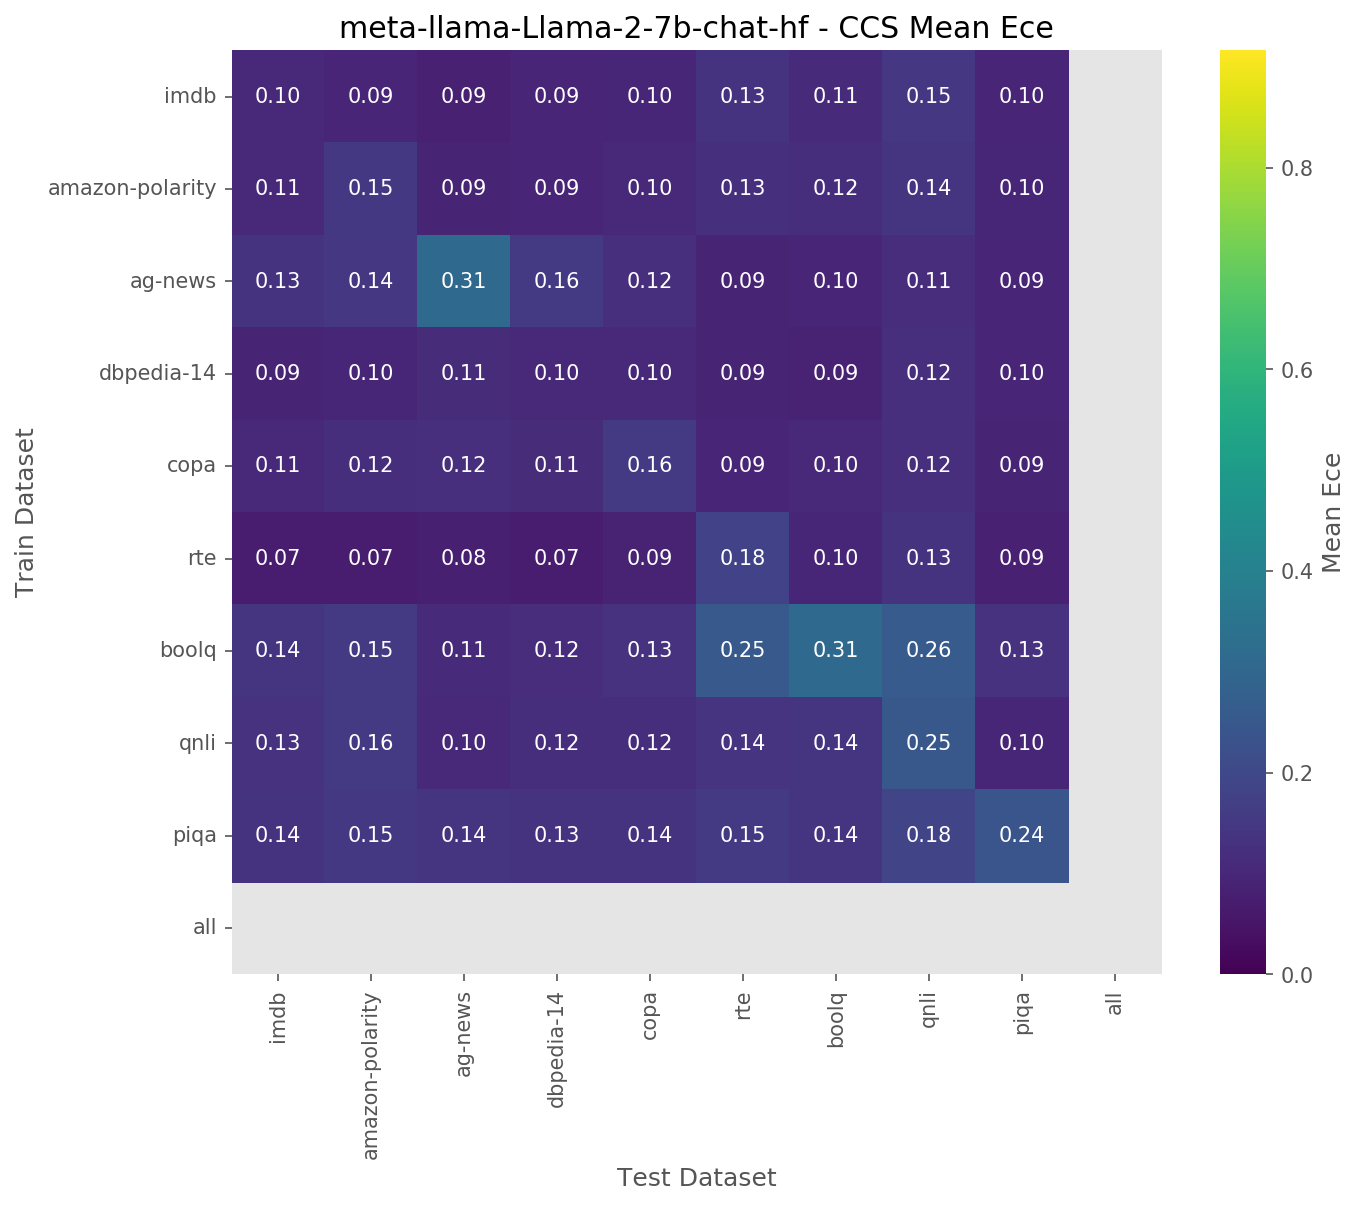

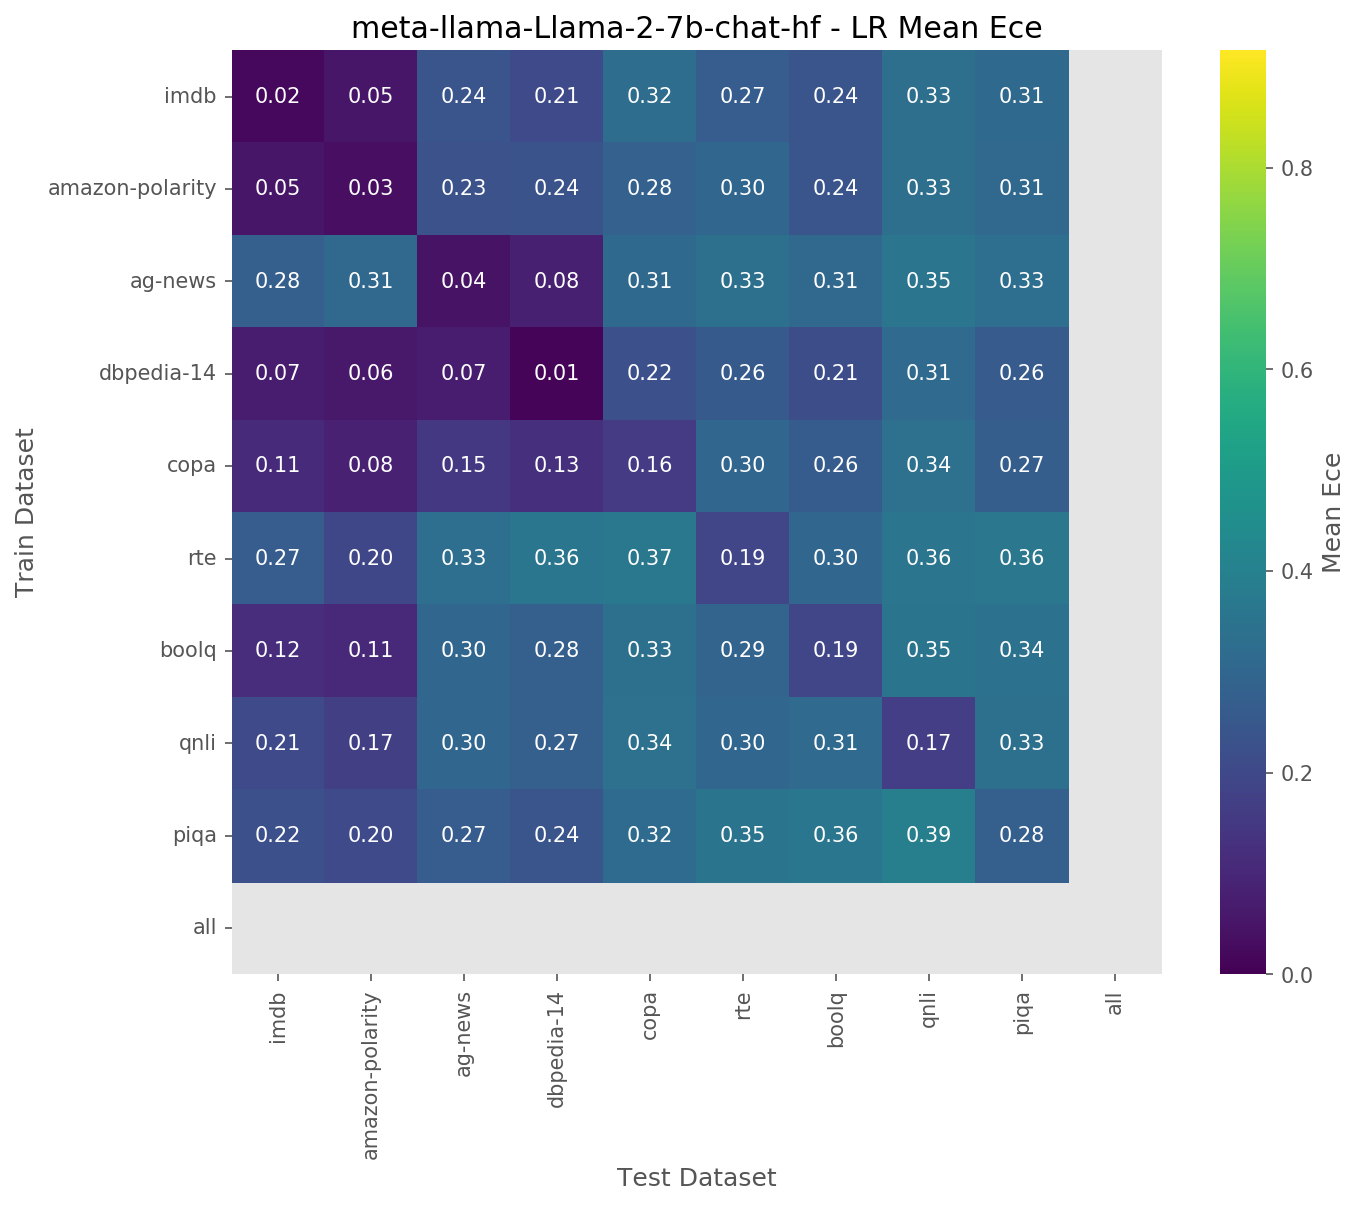

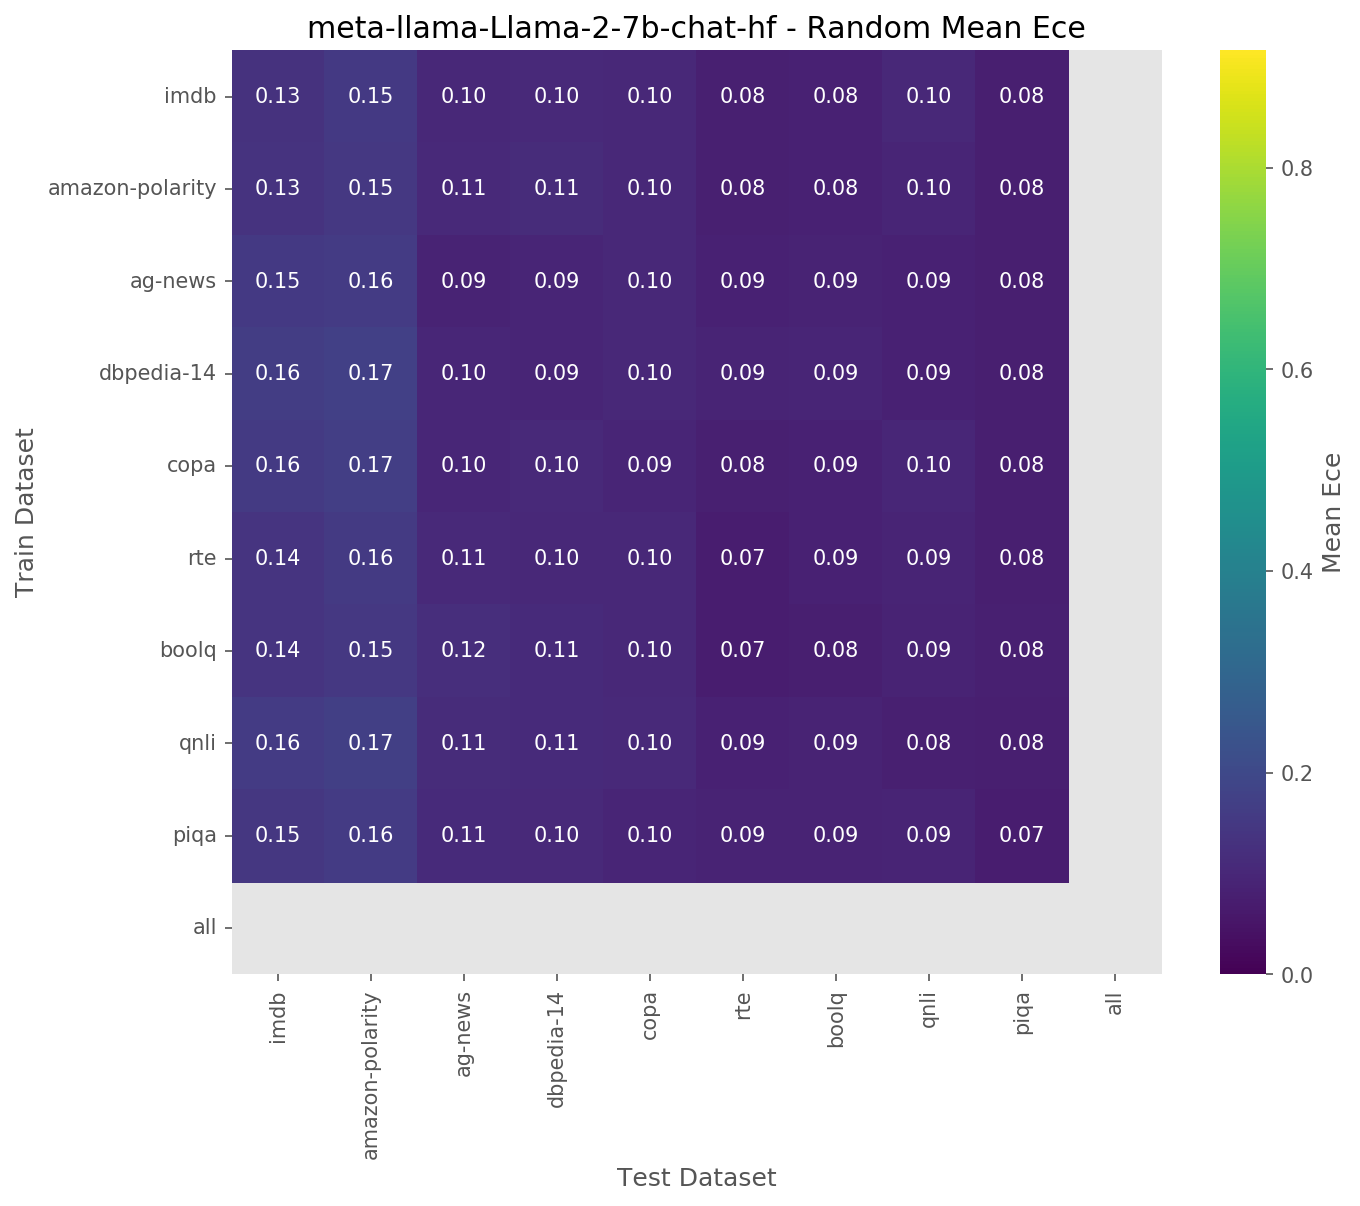

In [11]:
min_ece = df.ece.min()
max_ece = df.ece.max()
heatmap_kwargs = {"vmin": min_ece, "vmax": max_ece}
plot_heatmap(df, "ece", std_annot=False, heatmap_kwargs=heatmap_kwargs)

# Calibration curves

In [12]:
save_dir = "extraction_results"
experiment_name = "Llama-2-7b-chat-hf_v3"
ece_df = make_ece_df(save_dir, experiment_name)

In [13]:
ece_df

Empty DataFrame
Columns: [model, method, train, test, prompt, seed, run_id, acc, ece, bin_mean_probs, bin_mean_labels, flip_probs]
Index: []

In [14]:
sample_ece_df = ece_df.query(
    "method == 'CCS' and train == test and seed == 1 and prompt == 0"
)
for key, group_df in sample_ece_df.groupby(
    ["model", "method", "train", "test", "prompt", "seed"]
):
    assert len(group_df) == 2
    og_row = group_df[~group_df["flip_probs"]].iloc[0]
    flip_row = group_df[group_df["flip_probs"]].iloc[0]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    og_title = f"ECE={og_row.ece:.4f}"
    calibration_plot_from_bin_xy(
        og_row.bin_mean_probs, og_row.bin_mean_labels, og_title, ax=ax[0]
    )

    flip_title = f"ECE={flip_row.ece:.4f}"
    calibration_plot_from_bin_xy(
        flip_row.bin_mean_probs, flip_row.bin_mean_labels, flip_title, ax=ax[1]
    )

    title = f"{og_row.model} - {og_row.method} - train={og_row.train} - test={og_row.test} - prompt={og_row.prompt} - seed={og_row.seed}"
    fig.suptitle(title)

# LR direction similarity

In [13]:
# Compute inner products of all pairwise orthogonal directions across all
# datasets.

exp_dir = Path(
    "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex_20_orth_dirs/meta-llama-Llama-2-7b-chat-hf"
)
# Arbitrarily use IMDB as the unlabeled/unsupervised dataset to be consistent
# and because we only want to change the labeled dataset, which is used to
# train the orthogonal LR directions. Probably due to randomness, the LR
# directions are not the same across different unlabeled datasets for a given
# labeled dataset.
paths = exp_dir.glob("nolabel_imdb*/**/orthogonal_directions.npy")
inner_prods_df = make_inner_prods_df(paths)

## First direction only

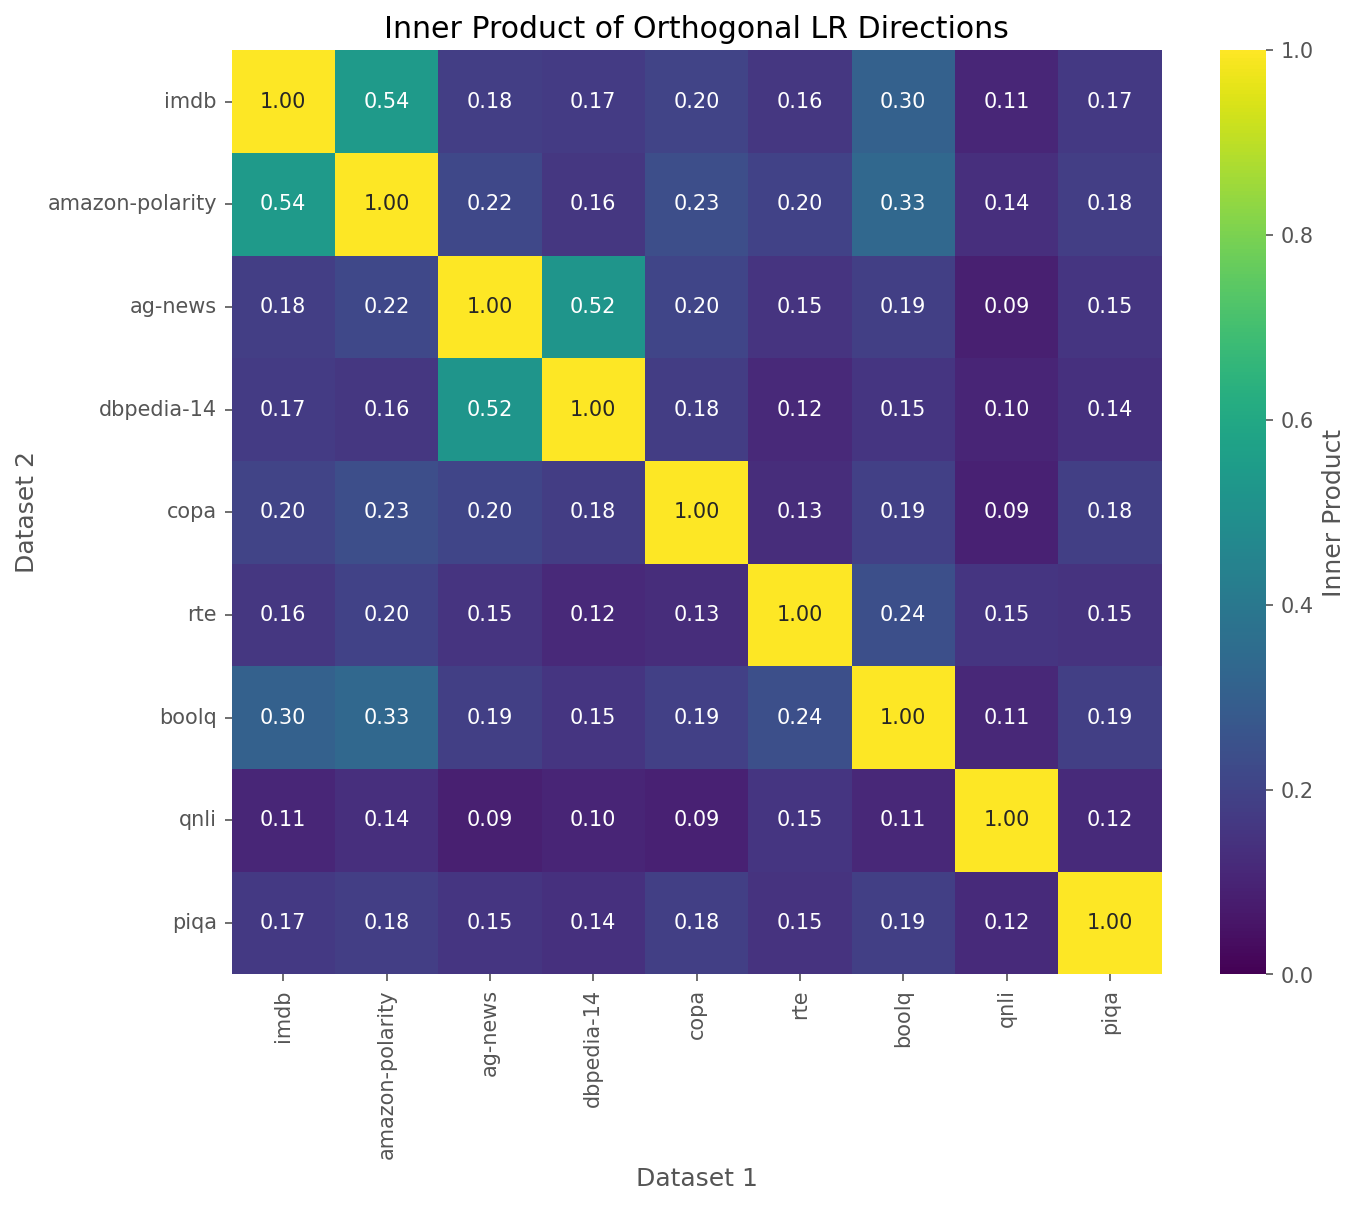

In [24]:
plot_inner_prods_heatmap(inner_prods_df.query("dir1_idx == dir2_idx == 0"))

## Most similar directions for each dataset pair

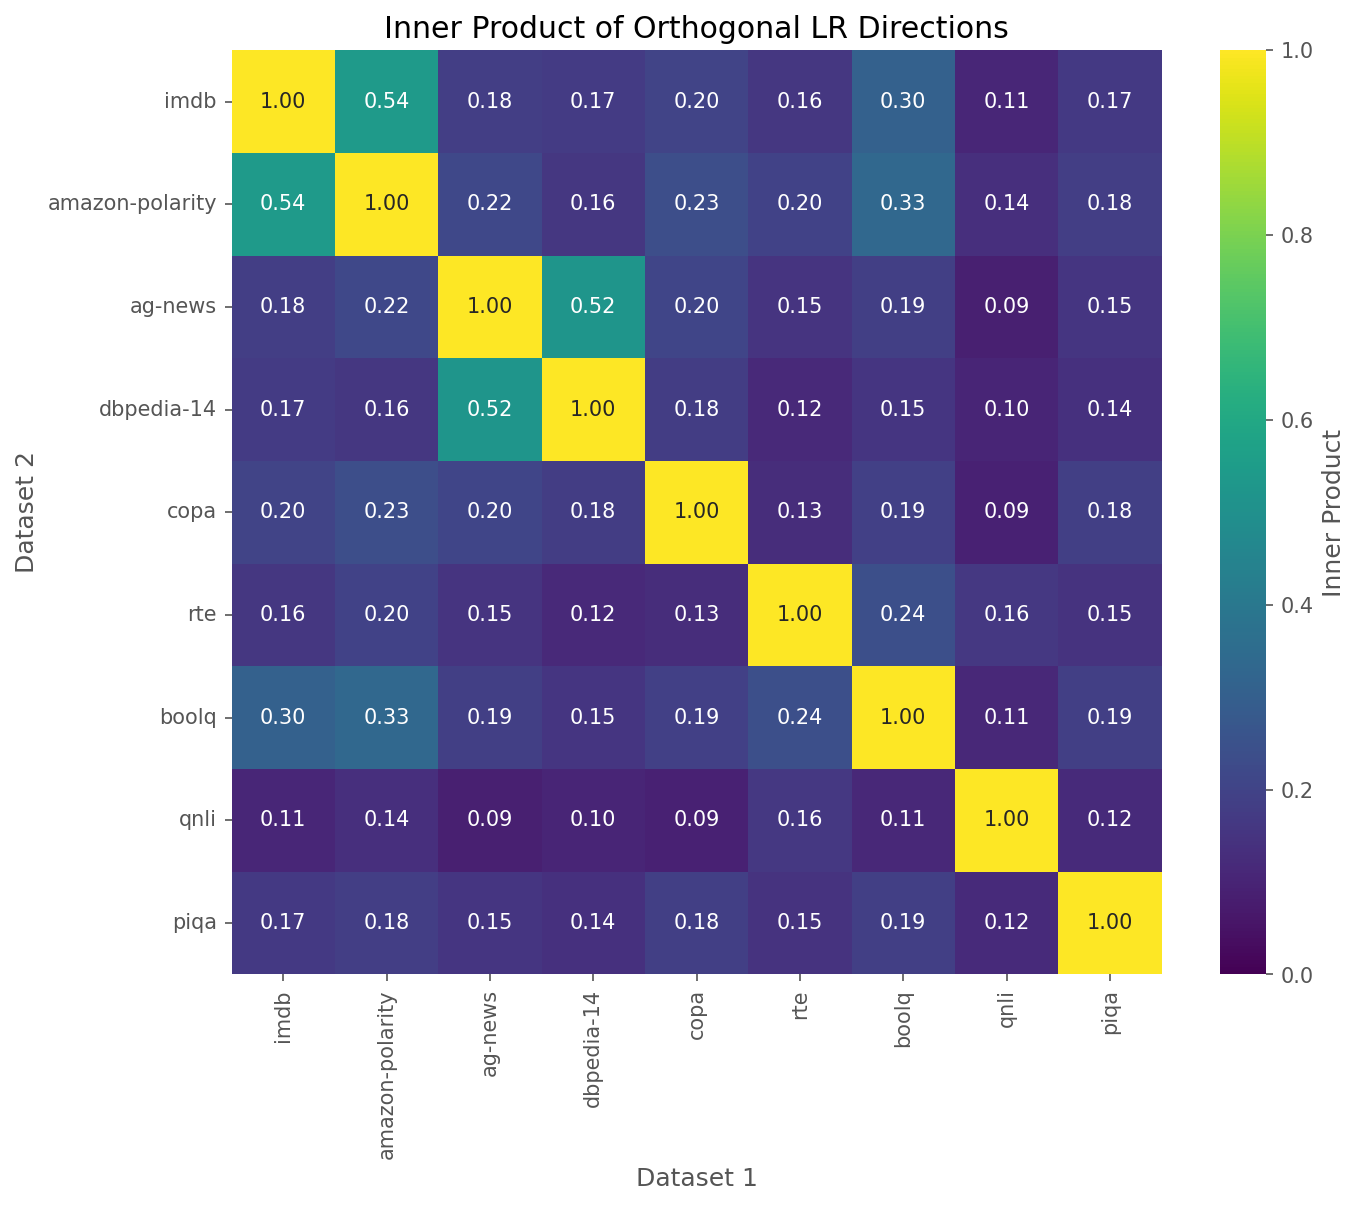

In [15]:
# Get the most similar directions by taking the max of the inner products for
# each dataset pair.
max_inner_prods_per_ds_combo_df = (
    inner_prods_df.groupby(["ds1", "ds2"])
    .inner_prod.max()
    .unstack()
    .reindex(index=DATASET_ORDER, columns=DATASET_ORDER)
)
plot_inner_prods_heatmap(max_inner_prods_per_ds_combo_df, needs_pivot=False)

## Top similar directions for each dataset pair

In [107]:
for ds1, ds2 in itertools.combinations(DATASET_ORDER, r=2):
    display(
        inner_prods_df.query("ds1 == @ds1 and ds2 == @ds2")
        .sort_values("inner_prod", ascending=False)
        .head(5)
    )

ds1              ds2  dir1_idx  dir2_idx  inner_prod
12800  imdb  amazon-polarity         0         0    0.542500
12821  imdb  amazon-polarity         1         1    0.255923
12820  imdb  amazon-polarity         1         0    0.191538
12841  imdb  amazon-polarity         2         1    0.187623
12842  imdb  amazon-polarity         2         2    0.157248

ds1      ds2  dir1_idx  dir2_idx  inner_prod
11200  imdb  ag-news         0         0    0.183005
11221  imdb  ag-news         1         1    0.099893
11241  imdb  ag-news         2         1    0.092485
11220  imdb  ag-news         1         0    0.088197
11201  imdb  ag-news         0         1    0.081135

ds1         ds2  dir1_idx  dir2_idx  inner_prod
13600  imdb  dbpedia-14         0         0    0.173638
13621  imdb  dbpedia-14         1         1    0.096872
13641  imdb  dbpedia-14         2         1    0.083864
13620  imdb  dbpedia-14         1         0    0.075753
13640  imdb  dbpedia-14         2         0    0.070537

ds1   ds2  dir1_idx  dir2_idx  inner_prod
12400  imdb  copa         0         0    0.201772
12420  imdb  copa         1         0    0.121805
12421  imdb  copa         1         1    0.089937
12401  imdb  copa         0         1    0.075886
12441  imdb  copa         2         1    0.068638

ds1  ds2  dir1_idx  dir2_idx  inner_prod
13200  imdb  rte         0         0    0.159868
13201  imdb  rte         0         1    0.152778
13221  imdb  rte         1         1    0.106966
13202  imdb  rte         0         2    0.101092
13222  imdb  rte         1         2    0.095887

ds1    ds2  dir1_idx  dir2_idx  inner_prod
11600  imdb  boolq         0         0    0.304807
11601  imdb  boolq         0         1    0.191289
11621  imdb  boolq         1         1    0.150624
11641  imdb  boolq         2         1    0.115412
11622  imdb  boolq         1         2    0.112169

ds1   ds2  dir1_idx  dir2_idx  inner_prod
10800  imdb  qnli         0         0    0.107618
10801  imdb  qnli         0         1    0.081397
10847  imdb  qnli         2         7    0.076590
10821  imdb  qnli         1         1    0.073619
10822  imdb  qnli         1         2    0.059387

ds1   ds2  dir1_idx  dir2_idx  inner_prod
14000  imdb  piqa         0         0    0.166213
14001  imdb  piqa         0         1    0.118653
14004  imdb  piqa         0         4    0.082622
14002  imdb  piqa         0         2    0.081359
14021  imdb  piqa         1         1    0.080182

ds1      ds2  dir1_idx  dir2_idx  inner_prod
18400  amazon-polarity  ag-news         0         0    0.216680
18421  amazon-polarity  ag-news         1         1    0.143785
18420  amazon-polarity  ag-news         1         0    0.106662
18441  amazon-polarity  ag-news         2         1    0.090008
18401  amazon-polarity  ag-news         0         1    0.075145

ds1         ds2  dir1_idx  dir2_idx  inner_prod
20800  amazon-polarity  dbpedia-14         0         0    0.156792
20820  amazon-polarity  dbpedia-14         1         0    0.114167
20821  amazon-polarity  dbpedia-14         1         1    0.111299
20802  amazon-polarity  dbpedia-14         0         2    0.097256
20801  amazon-polarity  dbpedia-14         0         1    0.082921

ds1   ds2  dir1_idx  dir2_idx  inner_prod
19600  amazon-polarity  copa         0         0    0.234937
19621  amazon-polarity  copa         1         1    0.118985
19620  amazon-polarity  copa         1         0    0.097832
19601  amazon-polarity  copa         0         1    0.080259
19641  amazon-polarity  copa         2         1    0.063696

ds1  ds2  dir1_idx  dir2_idx  inner_prod
20400  amazon-polarity  rte         0         0    0.198150
20401  amazon-polarity  rte         0         1    0.176735
20422  amazon-polarity  rte         1         2    0.138137
20402  amazon-polarity  rte         0         2    0.134783
20421  amazon-polarity  rte         1         1    0.127778

ds1    ds2  dir1_idx  dir2_idx  inner_prod
18800  amazon-polarity  boolq         0         0    0.334453
18801  amazon-polarity  boolq         0         1    0.211963
18821  amazon-polarity  boolq         1         1    0.179097
18802  amazon-polarity  boolq         0         2    0.118148
18822  amazon-polarity  boolq         1         2    0.116131

ds1   ds2  dir1_idx  dir2_idx  inner_prod
18000  amazon-polarity  qnli         0         0    0.136593
18021  amazon-polarity  qnli         1         1    0.097536
18022  amazon-polarity  qnli         1         2    0.088042
18001  amazon-polarity  qnli         0         1    0.081693
18023  amazon-polarity  qnli         1         3    0.073240

ds1   ds2  dir1_idx  dir2_idx  inner_prod
21200  amazon-polarity  piqa         0         0    0.181904
21201  amazon-polarity  piqa         0         1    0.114050
21202  amazon-polarity  piqa         0         2    0.103988
21221  amazon-polarity  piqa         1         1    0.083326
21203  amazon-polarity  piqa         0         3    0.073673

ds1         ds2  dir1_idx  dir2_idx  inner_prod
6400  ag-news  dbpedia-14         0         0    0.522959
6421  ag-news  dbpedia-14         1         1    0.258603
6422  ag-news  dbpedia-14         1         2    0.130776
6401  ag-news  dbpedia-14         0         1    0.129977
6420  ag-news  dbpedia-14         1         0    0.126148

ds1   ds2  dir1_idx  dir2_idx  inner_prod
5200  ag-news  copa         0         0    0.203356
5221  ag-news  copa         1         1    0.108718
5242  ag-news  copa         2         2    0.059286
5225  ag-news  copa         1         5    0.058179
5223  ag-news  copa         1         3    0.053215

ds1  ds2  dir1_idx  dir2_idx  inner_prod
6000  ag-news  rte         0         0    0.148721
6021  ag-news  rte         1         1    0.093312
6001  ag-news  rte         0         1    0.092818
6022  ag-news  rte         1         2    0.080045
6002  ag-news  rte         0         2    0.067707

ds1    ds2  dir1_idx  dir2_idx  inner_prod
4400  ag-news  boolq         0         0    0.186966
4401  ag-news  boolq         0         1    0.145680
4423  ag-news  boolq         1         3    0.101016
4421  ag-news  boolq         1         1    0.094163
4402  ag-news  boolq         0         2    0.091525

ds1   ds2  dir1_idx  dir2_idx  inner_prod
3600  ag-news  qnli         0         0    0.087840
3904  ag-news  qnli        15         4    0.051925
3991  ag-news  qnli        19        11    0.051455
3792  ag-news  qnli         9        12    0.050370
3623  ag-news  qnli         1         3    0.048285

ds1   ds2  dir1_idx  dir2_idx  inner_prod
6800  ag-news  piqa         0         0    0.153107
6801  ag-news  piqa         0         1    0.099182
6823  ag-news  piqa         1         3    0.071279
6821  ag-news  piqa         1         1    0.061278
6802  ag-news  piqa         0         2    0.059470

ds1   ds2  dir1_idx  dir2_idx  inner_prod
26800  dbpedia-14  copa         0         0    0.178272
26820  dbpedia-14  copa         1         0    0.074170
26821  dbpedia-14  copa         1         1    0.069737
26842  dbpedia-14  copa         2         2    0.060791
26841  dbpedia-14  copa         2         1    0.050682

ds1  ds2  dir1_idx  dir2_idx  inner_prod
27600  dbpedia-14  rte         0         0    0.116648
27601  dbpedia-14  rte         0         1    0.095429
27621  dbpedia-14  rte         1         1    0.089793
27602  dbpedia-14  rte         0         2    0.085195
27632  dbpedia-14  rte         1        12    0.056915

ds1    ds2  dir1_idx  dir2_idx  inner_prod
26000  dbpedia-14  boolq         0         0    0.155000
26021  dbpedia-14  boolq         1         1    0.108324
26001  dbpedia-14  boolq         0         1    0.095767
26023  dbpedia-14  boolq         1         3    0.085786
26002  dbpedia-14  boolq         0         2    0.079000

ds1   ds2  dir1_idx  dir2_idx  inner_prod
25200  dbpedia-14  qnli         0         0    0.103272
25251  dbpedia-14  qnli         2        11    0.060044
25299  dbpedia-14  qnli         4        19    0.047474
25458  dbpedia-14  qnli        12        18    0.044215
25580  dbpedia-14  qnli        19         0    0.043861

ds1   ds2  dir1_idx  dir2_idx  inner_prod
28400  dbpedia-14  piqa         0         0    0.138830
28421  dbpedia-14  piqa         1         1    0.090988
28401  dbpedia-14  piqa         0         1    0.078401
28403  dbpedia-14  piqa         0         3    0.069365
28426  dbpedia-14  piqa         1         6    0.063112

ds1  ds2  dir1_idx  dir2_idx  inner_prod
16800  copa  rte         0         0    0.126878
16801  copa  rte         0         1    0.116737
16802  copa  rte         0         2    0.067991
16821  copa  rte         1         1    0.060280
16840  copa  rte         2         0    0.058538

ds1    ds2  dir1_idx  dir2_idx  inner_prod
15200  copa  boolq         0         0    0.190514
15201  copa  boolq         0         1    0.120372
15221  copa  boolq         1         1    0.087495
15202  copa  boolq         0         2    0.074124
15222  copa  boolq         1         2    0.073173

ds1   ds2  dir1_idx  dir2_idx  inner_prod
14400  copa  qnli         0         0    0.093050
14441  copa  qnli         2         1    0.074324
14442  copa  qnli         2         2    0.057036
14420  copa  qnli         1         0    0.056988
14563  copa  qnli         8         3    0.053346

ds1   ds2  dir1_idx  dir2_idx  inner_prod
17600  copa  piqa         0         0    0.183898
17601  copa  piqa         0         1    0.153476
17602  copa  piqa         0         2    0.099195
17622  copa  piqa         1         2    0.082903
17620  copa  piqa         1         0    0.075356

ds1    ds2  dir1_idx  dir2_idx  inner_prod
22400  rte  boolq         0         0    0.241853
22421  rte  boolq         1         1    0.210400
22420  rte  boolq         1         0    0.156544
22401  rte  boolq         0         1    0.138080
22441  rte  boolq         2         1    0.122921

ds1   ds2  dir1_idx  dir2_idx  inner_prod
21620  rte  qnli         1         0    0.160733
21600  rte  qnli         0         0    0.152914
21621  rte  qnli         1         1    0.137256
21641  rte  qnli         2         1    0.107762
21640  rte  qnli         2         0    0.098395

ds1   ds2  dir1_idx  dir2_idx  inner_prod
24800  rte  piqa         0         0    0.147457
24821  rte  piqa         1         1    0.095211
24841  rte  piqa         2         1    0.094222
24820  rte  piqa         1         0    0.084125
24822  rte  piqa         1         2    0.082759

ds1   ds2  dir1_idx  dir2_idx  inner_prod
7200  boolq  qnli         0         0    0.110465
7220  boolq  qnli         1         0    0.093692
7221  boolq  qnli         1         1    0.093469
7241  boolq  qnli         2         1    0.080230
7222  boolq  qnli         1         2    0.077187

ds1   ds2  dir1_idx  dir2_idx  inner_prod
10400  boolq  piqa         0         0    0.187476
10421  boolq  piqa         1         1    0.126009
10420  boolq  piqa         1         0    0.107271
10441  boolq  piqa         2         1    0.087467
10422  boolq  piqa         1         2    0.086233

ds1   ds2  dir1_idx  dir2_idx  inner_prod
3200  qnli  piqa         0         0    0.118803
3201  qnli  piqa         0         1    0.085577
3202  qnli  piqa         0         2    0.077694
3222  qnli  piqa         1         2    0.060847
3221  qnli  piqa         1         1    0.058977

# LR in span analysis

In [14]:
# Compute inner products of all pairwise orthogonal directions across all
# datasets.

exp_dir = Path(
    "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex_20_orth_dirs/meta-llama-Llama-2-7b-chat-hf"
)
# Arbitrarily use IMDB as the unlabeled/unsupervised dataset to be consistent
# and because we only want to change the labeled dataset, which is used to
# train the orthogonal LR directions. Probably due to randomness, the LR
# directions are not the same across different unlabeled datasets for a given
# labeled dataset.
paths = exp_dir.glob("nolabel_imdb*/**/orthogonal_directions.npy")
train_to_orth_dirs = get_train_to_orth_dirs_dict(paths)

In [15]:
orth_dirs_1 = train_to_orth_dirs["imdb"]
orth_dirs_2 = train_to_orth_dirs["amazon-polarity"]

rows = []
for ds1, ds2 in itertools.product(train_to_orth_dirs, repeat=2):
    orth_dirs_1 = train_to_orth_dirs[ds1]
    orth_dirs_2 = train_to_orth_dirs[ds2]

    # Project each direction in orth_dirs_1 onto each direction in orth_dirs_2.
    # inner_prods[i, j] is the inner product of the i-th direction in orth_dirs_1
    # with the j-th direction in orth_dirs_2.
    inner_prods = orth_dirs_1 @ orth_dirs_2.T

    # orth_dirs_1 projected onto orth_dirs_2. dirs_1_proj_dirs2[i] is the i-th
    # direction from orth_dirs_1 projected onto the span of the rows of orth_dirs_2.
    dirs_1_proj_dirs_2 = orth_dirs_1 @ orth_dirs_2.T @ orth_dirs_2  # [n_dirs, hidden_dim]

    # Fraction (norm-wise) that each direction in orth_dirs_1 is in the span of the
    # directions in orth_dirs_2. Shape: [n_dirs].
    frac_dirs_1_in_span_dirs_2 = np.linalg.norm(dirs_1_proj_dirs_2, axis=1) / np.linalg.norm(
        orth_dirs_1, axis=1
    )
    for i in range(frac_dirs_1_in_span_dirs_2.shape[0]):
        rows.append({
            "ds1": ds1,
            "ds2": ds2,
            "dir1_idx": i,
            "frac_in_span": frac_dirs_1_in_span_dirs_2[i],
        })

frac_in_span_df = pd.DataFrame(rows)

In [16]:
frac_in_span_df.query("dir1_idx == 0").pivot(
    index="ds1", columns="ds2", values="frac_in_span"
).reindex(index=DATASET_ORDER, columns=DATASET_ORDER)

ds2                  imdb  amazon-polarity   ag-news  dbpedia-14      copa  \
ds1                                                                          
imdb             1.000000         0.572291  0.214423    0.200548  0.230010   
amazon-polarity  0.585412         0.999998  0.239731    0.210891  0.260590   
ag-news          0.231852         0.253206  1.000000    0.551527  0.218793   
dbpedia-14       0.224790         0.220546  0.545620    0.999999  0.196317   
copa             0.251965         0.272416  0.217771    0.199717  1.000000   
rte              0.184278         0.220611  0.160308    0.148538  0.150722   
boolq            0.331972         0.352821  0.201062    0.184051  0.214190   
qnli             0.149343         0.162601  0.125376    0.125598  0.129539   
piqa             0.192839         0.207100  0.169561    0.157117  0.209255   

ds2                   rte     boolq      qnli      piqa  
ds1                                                      
imdb             0.279520  0.386385  0.170393  0.264915  
amazon-polarity  0.327734  0.426335  0.185912  0.273984  
ag-news          0.208020  0.282907  0.121141  0.215008  
dbpedia-14       0.201318  0.230600  0.142764  0.204232  
copa             0.198139  0.258847  0.136577  0.290628  
rte              1.000000  0.300559  0.183666  0.201999  
boolq            0.310770  0.999999  0.152532  0.244354  
qnli             0.265886  0.186145  0.999998  0.175262  
piqa             0.195858  0.234443  0.143818  1.000001

## First direction only

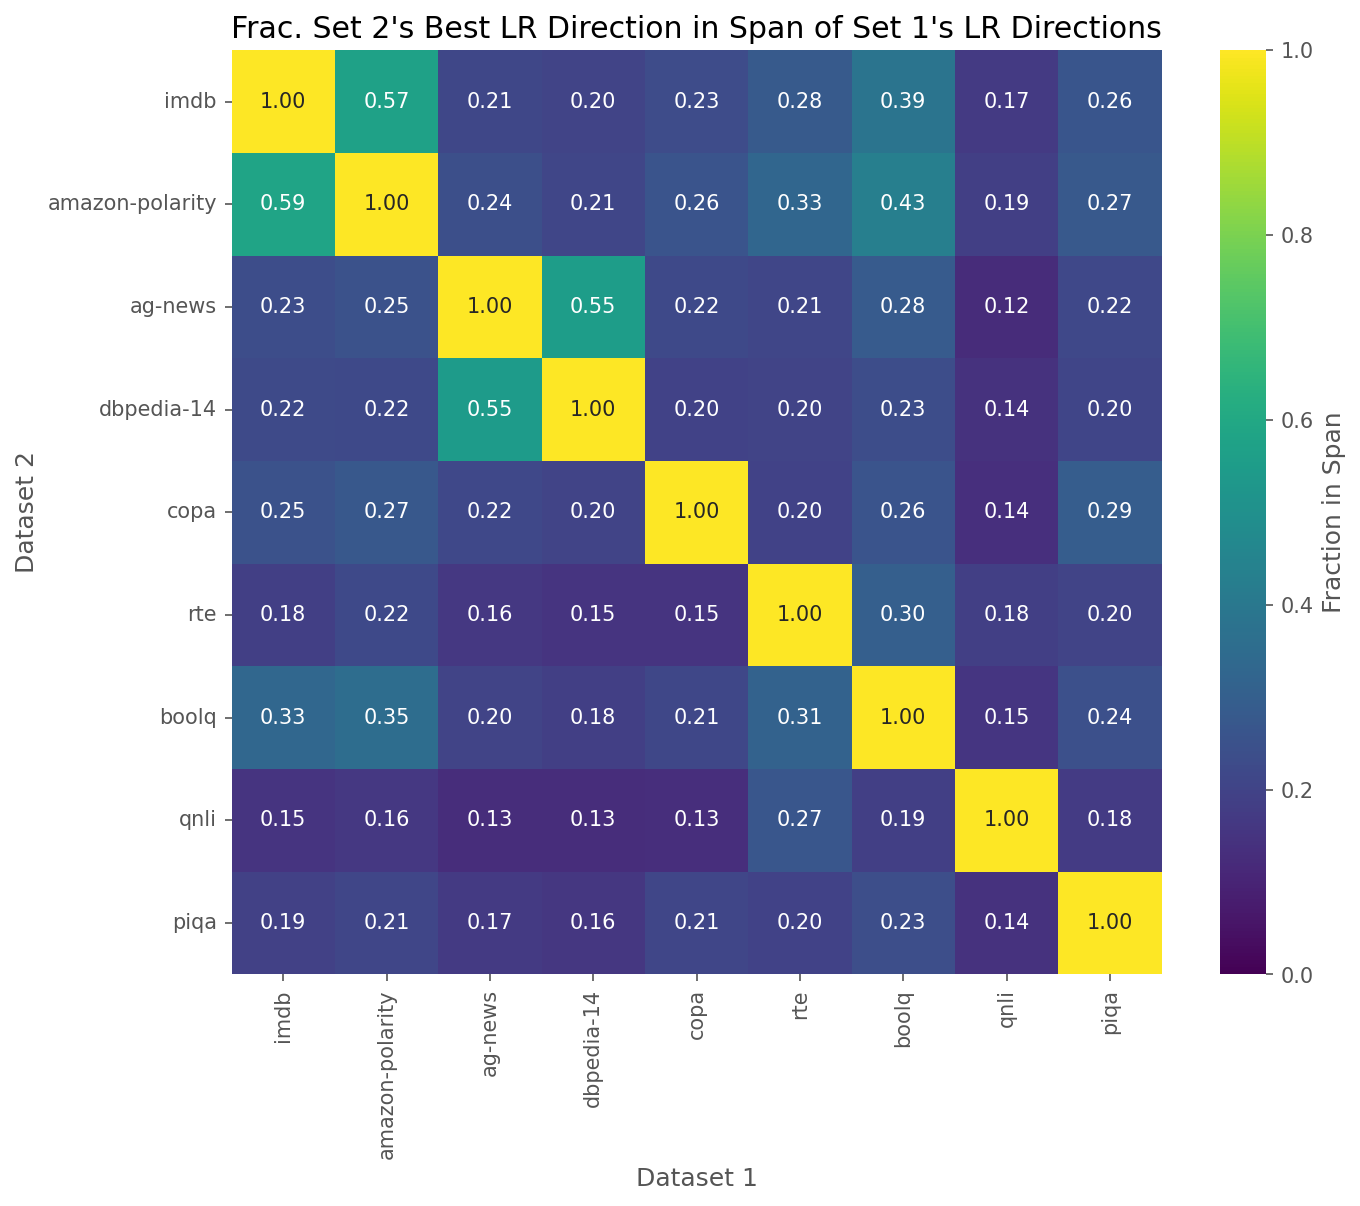

In [17]:
plot_heatmap_from_df(
    frac_in_span_df.query("dir1_idx == 0"),
    needs_pivot=True,
    pivot_values="frac_in_span",
    cbar_label="Fraction in Span",
    title="Frac. Set 2's Best LR Direction in Span of Set 1's LR Directions",
)

## Most in-span direction

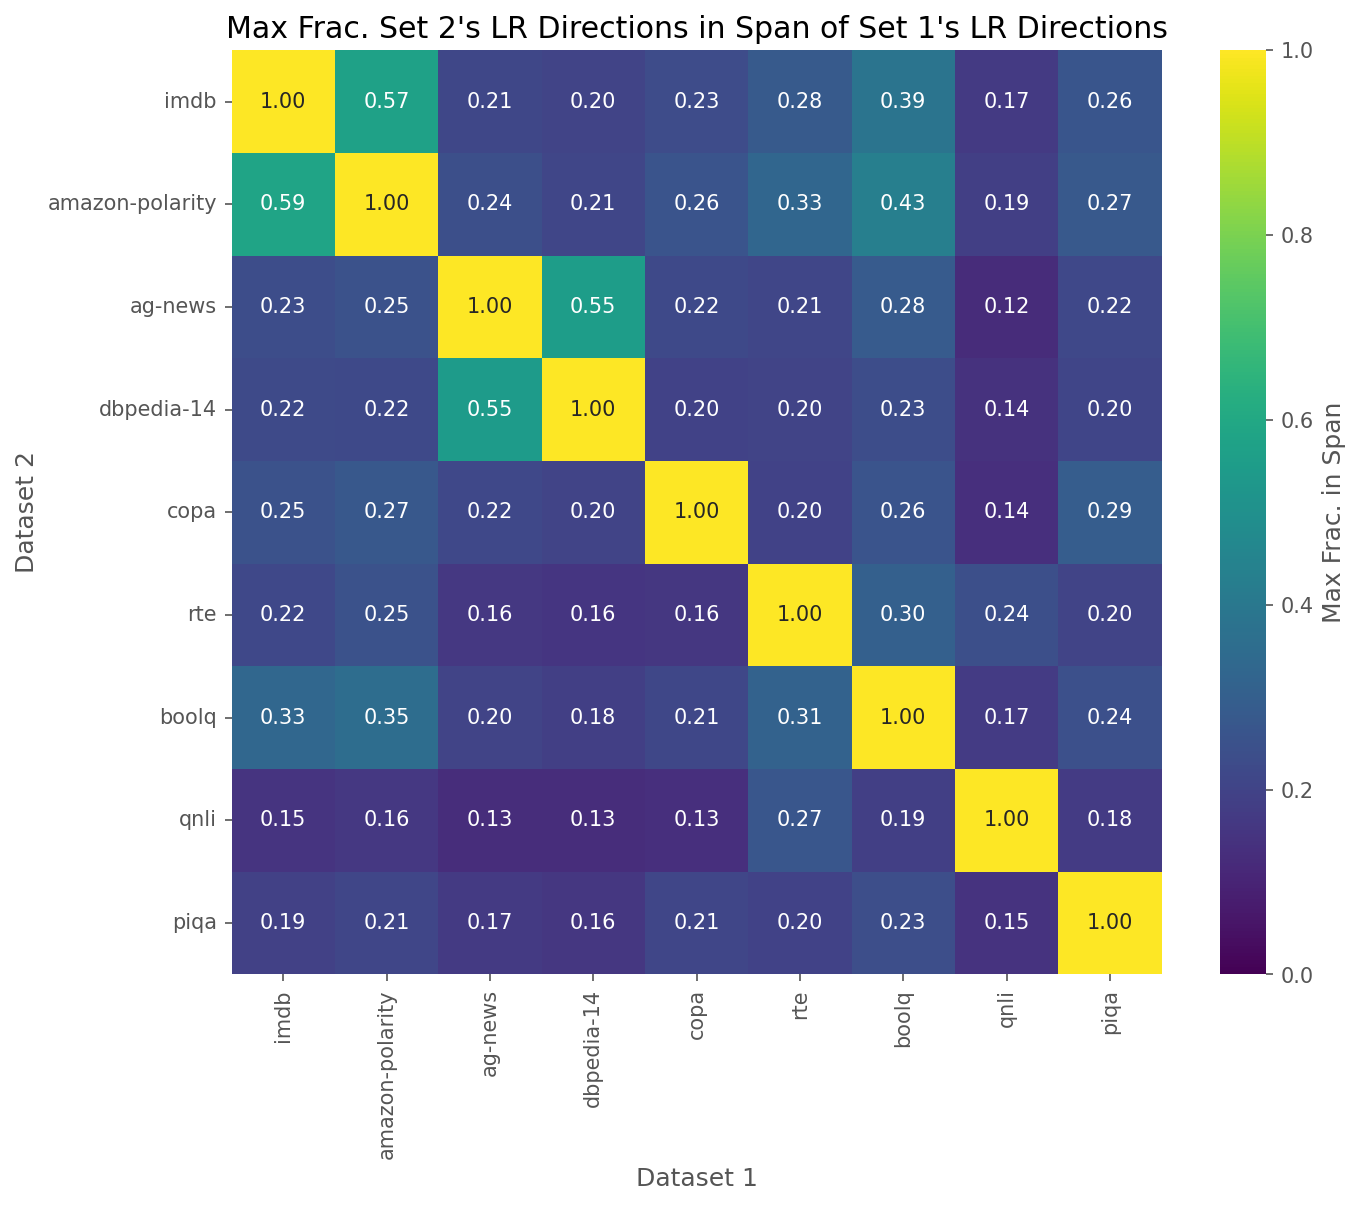

In [18]:
max_frac_in_span_per_ds_combo_df = (
    frac_in_span_df.groupby(["ds1", "ds2"])["frac_in_span"]
    .max()
    .unstack()
    .reindex(index=DATASET_ORDER, columns=DATASET_ORDER)
)
plot_heatmap_from_df(
    max_frac_in_span_per_ds_combo_df,
    needs_pivot=False,
    cbar_label="Max Frac. in Span",
    title="Max Frac. Set 2's LR Directions in Span of Set 1's LR Directions",
)

## Top in-span direction for each dataset combo

In [19]:
for ds1, ds2 in itertools.combinations(DATASET_ORDER, r=2):
    display(
        frac_in_span_df.query("ds1 == @ds1 and ds2 == @ds2")
        .sort_values("frac_in_span", ascending=False)
        .head(5)
    )

ds1              ds2  dir1_idx  frac_in_span
640  imdb  amazon-polarity         0      0.572291
641  imdb  amazon-polarity         1      0.358278
642  imdb  amazon-polarity         2      0.289132
643  imdb  amazon-polarity         3      0.250578
644  imdb  amazon-polarity         4      0.222579

ds1      ds2  dir1_idx  frac_in_span
560  imdb  ag-news         0      0.214423
561  imdb  ag-news         1      0.153514
562  imdb  ag-news         2      0.130501
563  imdb  ag-news         3      0.124152
577  imdb  ag-news        17      0.106244

ds1         ds2  dir1_idx  frac_in_span
680  imdb  dbpedia-14         0      0.200548
681  imdb  dbpedia-14         1      0.154464
682  imdb  dbpedia-14         2      0.154223
696  imdb  dbpedia-14        16      0.104852
697  imdb  dbpedia-14        17      0.104111

ds1   ds2  dir1_idx  frac_in_span
620  imdb  copa         0      0.230010
621  imdb  copa         1      0.167926
622  imdb  copa         2      0.124628
624  imdb  copa         4      0.122740
623  imdb  copa         3      0.112148

ds1  ds2  dir1_idx  frac_in_span
660  imdb  rte         0      0.279520
661  imdb  rte         1      0.209892
662  imdb  rte         2      0.163967
664  imdb  rte         4      0.106811
663  imdb  rte         3      0.104484

ds1    ds2  dir1_idx  frac_in_span
580  imdb  boolq         0      0.386385
581  imdb  boolq         1      0.265291
582  imdb  boolq         2      0.220431
583  imdb  boolq         3      0.195473
585  imdb  boolq         5      0.144762

ds1   ds2  dir1_idx  frac_in_span
540  imdb  qnli         0      0.170393
541  imdb  qnli         1      0.146373
543  imdb  qnli         3      0.119964
542  imdb  qnli         2      0.118875
545  imdb  qnli         5      0.100630

ds1   ds2  dir1_idx  frac_in_span
700  imdb  piqa         0      0.264915
701  imdb  piqa         1      0.176607
702  imdb  piqa         2      0.136949
703  imdb  piqa         3      0.108713
704  imdb  piqa         4      0.106539

ds1      ds2  dir1_idx  frac_in_span
920  amazon-polarity  ag-news         0      0.239731
921  amazon-polarity  ag-news         1      0.198407
922  amazon-polarity  ag-news         2      0.140130
925  amazon-polarity  ag-news         5      0.122407
926  amazon-polarity  ag-news         6      0.120253

ds1         ds2  dir1_idx  frac_in_span
1040  amazon-polarity  dbpedia-14         0      0.210891
1041  amazon-polarity  dbpedia-14         1      0.180638
1042  amazon-polarity  dbpedia-14         2      0.131879
1045  amazon-polarity  dbpedia-14         5      0.125583
1044  amazon-polarity  dbpedia-14         4      0.103039

ds1   ds2  dir1_idx  frac_in_span
980  amazon-polarity  copa         0      0.260590
981  amazon-polarity  copa         1      0.180908
982  amazon-polarity  copa         2      0.146856
983  amazon-polarity  copa         3      0.122164
984  amazon-polarity  copa         4      0.104484

ds1  ds2  dir1_idx  frac_in_span
1020  amazon-polarity  rte         0      0.327734
1021  amazon-polarity  rte         1      0.261821
1022  amazon-polarity  rte         2      0.169069
1023  amazon-polarity  rte         3      0.155980
1024  amazon-polarity  rte         4      0.123042

ds1    ds2  dir1_idx  frac_in_span
940  amazon-polarity  boolq         0      0.426335
941  amazon-polarity  boolq         1      0.289837
942  amazon-polarity  boolq         2      0.200002
943  amazon-polarity  boolq         3      0.181635
944  amazon-polarity  boolq         4      0.164484

ds1   ds2  dir1_idx  frac_in_span
901  amazon-polarity  qnli         1      0.186588
900  amazon-polarity  qnli         0      0.185912
902  amazon-polarity  qnli         2      0.131960
905  amazon-polarity  qnli         5      0.116815
903  amazon-polarity  qnli         3      0.112089

ds1   ds2  dir1_idx  frac_in_span
1060  amazon-polarity  piqa         0      0.273984
1061  amazon-polarity  piqa         1      0.184181
1062  amazon-polarity  piqa         2      0.143764
1063  amazon-polarity  piqa         3      0.124557
1065  amazon-polarity  piqa         5      0.111752

ds1         ds2  dir1_idx  frac_in_span
320  ag-news  dbpedia-14         0      0.551527
321  ag-news  dbpedia-14         1      0.350088
322  ag-news  dbpedia-14         2      0.216709
323  ag-news  dbpedia-14         3      0.170658
326  ag-news  dbpedia-14         6      0.169037

ds1   ds2  dir1_idx  frac_in_span
260  ag-news  copa         0      0.218793
261  ag-news  copa         1      0.167476
262  ag-news  copa         2      0.103738
266  ag-news  copa         6      0.098712
263  ag-news  copa         3      0.095836

ds1  ds2  dir1_idx  frac_in_span
300  ag-news  rte         0      0.208020
301  ag-news  rte         1      0.171434
302  ag-news  rte         2      0.107447
316  ag-news  rte        16      0.092783
304  ag-news  rte         4      0.089912

ds1    ds2  dir1_idx  frac_in_span
220  ag-news  boolq         0      0.282907
221  ag-news  boolq         1      0.235653
222  ag-news  boolq         2      0.123372
233  ag-news  boolq        13      0.100260
223  ag-news  boolq         3      0.096348

ds1   ds2  dir1_idx  frac_in_span
180  ag-news  qnli         0      0.121141
187  ag-news  qnli         7      0.104957
181  ag-news  qnli         1      0.101737
189  ag-news  qnli         9      0.100491
195  ag-news  qnli        15      0.095546

ds1   ds2  dir1_idx  frac_in_span
340  ag-news  piqa         0      0.215008
341  ag-news  piqa         1      0.133699
352  ag-news  piqa        12      0.096426
349  ag-news  piqa         9      0.095445
346  ag-news  piqa         6      0.092567

ds1   ds2  dir1_idx  frac_in_span
1340  dbpedia-14  copa         0      0.196317
1341  dbpedia-14  copa         1      0.137907
1342  dbpedia-14  copa         2      0.116992
1344  dbpedia-14  copa         4      0.103972
1343  dbpedia-14  copa         3      0.090901

ds1  ds2  dir1_idx  frac_in_span
1380  dbpedia-14  rte         0      0.201318
1381  dbpedia-14  rte         1      0.157800
1382  dbpedia-14  rte         2      0.120759
1383  dbpedia-14  rte         3      0.115909
1388  dbpedia-14  rte         8      0.087481

ds1    ds2  dir1_idx  frac_in_span
1300  dbpedia-14  boolq         0      0.230600
1301  dbpedia-14  boolq         1      0.214342
1302  dbpedia-14  boolq         2      0.181365
1303  dbpedia-14  boolq         3      0.151773
1308  dbpedia-14  boolq         8      0.117920

ds1   ds2  dir1_idx  frac_in_span
1260  dbpedia-14  qnli         0      0.142764
1262  dbpedia-14  qnli         2      0.104884
1261  dbpedia-14  qnli         1      0.087283
1273  dbpedia-14  qnli        13      0.085389
1267  dbpedia-14  qnli         7      0.081102

ds1   ds2  dir1_idx  frac_in_span
1420  dbpedia-14  piqa         0      0.204232
1421  dbpedia-14  piqa         1      0.164646
1422  dbpedia-14  piqa         2      0.117602
1423  dbpedia-14  piqa         3      0.092120
1427  dbpedia-14  piqa         7      0.085056

ds1  ds2  dir1_idx  frac_in_span
840  copa  rte         0      0.198139
841  copa  rte         1      0.117892
842  copa  rte         2      0.109983
846  copa  rte         6      0.104891
850  copa  rte        10      0.096374

ds1    ds2  dir1_idx  frac_in_span
760  copa  boolq         0      0.258847
761  copa  boolq         1      0.182559
762  copa  boolq         2      0.117742
763  copa  boolq         3      0.093592
766  copa  boolq         6      0.089087

ds1   ds2  dir1_idx  frac_in_span
720  copa  qnli         0      0.136577
721  copa  qnli         1      0.115944
722  copa  qnli         2      0.114794
725  copa  qnli         5      0.097938
729  copa  qnli         9      0.095104

ds1   ds2  dir1_idx  frac_in_span
880  copa  piqa         0      0.290628
881  copa  piqa         1      0.194549
882  copa  piqa         2      0.133603
884  copa  piqa         4      0.116198
883  copa  piqa         3      0.107948

ds1    ds2  dir1_idx  frac_in_span
1121  rte  boolq         1      0.304330
1120  rte  boolq         0      0.300559
1122  rte  boolq         2      0.221031
1123  rte  boolq         3      0.171952
1125  rte  boolq         5      0.139726

ds1   ds2  dir1_idx  frac_in_span
1081  rte  qnli         1      0.238548
1082  rte  qnli         2      0.206653
1080  rte  qnli         0      0.183666
1083  rte  qnli         3      0.176208
1084  rte  qnli         4      0.153752

ds1   ds2  dir1_idx  frac_in_span
1240  rte  piqa         0      0.201999
1241  rte  piqa         1      0.194903
1242  rte  piqa         2      0.171289
1243  rte  piqa         3      0.143036
1244  rte  piqa         4      0.120840

ds1   ds2  dir1_idx  frac_in_span
361  boolq  qnli         1      0.174162
362  boolq  qnli         2      0.157019
360  boolq  qnli         0      0.152532
363  boolq  qnli         3      0.120853
366  boolq  qnli         6      0.113244

ds1   ds2  dir1_idx  frac_in_span
520  boolq  piqa         0      0.244354
521  boolq  piqa         1      0.239652
522  boolq  piqa         2      0.187662
524  boolq  piqa         4      0.136097
526  boolq  piqa         6      0.133161

ds1   ds2  dir1_idx  frac_in_span
160  qnli  piqa         0      0.175262
161  qnli  piqa         1      0.126085
163  qnli  piqa         3      0.112469
162  qnli  piqa         2      0.108118
168  qnli  piqa         8      0.092063

# Hyperparameter search/analysis

## CCS+LR: lr, sup_weight, unsup_weight

In [52]:
# df = experiment_dfs["Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep"]
df = experiment_dfs["Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_adam"]
df.head()

model             prefix  method  \
0  /scratch/data/meta-llama/Llama-2-7b-chat-hf  normal-bananashed  CCS+LR   
1  /scratch/data/meta-llama/Llama-2-7b-chat-hf  normal-bananashed  CCS+LR   
2  /scratch/data/meta-llama/Llama-2-7b-chat-hf  normal-bananashed  CCS+LR   
3  /scratch/data/meta-llama/Llama-2-7b-chat-hf  normal-bananashed  CCS+LR   
4  /scratch/data/meta-llama/Llama-2-7b-chat-hf  normal-bananashed  CCS+LR   

   prompt_level    mode    train train_labeled     test location  layer  ...  \
0             0  concat  ag-news          imdb  ag-news     auto     -1  ...   
1             1  concat  ag-news          imdb  ag-news     auto     -1  ...   
2             2  concat  ag-news          imdb  ag-news     auto     -1  ...   
3             3  concat  ag-news          imdb  ag-news     auto     -1  ...   
4             4  concat  ag-news          imdb  ag-news     auto     -1  ...   

   save_fit_result  save_params  save_results  save_states  \
0             True        False          True        False   
1             True        False          True        False   
2             True        False          True        False   
3             True        False          True        False   
4             True        False          True        False   

   save_train_test_split  sup_weight  test_on_train  unsup_weight  verbose  \
0                   True          10          False             1    False   
1                   True          10          False             1    False   
2                   True          10          False             1    False   
3                   True          10          False             1    False   
4                   True          10          False             1    False   

        zero  
0  zero_shot  
1  zero_shot  
2  zero_shot  
3  zero_shot  
4  zero_shot  

[5 rows x 54 columns]

In [55]:
accs = {}
for key, group_df in df.groupby(
    [
        "model",
        "method",
        "prefix",
        "mode",
        "train",
        "train_labeled",
        "test",
        "location",
        "layer",
    ]
):
    accs[key] = {}
    for hparam_key, hparam_group_df in group_df.groupby(
        ["sup_weight", "unsup_weight", "lr", "n_epochs"]
    ):
        acc = hparam_group_df.accuracy.mean()
        accs[key][hparam_key] = acc

In [56]:
acc_regret_dict = defaultdict(int)

for key, hparam_dict in accs.items():
    (
        model,
        method,
        prefix,
        mode,
        train,
        train_labeled,
        test,
        location,
        layer,
    ) = key
    if train != test:
        continue

    print(key)
    best_acc = max(hparam_dict.values())
    for hparam_key, acc in sorted(
        hparam_dict.items(), key=lambda key_acc: key_acc[1], reverse=True
    ):
        print(hparam_key, acc)
        acc_regret = best_acc - acc
        acc_regret_dict[hparam_key] += acc_regret
    print()

('/scratch/data/meta-llama/Llama-2-7b-chat-hf', 'CCS+LR', 'normal-bananashed', 'concat', 'ag-news', 'imdb', 'ag-news', 'auto', -1)
(10, 1, 0.001, 1000) 0.5356249883770943

('/scratch/data/meta-llama/Llama-2-7b-chat-hf', 'CCS+LR', 'normal-bananashed', 'concat', 'amazon-polarity', 'imdb', 'amazon-polarity', 'auto', -1)
(10, 1, 0.001, 1000) 0.9238636276938699

('/scratch/data/meta-llama/Llama-2-7b-chat-hf', 'CCS+LR', 'normal-bananashed', 'concat', 'dbpedia-14', 'imdb', 'dbpedia-14', 'auto', -1)
(10, 1, 0.001, 1000) 0.7153124809265137



In [57]:
sorted(acc_regret_dict.items(), key=lambda x: x[1])

[((10, 1, 0.001, 1000), 0.0)]

## LR: C, max_iter, penalty

In [61]:
df = experiment_dfs["Llama-2-7b-chat-hf_normal-bananashed_LR-mode=concat-sweep"].copy()
df["log_reg.penalty"] = df["log_reg.penalty"].apply(
    lambda x: "None" if pd.isnull(x) else x
)
df.head()

model             prefix method  \
0  /scratch/data/meta-llama/Llama-2-7b-chat-hf  normal-bananashed     LR   
1  /scratch/data/meta-llama/Llama-2-7b-chat-hf  normal-bananashed     LR   
2  /scratch/data/meta-llama/Llama-2-7b-chat-hf  normal-bananashed     LR   
3  /scratch/data/meta-llama/Llama-2-7b-chat-hf  normal-bananashed     LR   
4  /scratch/data/meta-llama/Llama-2-7b-chat-hf  normal-bananashed     LR   

   prompt_level    mode            train train_labeled     test location  \
0             0  concat  amazon-polarity                ag-news     auto   
1             1  concat  amazon-polarity                ag-news     auto   
2             2  concat  amazon-polarity                ag-news     auto   
3             3  concat  amazon-polarity                ag-news     auto   
4             4  concat  amazon-polarity                ag-news     auto   

   layer  ...  save_params  save_results save_states save_train_test_split  \
0     -1  ...        False          True       False                  True   
1     -1  ...        False          True       False                  True   
2     -1  ...        False          True       False                  True   
3     -1  ...        False          True       False                  True   
4     -1  ...        False          True       False                  True   

   sup_weight  test_on_train  test_prefix unsup_weight verbose       zero  
0           3          False       normal            1   False  zero_shot  
1           3          False       normal            1   False  zero_shot  
2           3          False       normal            1   False  zero_shot  
3           3          False       normal            1   False  zero_shot  
4           3          False       normal            1   False  zero_shot  

[5 rows x 51 columns]

In [63]:
accs = {}
for key, group_df in df.groupby(
    [
        "model",
        "method",
        "prefix",
        "mode",
        "train",
        "train_labeled",
        "test",
        "location",
        "layer",
    ]
):
    accs[key] = {}
    for hparam_key, hparam_group_df in group_df.groupby(
        ["log_reg.C", "log_reg.max_iter", "log_reg.penalty"], dropna=False
    ):
        acc = hparam_group_df.accuracy.mean()
        accs[key][hparam_key] = acc

In [64]:
acc_regret_dict = defaultdict(int)

for key, hparam_dict in accs.items():
    (
        model,
        method,
        prefix,
        mode,
        train,
        train_labeled,
        test,
        location,
        layer,
    ) = key
    print(key)
    best_acc = max(hparam_dict.values())
    for hparam_key, acc in sorted(
        hparam_dict.items(), key=lambda key_acc: key_acc[1], reverse=True
    ):
        print(hparam_key, acc)
        acc_regret = best_acc - acc
        acc_regret_dict[hparam_key] += acc_regret
    print()

('/scratch/data/meta-llama/Llama-2-7b-chat-hf', 'LR', 'normal-bananashed', 'concat', 'amazon-polarity', '', 'ag-news', 'auto', -1)
(0.001, 10000, 'l2') 0.7546875
(0.01, 10000, 'l2') 0.7375
(0.1, 10000, 'l2') 0.6790624999999999
(1.0, 10000, 'l2') 0.6275
(10.0, 10000, 'l2') 0.6234375
(10.0, 10000, 'None') 0.528125
(0.01, 10000, 'None') 0.5265625
(0.1, 10000, 'None') 0.5237499999999999
(1.0, 10000, 'None') 0.5209375
(0.001, 10000, 'None') 0.5175000000000001

('/scratch/data/meta-llama/Llama-2-7b-chat-hf', 'LR', 'normal-bananashed', 'concat', 'amazon-polarity', '', 'amazon-polarity', 'auto', -1)
(0.1, 10000, 'l2') 0.9540909090909092
(0.01, 10000, 'l2') 0.9488636363636362
(0.001, 10000, 'l2') 0.9359090909090907
(10.0, 10000, 'l2') 0.9218181818181818
(1.0, 10000, 'l2') 0.9188636363636363
(0.01, 10000, 'None') 0.7981818181818181
(1.0, 10000, 'None') 0.7902272727272727
(10.0, 10000, 'None') 0.7836363636363637
(0.1, 10000, 'None') 0.7720454545454545
(0.001, 10000, 'None') 0.7552272727272729

('

In [66]:
sorted(acc_regret_dict.items(), key=lambda x: x[1])

[((0.01, 10000, 'l2'), 0.17281259712509722),
 ((0.001, 10000, 'l2'), 0.2469307012432015),
 ((0.1, 10000, 'l2'), 0.835930264180264),
 ((1.0, 10000, 'l2'), 1.4985008741258738),
 ((10.0, 10000, 'l2'), 1.8589597902097903),
 ((0.01, 10000, 'None'), 4.23057434926185),
 ((0.1, 10000, 'None'), 4.356222999222998),
 ((1.0, 10000, 'None'), 4.417205759518261),
 ((10.0, 10000, 'None'), 4.433017191142191),
 ((0.001, 10000, 'None'), 4.675026952214451)]

In [10]:
np.mean(
    [
        0.7674999833106995,
        0.7949999570846558,
        0.8100000023841858,
        0.8524999618530273,
        0.7924999594688416,
        0.8499999642372131,
        0.762499988079071,
        0.7475000023841858,
        0.8449999690055847,
        0.7949999570846558,
        0.7799999713897705,
        0.7899999618530273,
        0.7924999594688416,
    ]
)

0.7984615105849046

# CCS in LR span

In [119]:
path = "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex_20_orth_dirs/meta-llama-Llama-2-7b-chat-hf/nolabel_imdb-label_boolq/seed_0/1/train/fit_result_CCS-in-LR-span.json"
with open(path, "r") as f:
    fit_result = json.load(f)

Text(0, 0.5, 'Accuracy')

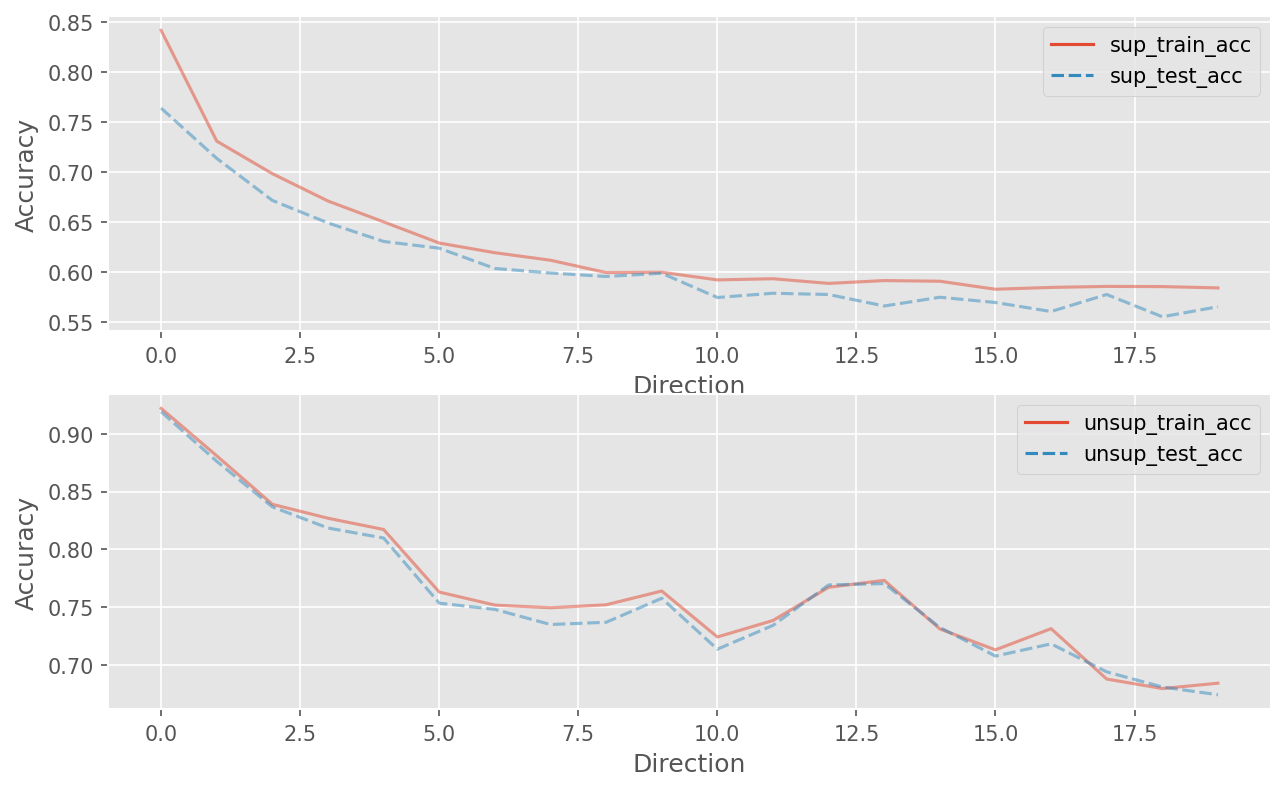

In [120]:
orth_dir_acc_df = pd.DataFrame(fit_result["lr_fit_results"])

max_n_dirs = 200
sup_acc_df = orth_dir_acc_df[["sup_train_acc", "sup_test_acc"]].iloc[:max_n_dirs]
unsup_acc_df = orth_dir_acc_df[["unsup_train_acc", "unsup_test_acc"]].iloc[:max_n_dirs]

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

sns.lineplot(sup_acc_df, alpha=0.5, ax=axs[0])
axs[0].set_xlabel("Direction")
axs[0].set_ylabel("Accuracy")
# axs[0].set_title("Accuracy on Supervised Data")

sns.lineplot(unsup_acc_df, alpha=0.5, ax=axs[1])
axs[1].set_xlabel("Direction")
axs[1].set_ylabel("Accuracy")
# axs[1].set_title("Accuracy on Supervised Data")

# CCS select LR

In [6]:
save_dir = "extraction_results"
experiment_name = "Llama-2-7b-chat-hf_normal-bananashed_CCS-select-LR-sweep_num_dirs"
df = load_eval_csvs(
    save_dir,
    experiment_name,
    use_latest_run_id=False,  # Different run IDs use different numbers of directions
    use_best_in_domain_acc=True,
)

  0%|          | 0/28 [00:00<?, ?it/s]

Selecting best in-domain accuracy...


## Accuracy vs. num orthogonal directions

meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 1 0.7918749824166298
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 2 0.7918749824166298
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 4 0.7918749824166298
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 5 0.6084374859929085
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 6 0.6084374859929085
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 7 0.6084374859929085
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 8 0.6084374859929085
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 16 0.6084374859929085
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 32 0.6318749785423279
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 64 0.5703124813735485
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb dbpedia-14 128 0.

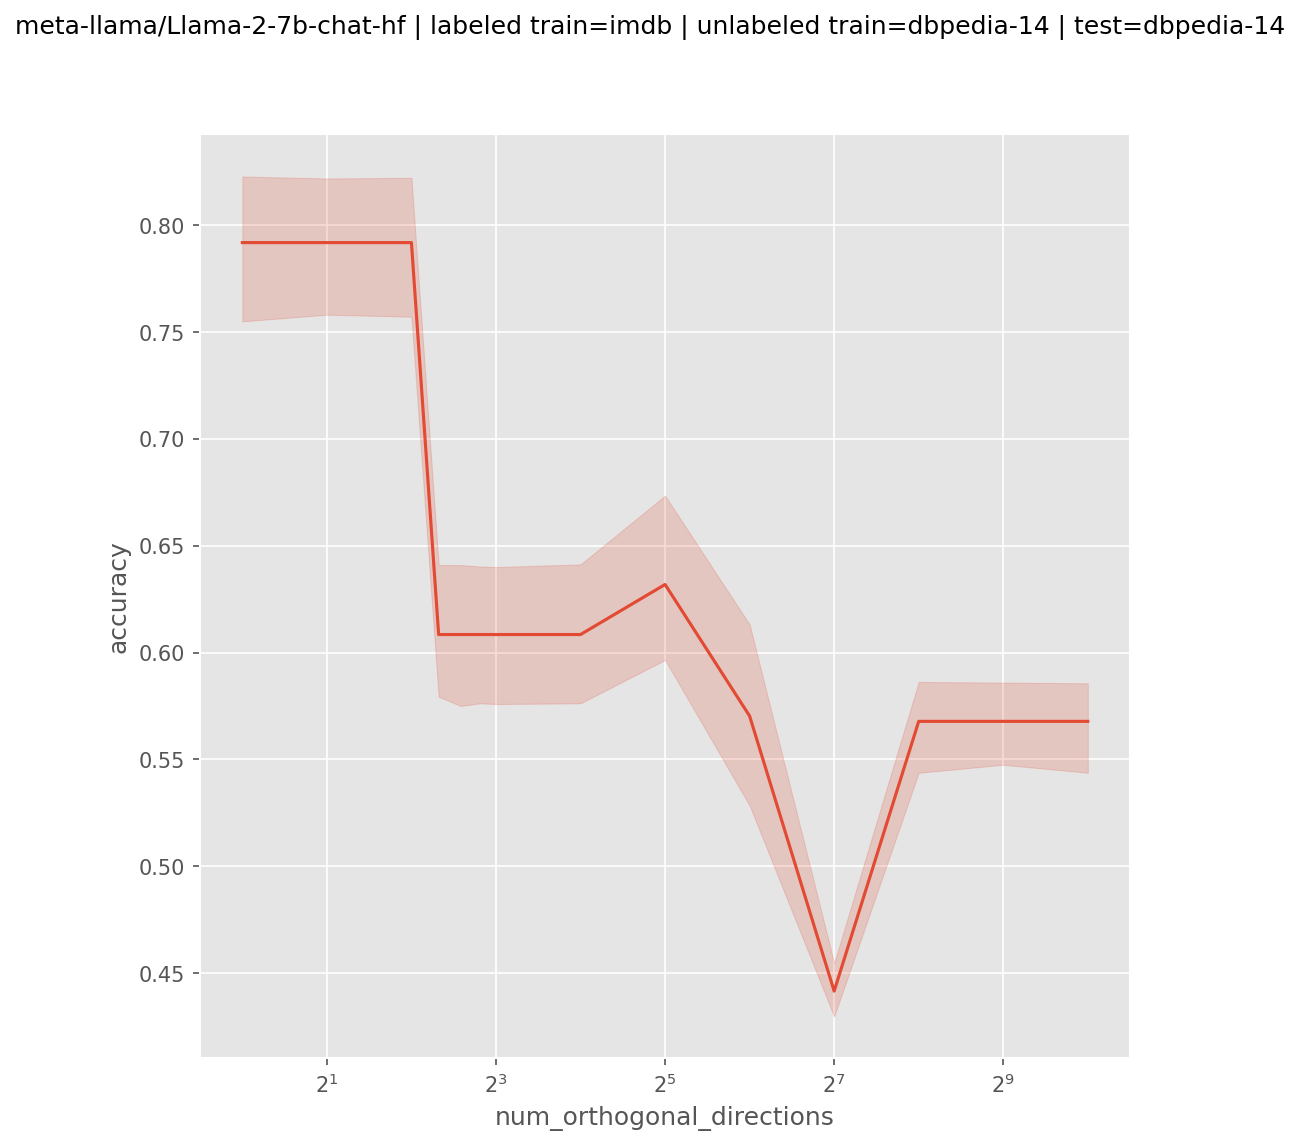

meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 1 0.953269206560575
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 2 0.953269206560575
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 4 0.953269206560575
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 5 0.8205769107891963
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 6 0.8205769107891963
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 7 0.8205769107891963
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 8 0.8205769107891963
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 16 0.8205769107891963
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 32 0.7103845981451181
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 64 0.6474999877122732
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-14 imdb imdb 128 0.6059615245232215
meta-llama/Llama-2-7b-chat-hf CCS-select-LR dbpedia-

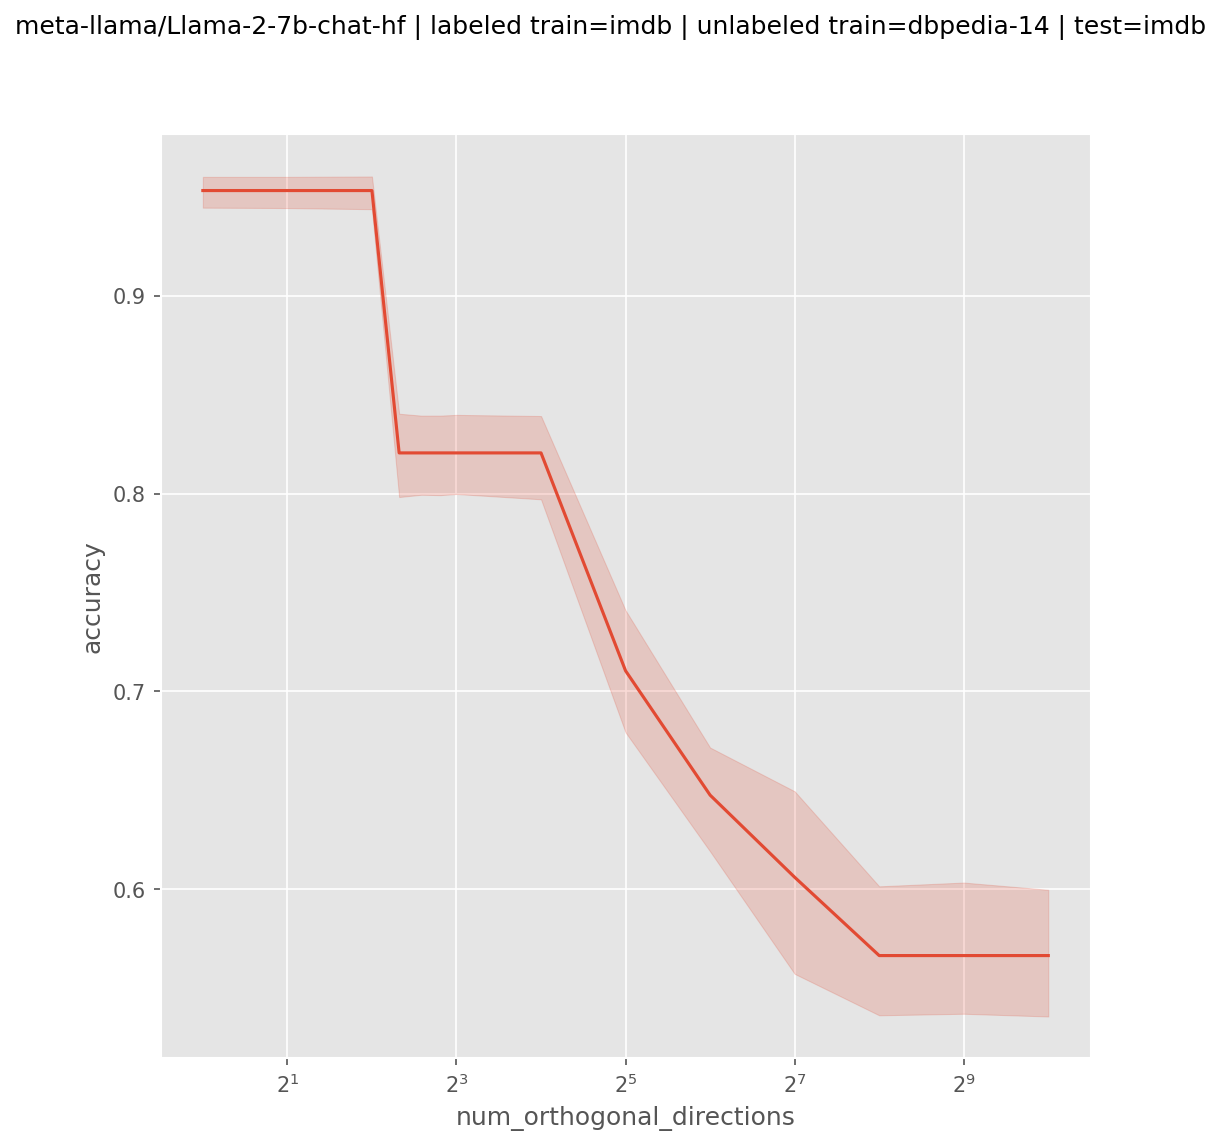

In [7]:
for (model, method, train, train_labeled, test), group_df in df.groupby(
    ["model", "method", "train", "train_labeled", "test"]
):
    for num_orthogonal_directions, num_orthogonal_group_df in group_df.groupby(
        "num_orthogonal_directions"
    ):
        assert num_orthogonal_group_df.run_id.nunique() == 1
        accuracy = num_orthogonal_group_df.accuracy.mean()
        print(
            model,
            method,
            train,
            train_labeled,
            test,
            num_orthogonal_directions,
            accuracy,
        )

    sns.lineplot(
        data=group_df, x="num_orthogonal_directions", y="accuracy", errorbar="ci"
    )
    plt.xscale("log", base=2)
    plt.suptitle(
        f"{model} | labeled train={train_labeled} | unlabeled train={train} | test={test}"
    )
    plt.show()

## Which dir is chosen vs. num dirs?

In [28]:
path = Path(
    "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-select-LR-sweep_num_dirs/meta-llama-Llama-2-7b-chat-hf/nolabel_dbpedia-14-label_imdb/seed_0"
)

all_num_orthogonal_directions = []
all_best_idx = []
for run_id_dir in path.glob("*"):
    if run_id_dir.is_dir():
        config_path = run_id_dir / "config.json"
        with open(config_path, "r") as f:
            config = json.load(f)
        num_orthogonal_directions = config["num_orthogonal_directions"]
        all_num_orthogonal_directions.append(num_orthogonal_directions)

        fit_result_paths = (run_id_dir / "train").glob("fit_result*.json")
        for path in fit_result_paths:
            with open(path, "r") as f:
                fit_result = json.load(f)
            all_best_idx.append(fit_result["best_idx"])

In [33]:
for num_dirs, best_idx in sorted(
    zip(all_num_orthogonal_directions, all_best_idx), key=lambda x: x[0]
):
    print(f"# directions: {num_dirs}, best idx: {best_idx}")

# directions: 1, best idx: 0
# directions: 2, best idx: 0
# directions: 4, best idx: 0
# directions: 5, best idx: 4
# directions: 6, best idx: 4
# directions: 7, best idx: 4
# directions: 8, best idx: 4
# directions: 16, best idx: 4
# directions: 32, best idx: 31
# directions: 64, best idx: 60
# directions: 128, best idx: 104
# directions: 256, best idx: 178
# directions: 512, best idx: 178
# directions: 1024, best idx: 178


## CCS loss per direction

In [8]:
# CCS-select-LR result
path = "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-select-LR-sweep_num_dirs/meta-llama-Llama-2-7b-chat-hf/nolabel_dbpedia-14-label_imdb/seed_0/11/train/fit_result_CCS-select-LR.json"
with open(path, "r") as f:
    fit_result = json.load(f)

# LR orthogonal directions fit results
path = "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-sweep_num_dirs/meta-llama-Llama-2-7b-chat-hf/nolabel_dbpedia-14-label_imdb/seed_0/2/train/fit_result_CCS-in-LR-span.json"
with open(path, "r") as f:
    lr_orth_dirs_fit_result = json.load(f)

lr_orth_dirs_acc_df = pd.DataFrame(lr_orth_dirs_fit_result["lr_fit_results"])

TypeError: unhashable type: 'list'

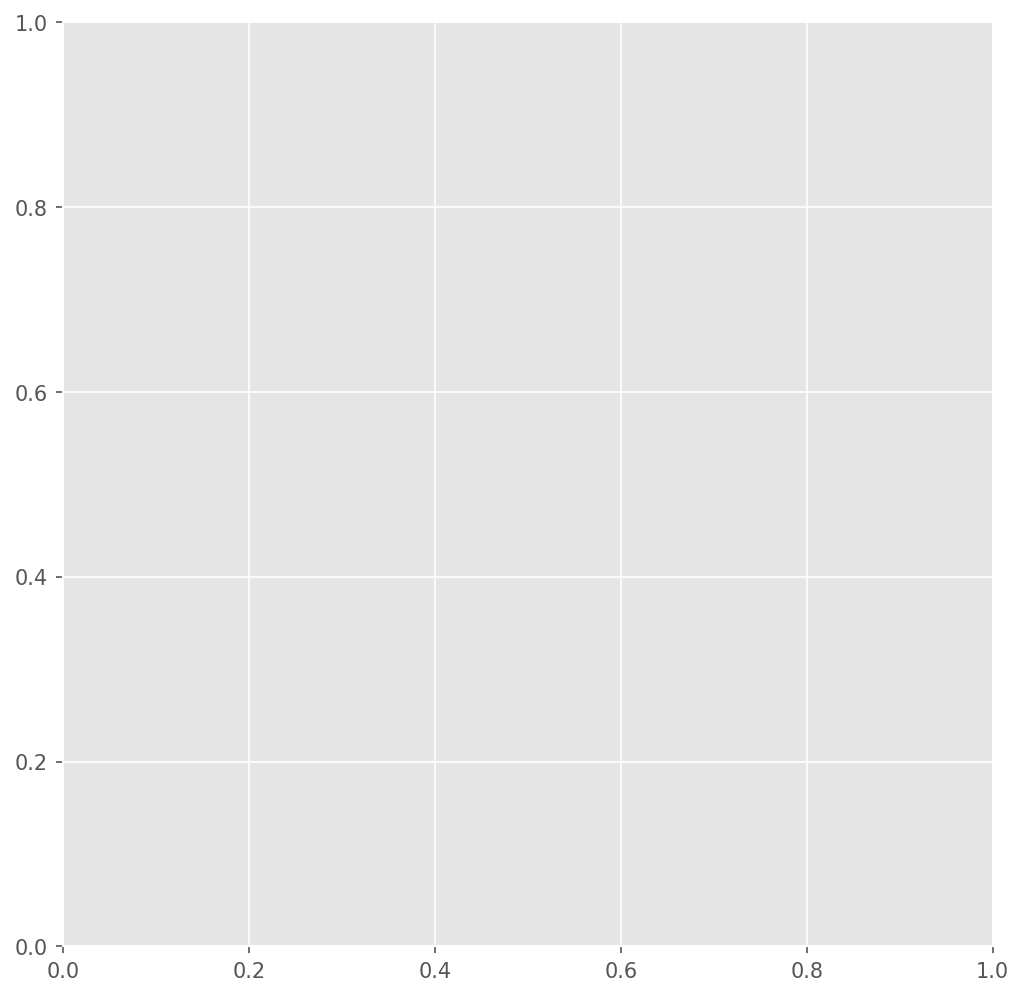

In [9]:
sns.lineplot(data=df.reset_index().melt("index"), x="index", y="value", hue="variable")

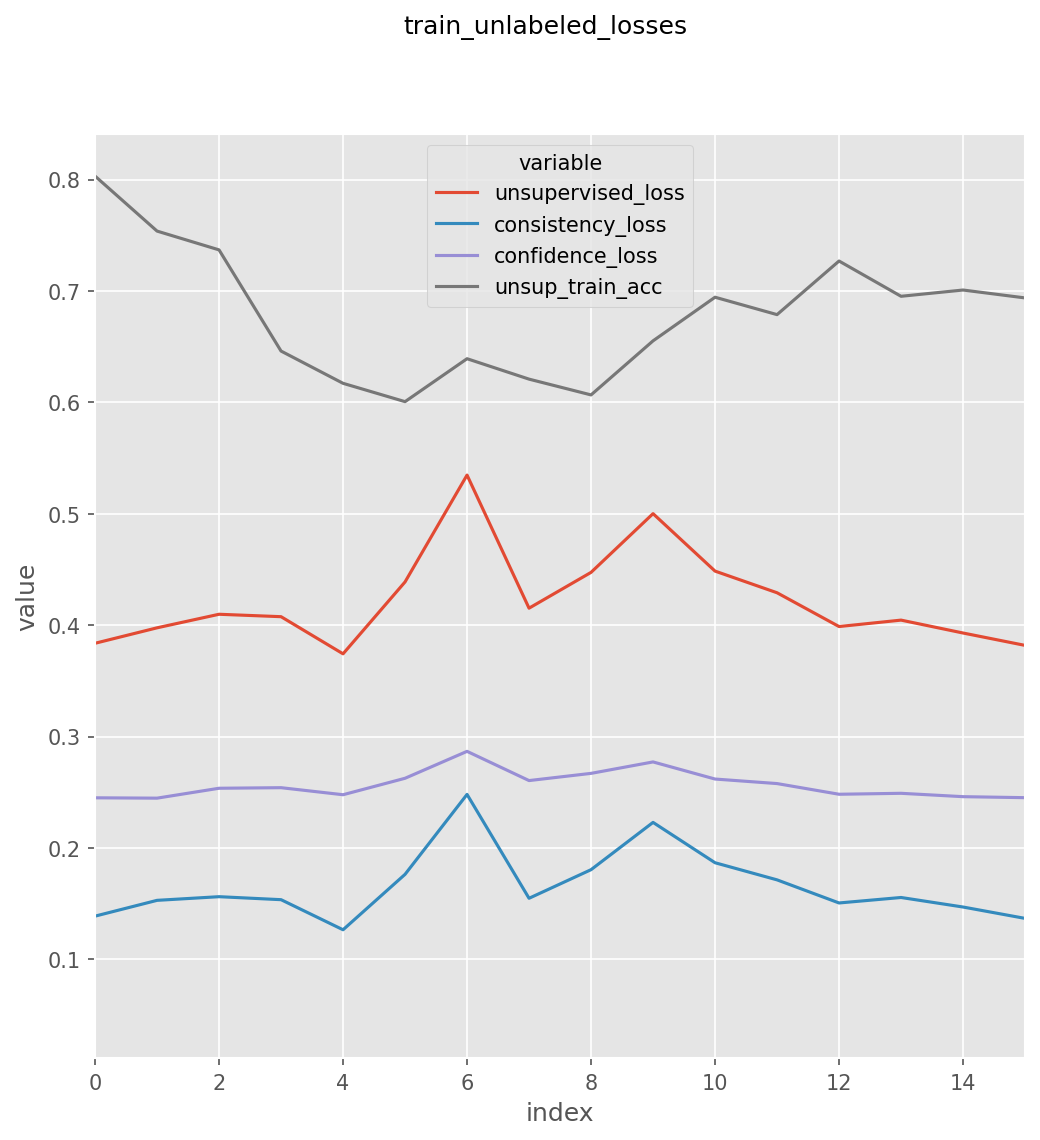

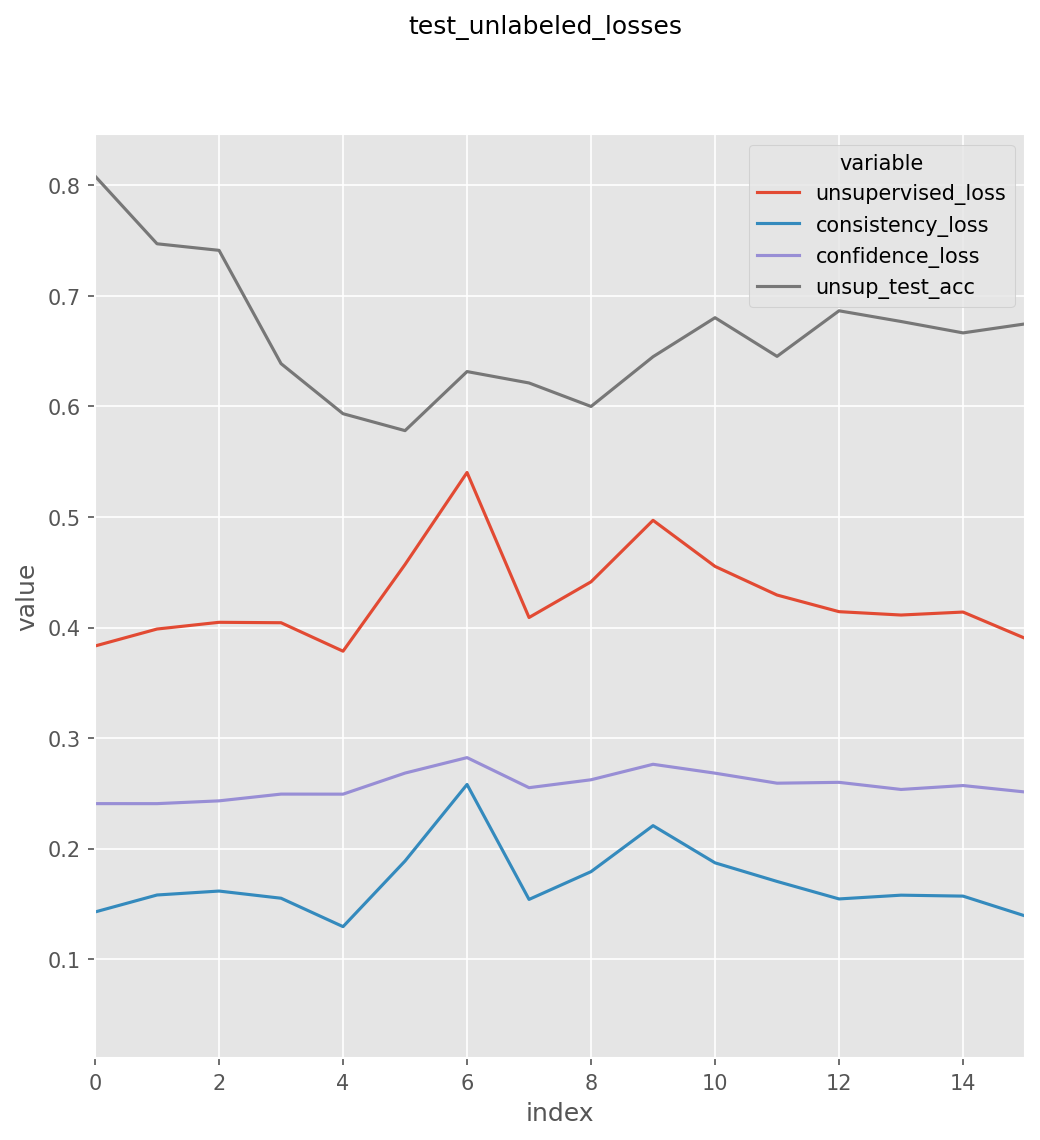

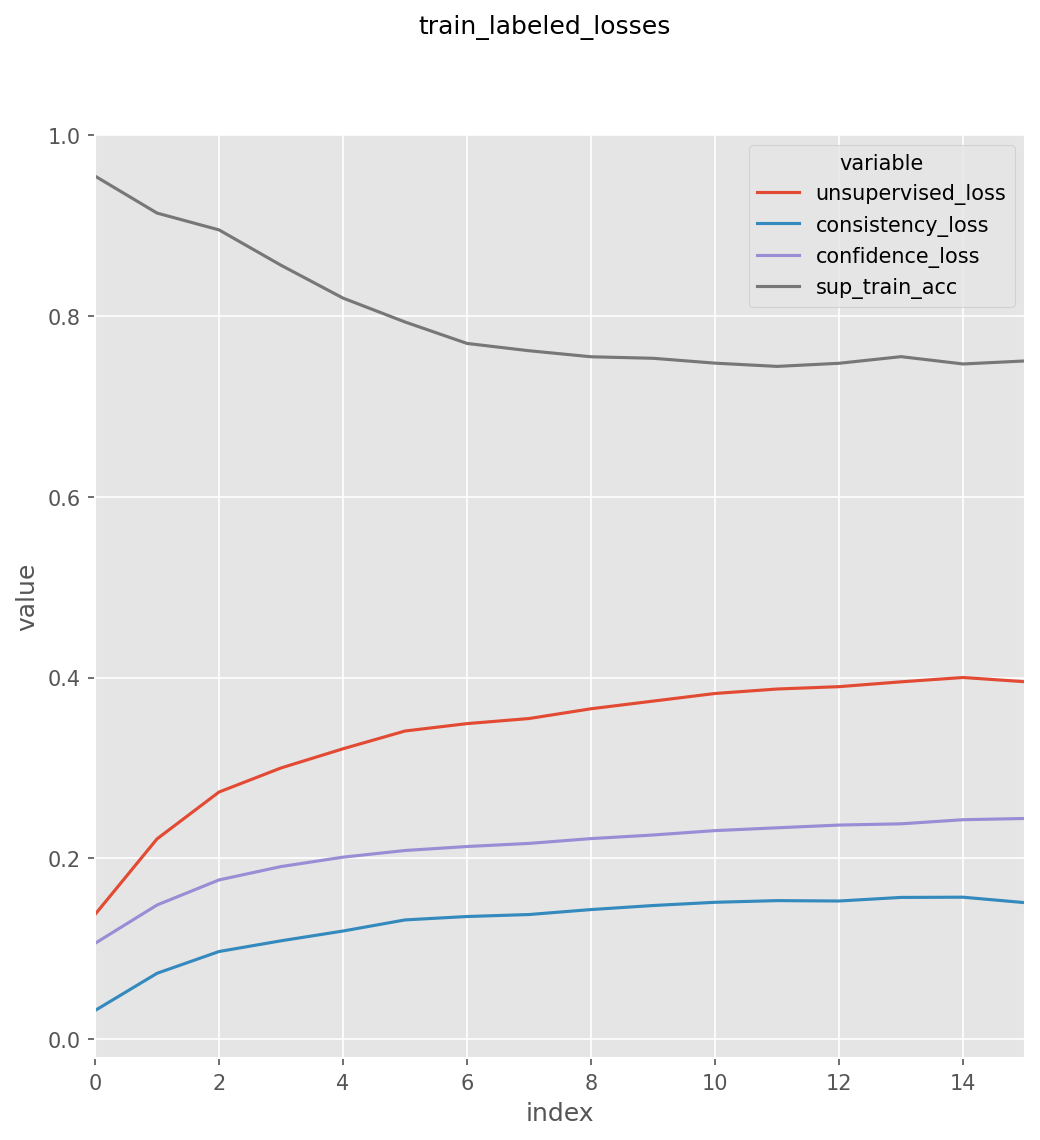

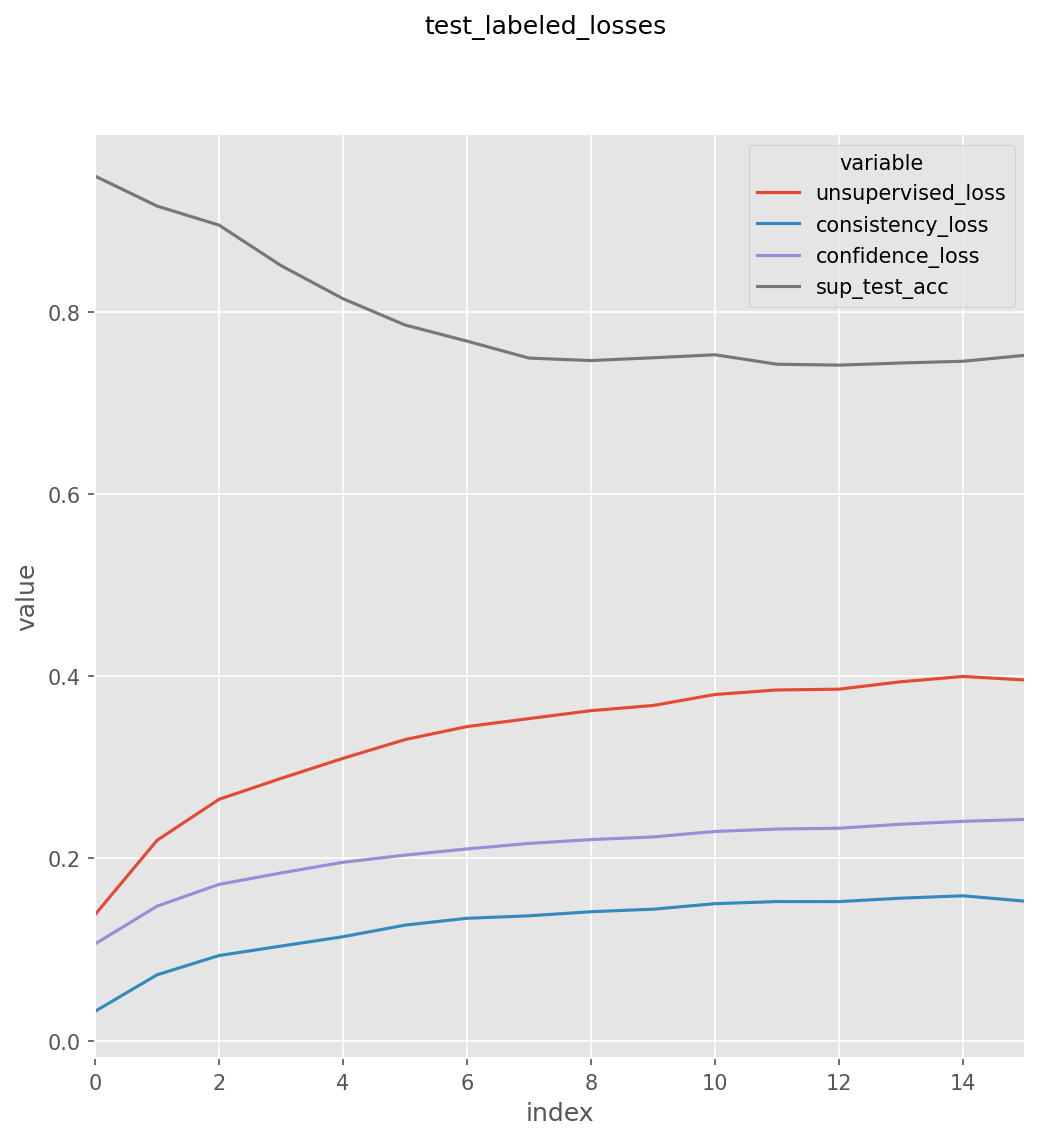

In [12]:
best_idx = fit_result["best_idx"]

loss_to_acc_name = {
    "train_unlabeled_losses": "unsup_train_acc",
    "test_unlabeled_losses": "unsup_test_acc",
    "train_labeled_losses": "sup_train_acc",
    "test_labeled_losses": "sup_test_acc",
}

for loss_name in [
    "train_unlabeled_losses",
    "test_unlabeled_losses",
    "train_labeled_losses",
    "test_labeled_losses",
]:
    df = pd.DataFrame(fit_result[loss_name])
    acc_name = loss_to_acc_name[loss_name]
    df[acc_name] = lr_orth_dirs_acc_df[acc_name]
    sns.lineplot(
        data=df.reset_index().melt("index"), x="index", y="value", hue="variable"
    )
    if "unlabeled" in loss_name:
        plt.axvline(best_idx, color="black", linestyle="--", alpha=0.3)
    plt.suptitle(loss_name)
    plt.xlim(0, 15)
    plt.show()

<Axes: >

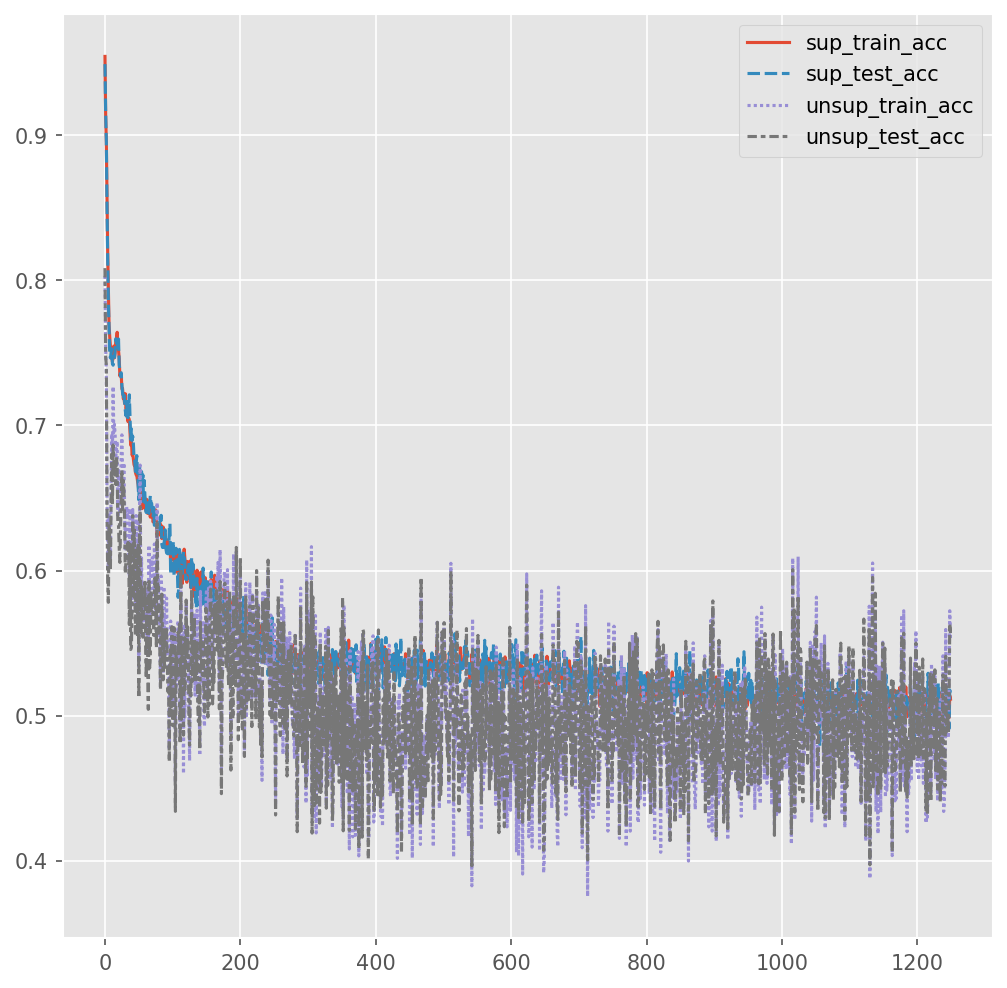

In [ ]:
sns.lineplot(lr_orth_dirs_acc_df)